In [2]:
from pathlib import Path

project_root_path = Path.cwd().parent
project_root_path

PosixPath('/mnt/c/Users/david/Master Data Science/Semestre 5 (Sep 2024 - Ene 2025)/TFM/Proyecto/tfm-rl-starcraft2')

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)

# Model paths

In [4]:
models_path = project_root_path / "models"
# models_path04 = project_root_path / "models" / "04"
# models_path = project_root_path / "models" / "05"
models_path_shorter = models_path / "05_shorter"
random_models_path = models_path / "random"
single_random_models_path = random_models_path / "single"
multi_random_models_path = random_models_path / "multi"
buffer_models_path = models_path / "create-buffers"
dqn_models_path = models_path / "dqn"
single_dqn_models_path = dqn_models_path / "single"
multi_dqn_models_path = dqn_models_path / "multi"
# models_path = project_root_path / "models_or"
images_path = Path.cwd() / "images"
images_path.mkdir(exist_ok=True, parents=True)
models_path

PosixPath('/mnt/c/Users/david/Master Data Science/Semestre 5 (Sep 2024 - Ene 2025)/TFM/Proyecto/tfm-rl-starcraft2/models')

In [5]:
models_path = project_root_path / "models"
experiment_path = models_path / "2024-11-18"
# sub_experiments = [
#     f"{ep}_{lr}_{eps}"
#     for ep in [30, 50, 100]
#     for lr in [0.001, 0.005]
#     for eps in [0.95, 0.99]
# ]

# Utils

In [6]:
import pandas as pd
import numpy as np

def assign_phase(row):
    if row["is_exploit"]:
        return "Exploit"
    if row["is_training"]:
        return "Training"
    return "Burn-in"


def get_agent_stats(model_path: str | Path):
    agent_stats_path = model_path / "agent_stats.parquet"
    
    return pd.read_parquet(agent_stats_path)

def get_aggregated_stats(model_path: str | Path):
    aggregated_stats_path = model_path / "aggregated_stats.parquet"

    return pd.read_parquet(aggregated_stats_path)

def add_extra_metrics(episode_stats):
    episode_stats['episode'] = np.arange(len(episode_stats))

    episode_stats["loss"] = episode_stats["losses"].apply(lambda losses: np.mean(losses))
    episode_stats['mean_loss_10ep'] = episode_stats['loss'].rolling(10, min_periods=1).mean()
    episode_stats['mean_reward_10ep'] = episode_stats['reward'].rolling(10, min_periods=1).mean()
    episode_stats['mean_adjusted_reward_10ep'] = episode_stats['adjusted_reward'].rolling(10, min_periods=1).mean()
    episode_stats['mean_score_10ep'] = episode_stats['score'].rolling(10, min_periods=1).mean()
    episode_stats['mean_emissions_10ep'] = episode_stats['emissions'].rolling(10, min_periods=1).mean()
    episode_stats["accumulated_emissions"] = np.cumsum(episode_stats["emissions"])

    return episode_stats

def get_episode_stats(model_path: str | Path):
    episode_stats_path = model_path / "episode_stats.parquet"

    episode_stats = pd.read_parquet(episode_stats_path)
    # episode_stats = episode_stats.drop_duplicates(subset=["episode"])
    episode_stats = add_extra_metrics(episode_stats)
    
    return episode_stats

def get_emission_stats(model_path: str | Path):
    emission_stats_path = model_path / "emissions.csv"

    if emission_stats_path.exists():
        emission_stats = pd.read_csv(emission_stats_path)
        emission_stats["timestamp"] = pd.to_datetime(emission_stats["timestamp"])
        emission_stats["timedelta"] = (emission_stats["timestamp"] - emission_stats["timestamp"].shift(1)).astype('timedelta64[s]').apply(lambda v: v.seconds).fillna(0.)
        emission_stats["accumulated_time"] = np.cumsum(emission_stats["timedelta"])
        # emission_stats = add_extra_metrics(episode_stats)
        
        return emission_stats
    else:
        return None


In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize":(18, 9)})

def plot_line(episode_stats, model_name: str, label: str, metric_column: str, use_stages: bool = True, save_path: Path = None, save_prefix: str = None, stages: list[str] = ["TRAINING"]):
    if not stages:
        print("Plotting all stages")
    else:
        print(f"Plotting only {', '.join(stages)} episodes")
        episode_stats = episode_stats[episode_stats["initial_stage"].isin(stages)].copy()
        episode_stats = add_extra_metrics(episode_stats)

    if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
        extra_args = dict(label=label)
    else:
        extra_args = dict(hue="initial_stage")
        
    ax = sns.lineplot(data=episode_stats, x="episode", y=metric_column, **extra_args)
    ax.set_title(f"{model_name} - {label} over time", fontsize=24)
    ax.set_xlabel("Episode", fontsize=24)
    ax.set_ylabel(label, fontsize=24)
    ax.tick_params(labelsize=18)
    mean_col = f"mean_{metric_column}_10ep"
    if mean_col in list(episode_stats):
        sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")
    if save_path is not None:
        save_path.mkdir(exist_ok=True, parents=True)
        filename = f"{metric_column}.png" if save_prefix is None else f"{save_prefix}_{metric_column}.png"
        plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
    min_value = episode_stats[metric_column].min()
    plt.ylim(bottom=min(0, min_value * 1.1))
    plt.show()
    
def plot_hist(episode_stats, model_name: str, label: str, metric_column: str, use_stages: bool = True, save_path: Path = None, save_prefix: str = None, stages: list[str] = ["TRAINING"]):
    if not stages:
        print("Plotting all stages")
    else:
        print(f"Plotting only {', '.join(stages)} episodes")
        episode_stats = episode_stats[episode_stats["initial_stage"].isin(stages)].copy()
        episode_stats = add_extra_metrics(episode_stats)

    if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
        extra_args = dict(label=label)
    else:
        extra_args = dict(hue="initial_stage")
        
    # ax = sns.lineplot(data=episode_stats, x="episode", y="reward", **extra_args)
    ax = sns.histplot(data=episode_stats, x=metric_column)
    ax.set_title(f"{model_name} - Distribution of {label} per episode", fontsize=24)
    ax.set_xlabel(label,fontsize=24)
    ax.set_ylabel("Count",fontsize=24)
    ax.tick_params(labelsize=18)
    
    plt.axvline(episode_stats[metric_column].mean(), c="orange", label=f"Mean {metric_column}", linestyle="--") ;
    
    if save_path is not None:
        save_path.mkdir(exist_ok=True, parents=True)
        filename = f"{metric_column}_hist.png" if save_prefix is None else f"{save_prefix}_{metric_column}_hist.png"
        plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)

    min_value = episode_stats[metric_column].min()
    max_value = episode_stats[metric_column].max()
    plt.xlim(left=min(0, min_value * 1.1), right=max_value * 1.1)
    plt.legend()
    plt.show()

# Steps
def plot_steps_hist(**kwargs):
    plot_hist(label="Steps", metric_column="steps", **kwargs)

def plot_steps_over_time(**kwargs):
    plot_line(label="Steps", metric_column="steps", **kwargs)

# Rewards
def plot_rewards(**kwargs):
    plot_rewards_over_time(**kwargs)
    plot_rewards_hist(**kwargs)

def plot_rewards_over_time(**kwargs):
    plot_line(label="Reward", metric_column="reward", **kwargs)

def plot_rewards_hist(**kwargs):
    plot_hist(label="Reward", metric_column="reward", **kwargs)

# Adjusted rewards
def plot_adjusted_rewards(**kwargs):
    plot_adjusted_rewards_over_time(**kwargs)
    plot_adjusted_rewards_hist(**kwargs)

def plot_adjusted_rewards_over_time(**kwargs):
    plot_line(label="Adjusted Reward", metric_column="adjusted_reward", **kwargs)

def plot_adjusted_rewards_hist(**kwargs):
    plot_hist(label="Adjusted Reward", metric_column="adjusted_reward", **kwargs)

# Scores
def plot_scores(**kwargs):
    plot_scores_over_time(**kwargs)
    plot_scores_hist(**kwargs)

def plot_scores_over_time(**kwargs):
    plot_line(label="Score", metric_column="score", **kwargs)

def plot_scores_hist(**kwargs):
    plot_hist(label="Score", metric_column="score", **kwargs)

# Emissions
def plot_emissions(emission_stats, save_path, model_name):
    label = "Total Energy consumed over time (kWh)"
    metric_column = "energy_consumed"

    ax = sns.lineplot(data=emission_stats, x="accumulated_time", y=metric_column, label=label)
    ax.set_title(f"{label} - {model_name}", fontsize=24)
    ax.set_xlabel("Time (seconds)", fontsize=24)
    ax.set_ylabel("Energy (kWh)", fontsize=24)
    ax.tick_params(labelsize=18)
    
    if save_path is not None:
        save_path.mkdir(exist_ok=True, parents=True)
        filename = f"{metric_column}.png"
        plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
    min_value = emission_stats[metric_column].min()
    plt.ylim(bottom=min(0, min_value * 1.1))
    plt.show()

# Loss
def plot_losses(episode_stats, **kwargs):
    # train_episodes = episode_stats[episode_stats["initial_stage"] == "TRAINING"]
    if len(episode_stats) == 0:
        print("No losses to plot (there are no training episodes")
        return
    plot_losses_over_time(episode_stats=episode_stats, **kwargs)
    plot_losses_hist(episode_stats=episode_stats, **kwargs)

def plot_losses_over_time(**kwargs):
    plot_line(label="Loss", metric_column="loss", **kwargs)

def plot_losses_hist(**kwargs):
    plot_hist(label="Loss", metric_column="loss", **kwargs)

def plot_epsilon(episode_stats, **kwargs):
    # train_episodes = episode_stats[episode_stats["initial_stage"] == "TRAINING"]
    if len(episode_stats) == 0:
        print("No epsilon to plot (there are no training episodes")
        return
    plot_line(episode_stats=episode_stats, label="Epsilon", metric_column="epsilon", **kwargs)


In [8]:
def plot_stats(episode_stats, model_name, use_stages: bool = True, save_path: Path = None, save_prefix: str = None):
    plot_rewards(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_rewards_hist(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_adjusted_rewards(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_scores(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_emissions(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix) ;
    plot_losses(episode_stats=episode_stats, model_name=model_name, save_path=save_path, save_prefix=save_prefix) ;
    plot_epsilon(episode_stats=episode_stats, model_name=model_name, save_path=save_path, save_prefix=save_prefix) ;

In [9]:
def load_stats(model_name: str, model_path: str | Path, show_plots: bool = True, use_stages: bool = True, save_path: Path = None, save_prefix: str = None):
    agent_stats = get_agent_stats(model_path)
    aggregated_stats = get_aggregated_stats(model_path)
    episode_stats = get_episode_stats(model_path)
    emission_stats = get_emission_stats(model_path)
    total_episodes = len(episode_stats)
    total_training_episodes = len(episode_stats[episode_stats["initial_stage"] == "TRAINING"])
    total_exploit_episodes = len(episode_stats[episode_stats["initial_stage"] == "EXPLOIT"])
    total_burnin_episodes = len(episode_stats[episode_stats["initial_stage"] == "BURN_IN"])
    total_random_mode_episodes = len(episode_stats[episode_stats["is_random_mode"] == True])
    print(f"Total episodes: {total_episodes}")
    print(f"Total burnin episodes: {total_burnin_episodes}")
    print(f"Total random mode episodes: {total_random_mode_episodes}")
    print(f"Total training episodes: {total_training_episodes}")
    print(f"Total exploit episodes: {total_exploit_episodes}")
    print("Unique maps in episode stats: ", episode_stats["map_name"].unique())

    if show_plots:
        plot_stats(episode_stats=episode_stats, model_name=model_name, use_stages=use_stages, save_path=save_path, save_prefix=save_prefix)
    
    return episode_stats, agent_stats, aggregated_stats, emission_stats
    

0.028553837205777297


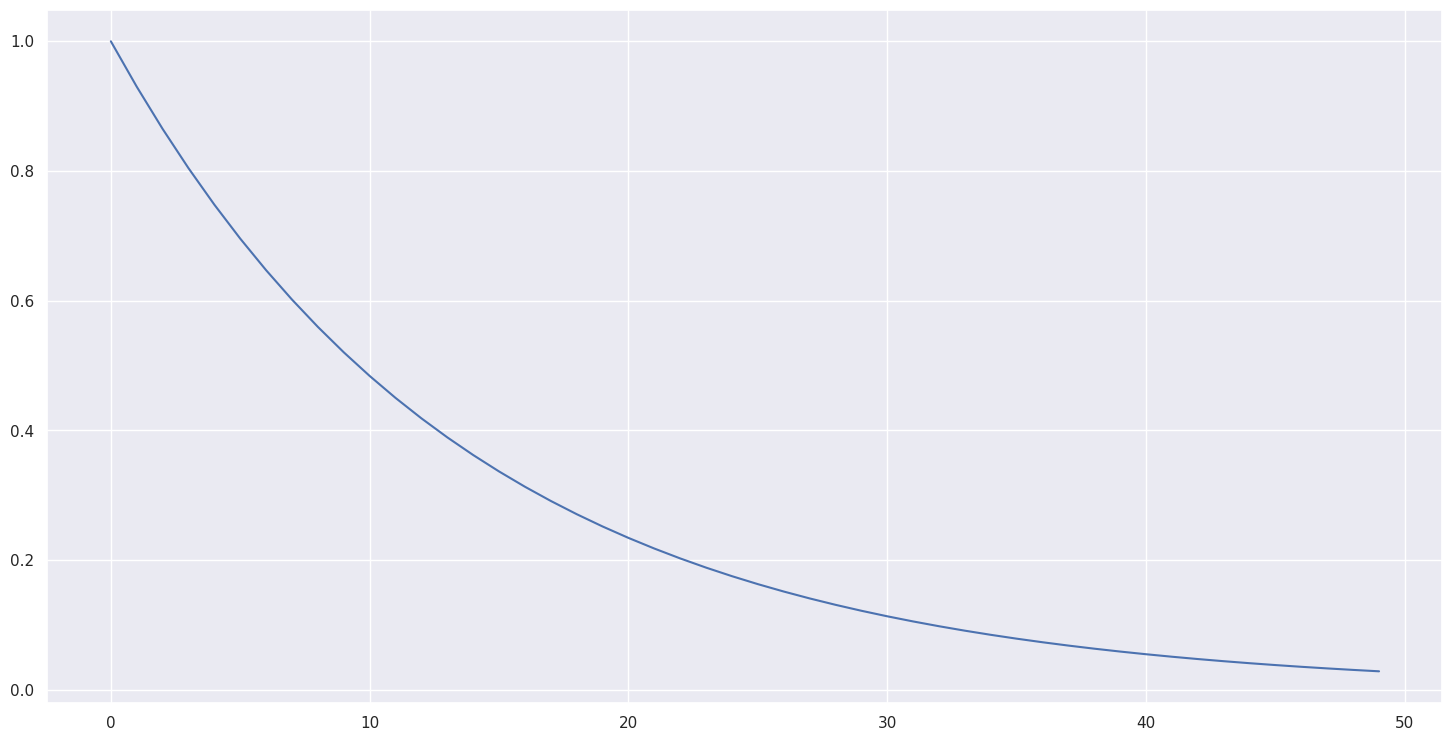

In [94]:
start_eps = 1
decay = 0.93
epsilon = start_eps
epsilons = []

episodes = 50
for i in range(episodes):
    epsilons.append(epsilon)
    epsilon *= decay
    

print(epsilons[-1])
sns.lineplot(x=list(range(episodes)), y=epsilons) ;

# Single DQN Agent

## Template

In [95]:
model_id = "collect_minerals"
scenario_name = "CollectMinerals"
reward_scheme = "reward"
reward_scheme_name = "Default"
model_path = single_dqn_models_path / reward_scheme
save_images_path = images_path / "dqn" / "single" / model_id / reward_scheme
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"DQN Agent - {scenario_name} - {reward_scheme_name} rewards"
save_prefix = f"dqn_standalone_{reward_scheme}_{model_id}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats = load_stats(model_id, model_path=model_path, save_prefix=save_prefix, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

TypeError: load_stats() got multiple values for argument 'model_name'

In [ ]:
plot_losses(**plot_args) ;
plot_rewards(**plot_args) ;
plot_adjusted_rewards(**plot_args) ;
plot_scores(**plot_args) ;
plot_emissions(**plot_args) ;
plot_epsilon(**plot_args) ;

## Simple64

### Random baseline

In [9]:
experiment_path = models_path / "RandomBaseline"

scenario_name = "Simple64"
model_suffix = f"single_random"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Single Agent - {scenario_name} - Random baseline"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

Total episodes: 100
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 0
Total exploit episodes: 100
Unique maps in episode stats:  ['Simple64']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


map_name  reward  adjusted_reward  steps  epsilon losses  emissions  \
0  Simple64      -1            -38.7    377      1.0     []        0.0   
1  Simple64      -1            -32.9    319      1.0     []        0.0   
2  Simple64      -1            -50.6    496      1.0     []        0.0   
3  Simple64      -1            -40.3    393      1.0     []        0.0   
4  Simple64       1            -29.2    302      1.0     []        0.0   

     score  is_burnin  is_training  is_exploit  is_random_mode initial_stage  \
0 -12710.0      False        False        True           False       EXPLOIT   
1 -12130.0      False        False        True           False       EXPLOIT   
2 -13850.0      False        False        True           False       EXPLOIT   
3 -12870.0      False        False        True           False       EXPLOIT   
4   5940.0      False        False        True           False       EXPLOIT   

  final_stage  episode  loss invalid_action_counts  \
0     EXPLOIT        0   NaN          {'dummy': 0}   
1     EXPLOIT        1   NaN          {'dummy': 0}   
2     EXPLOIT        2   NaN          {'dummy': 0}   
3     EXPLOIT        3   NaN          {'dummy': 0}   
4     EXPLOIT        4   NaN          {'dummy': 0}   

                                 valid_action_counts  mean_loss_10ep  \
0  {'ATTACK_ARMY': 3.0, 'ATTACK_BUILDINGS': 11.0,...             NaN   
1  {'ATTACK_ARMY': 8.0, 'ATTACK_BUILDINGS': 7.0, ...             NaN   
2  {'ATTACK_ARMY': 17.0, 'ATTACK_BUILDINGS': 25.0...             NaN   
3  {'ATTACK_ARMY': 6.0, 'ATTACK_BUILDINGS': 8.0, ...             NaN   
4  {'ATTACK_ARMY': 8.0, 'ATTACK_BUILDINGS': 30.0,...             NaN   

   mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
0              -1.0                 -38.700000    -12710.000000   
1              -1.0                 -35.800000    -12420.000000   
2              -1.0                 -40.733333    -12896.666667   
3              -1.0                 -40.625000    -12890.000000   
4              -0.6                 -38.340000     -9124.000000   

   mean_emissions_10ep  accumulated_emissions  
0                  0.0                    0.0  
1                  0.0                    0.0  
2                  0.0                    0.0  
3                  0.0                    0.0  
4                  0.0                    0.0

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/tmp/ipykernel_238798/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


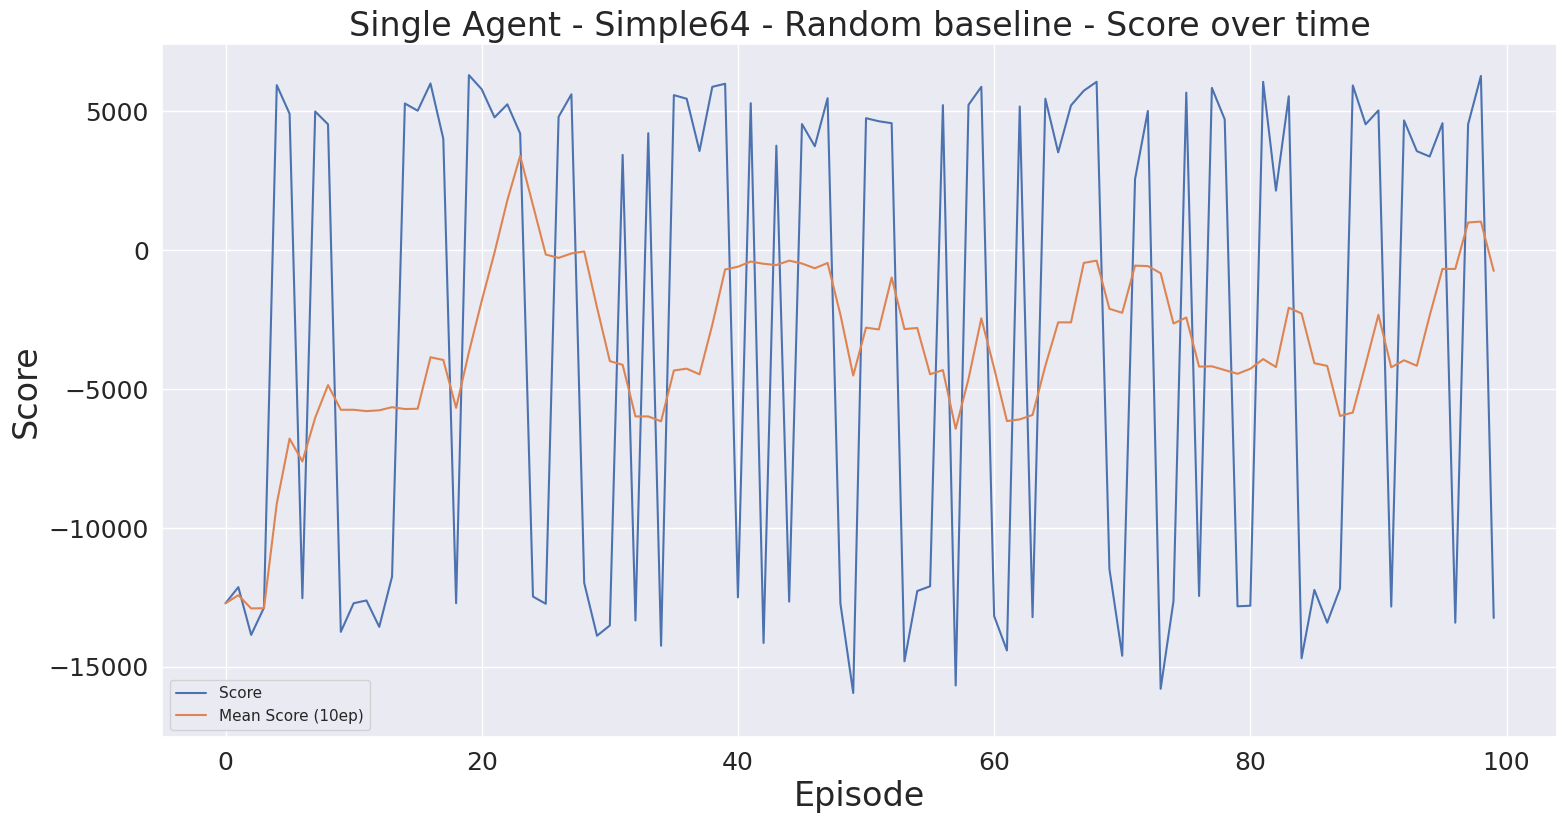

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


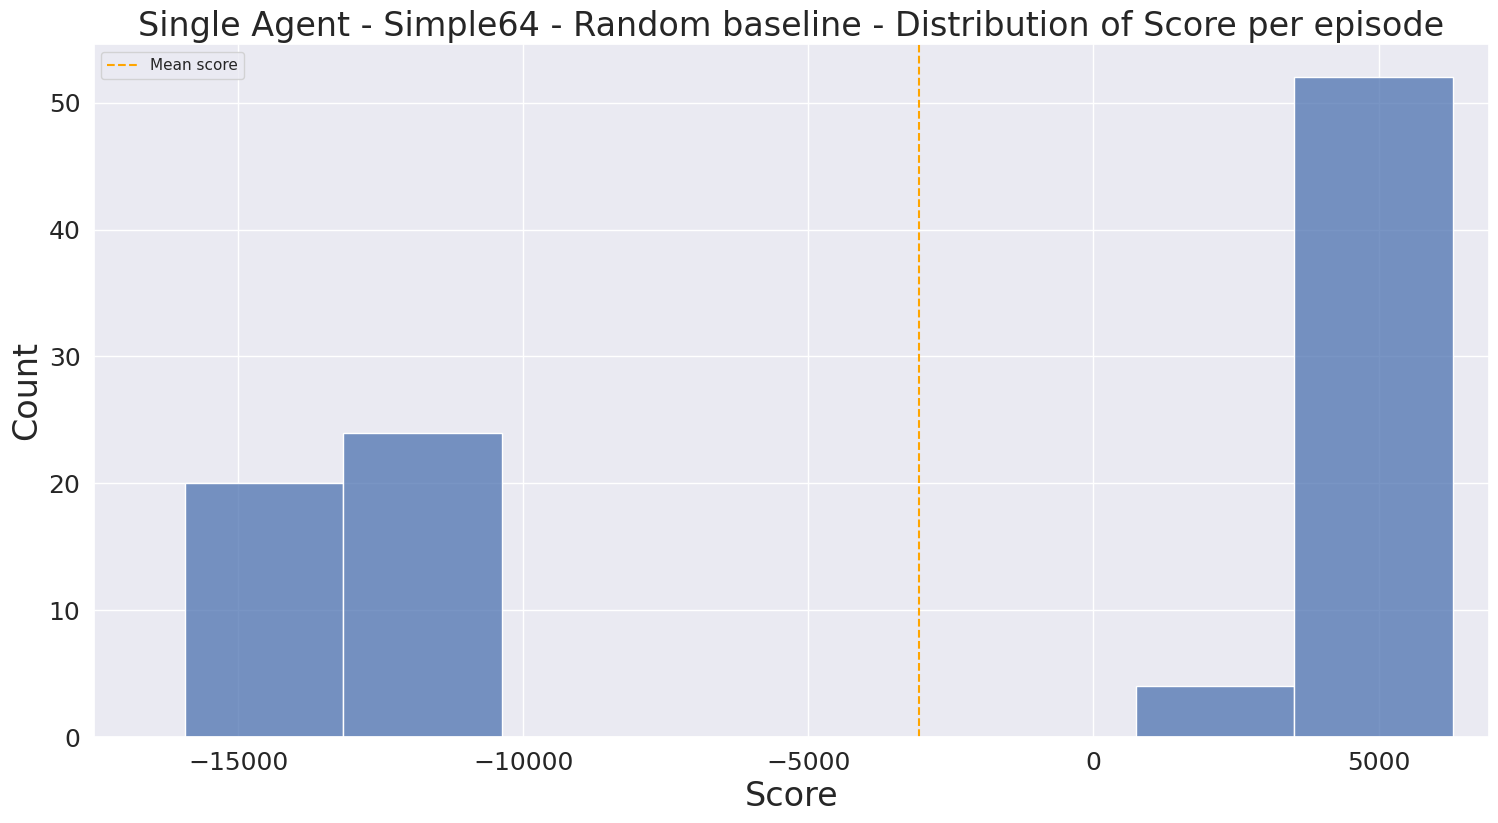

In [10]:
plot_scores(stages=["EXPLOIT"],**plot_args) ;

### Score scheme Training

In [12]:
experiment_path = models_path / "best_32"

scenario_name = "Simple64"
model_suffix = f"single_dqn_l_200"
# model_suffix = f"single_dqn_m_130"
model_path = experiment_path / model_suffix
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Single Agent (large) - {scenario_name}"
# model_name = f"Single Agent (medium) - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 212
Total burnin episodes: 12
Total random mode episodes: 0
Total training episodes: 200
Total exploit episodes: 0
Unique maps in episode stats:  ['Simple64']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps   epsilon  \
207  Simple64      -1            -38.6    376  0.019263   
208  Simple64       1            -30.9    319  0.018878   
209  Simple64       1            -42.6    436  0.018500   
210  Simple64       1            -51.8    528  0.018130   
211  Simple64       1            -38.6    396  0.017767   

                                                losses  emissions  \
207  [108.45011138916016, 94.84283447265625, 99.449...   0.142699   
208  [96.82349395751953, 86.08177947998047, 92.9465...   0.102387   
209  [95.85519409179688, 101.77395629882812, 96.150...   0.164653   
210  [115.37332916259766, 107.24663543701172, 102.7...   0.144853   
211  [115.39462280273438, 109.13496398925781, 113.4...   0.103896   

            score  is_burnin  is_training  is_exploit  is_random_mode  \
207 -12537.500000      False         True       False           False   
208   5720.000000      False         True       False           False   
209   4600.000000      False         True       False           False   
210   3680.000000      False         True       False           False   
211   4992.156863      False         True       False           False   

    initial_stage final_stage  episode        loss invalid_action_counts  \
207      TRAINING    TRAINING      207   99.569608          {'dummy': 0}   
208      TRAINING    TRAINING      208   99.614555          {'dummy': 0}   
209      TRAINING    TRAINING      209  101.590752          {'dummy': 0}   
210      TRAINING    TRAINING      210  102.090573          {'dummy': 0}   
211      TRAINING    TRAINING      211  102.144752          {'dummy': 0}   

                                   valid_action_counts  mean_loss_10ep  \
207  {'ATTACK_ARMY': None, 'ATTACK_BUILDINGS': None...       97.794246   
208  {'ATTACK_ARMY': None, 'ATTACK_BUILDINGS': 20.0...       98.297752   
209  {'ATTACK_ARMY': 47.0, 'ATTACK_BUILDINGS': 20.0...       98.969830   
210  {'ATTACK_ARMY': None, 'ATTACK_BUILDINGS': 16.0...       99.549214   
211  {'ATTACK_ARMY': 1.0, 'ATTACK_BUILDINGS': 29.0,...      100.058800   

     mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
207               0.0                     -38.84     -3845.250000   
208               0.0                     -39.37     -3903.250000   
209               0.0                     -40.61     -4027.250000   
210               0.0                     -42.73     -4236.750000   
211               0.2                     -42.53     -2447.534314   

     mean_emissions_10ep  accumulated_emissions  
207             0.127642              13.555255  
208             0.128134              13.657642  
209             0.132855              13.822295  
210             0.139481              13.967148  
211             0.138035              14.071044

In [13]:
emission_stats.iloc[-1]

timestamp                                           2024-12-14 12:43:52
project_name                                                 codecarbon
run_id                             3b40baef-def2-4405-a364-e4b411c5d824
duration                                                   12532.741888
emissions                                                      0.020814
emissions_rate                                                 0.000002
cpu_power                                                          32.5
gpu_power                                                           0.0
ram_power                                                      2.888793
cpu_energy                                                     0.113142
gpu_energy                                                            0
ram_energy                                                     0.010056
energy_consumed                                                0.123199
country_name                                                    

In [36]:
value_counts = episode_stats[episode_stats["initial_stage"] == "TRAINING"]["reward"].value_counts()
total_lost = value_counts[-1] if -1 in value_counts else 0
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1] if 1 in value_counts else 0
total_games = total_won + total_lost + total_ties
pct_victories = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

Win rate: 58.00%
Tie rate: 0.00%
Lose rate: 42.00%


In [37]:
episode_stats.final_stage.unique()

array(['BURN_IN', 'TRAINING'], dtype=object)

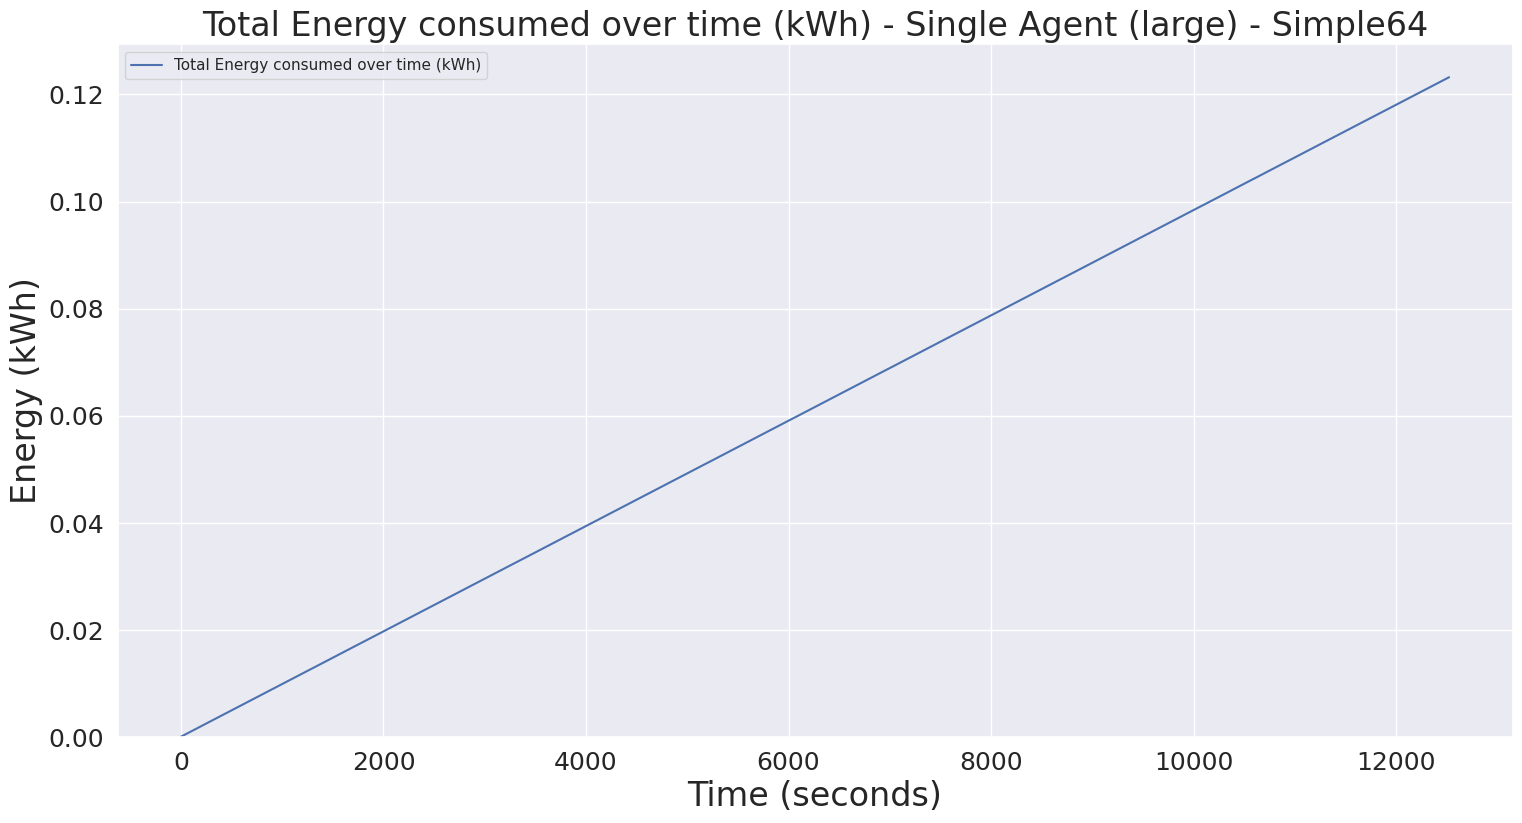

In [14]:
plot_emissions(emission_stats, save_images_path, model_name)

Min/AVG/Max steps per episode:  229 401.9622641509434 1025
Plotting only TRAINING episodes


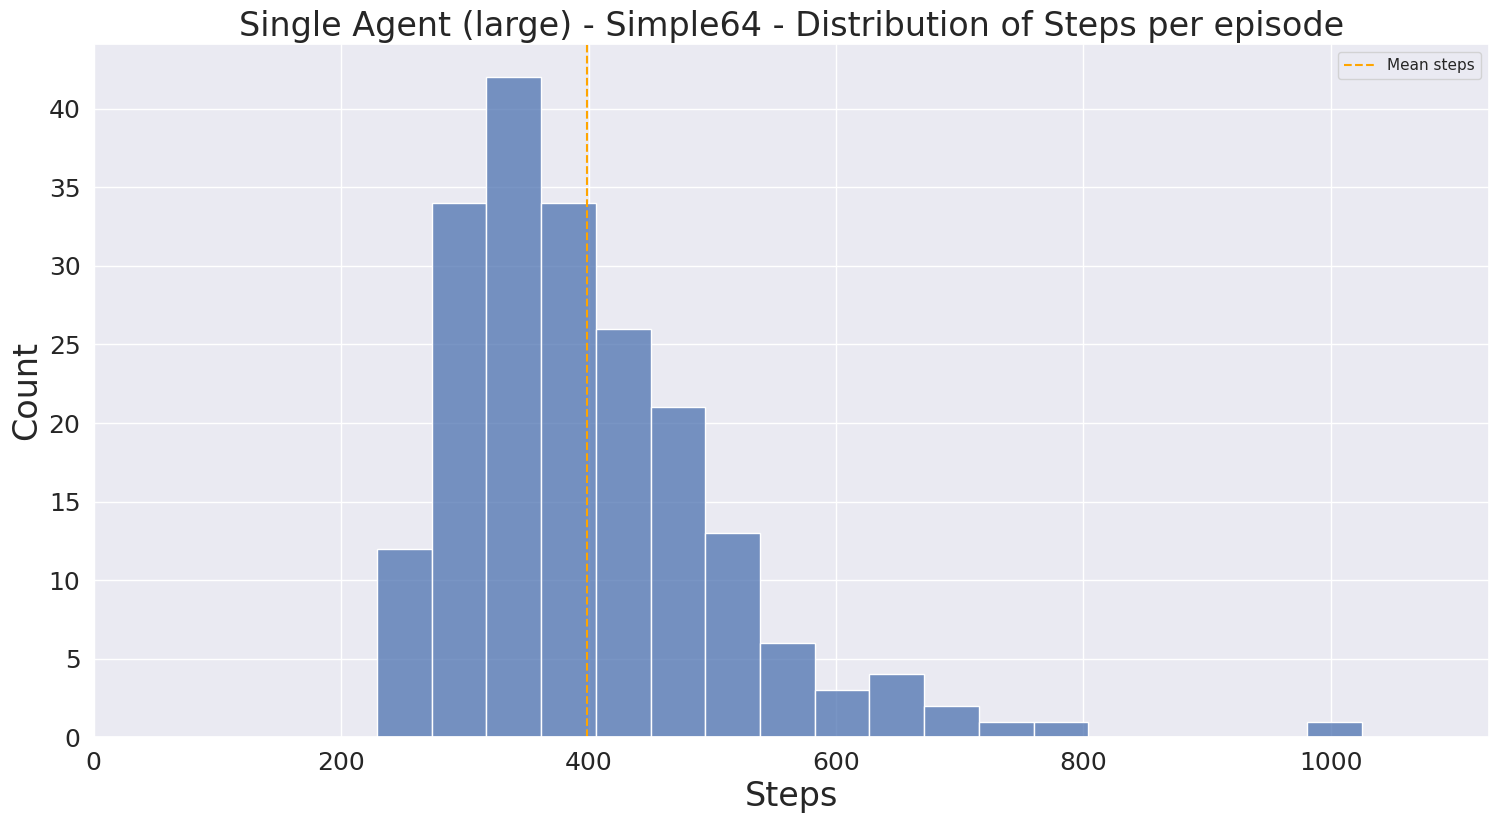

In [15]:
print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args)

Plotting only TRAINING episodes


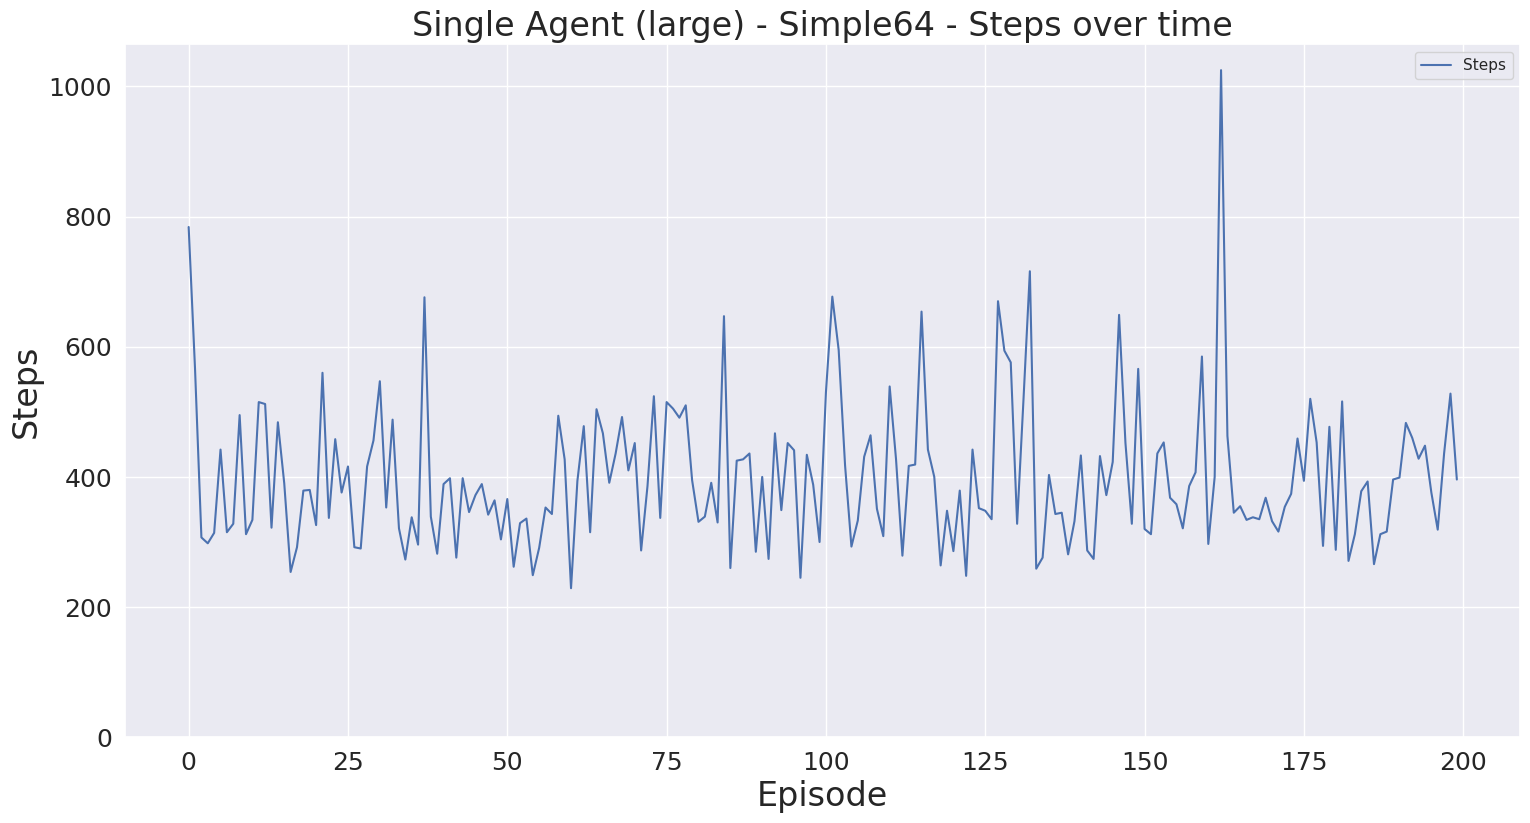

In [16]:
plot_steps_over_time(**plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_239520/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


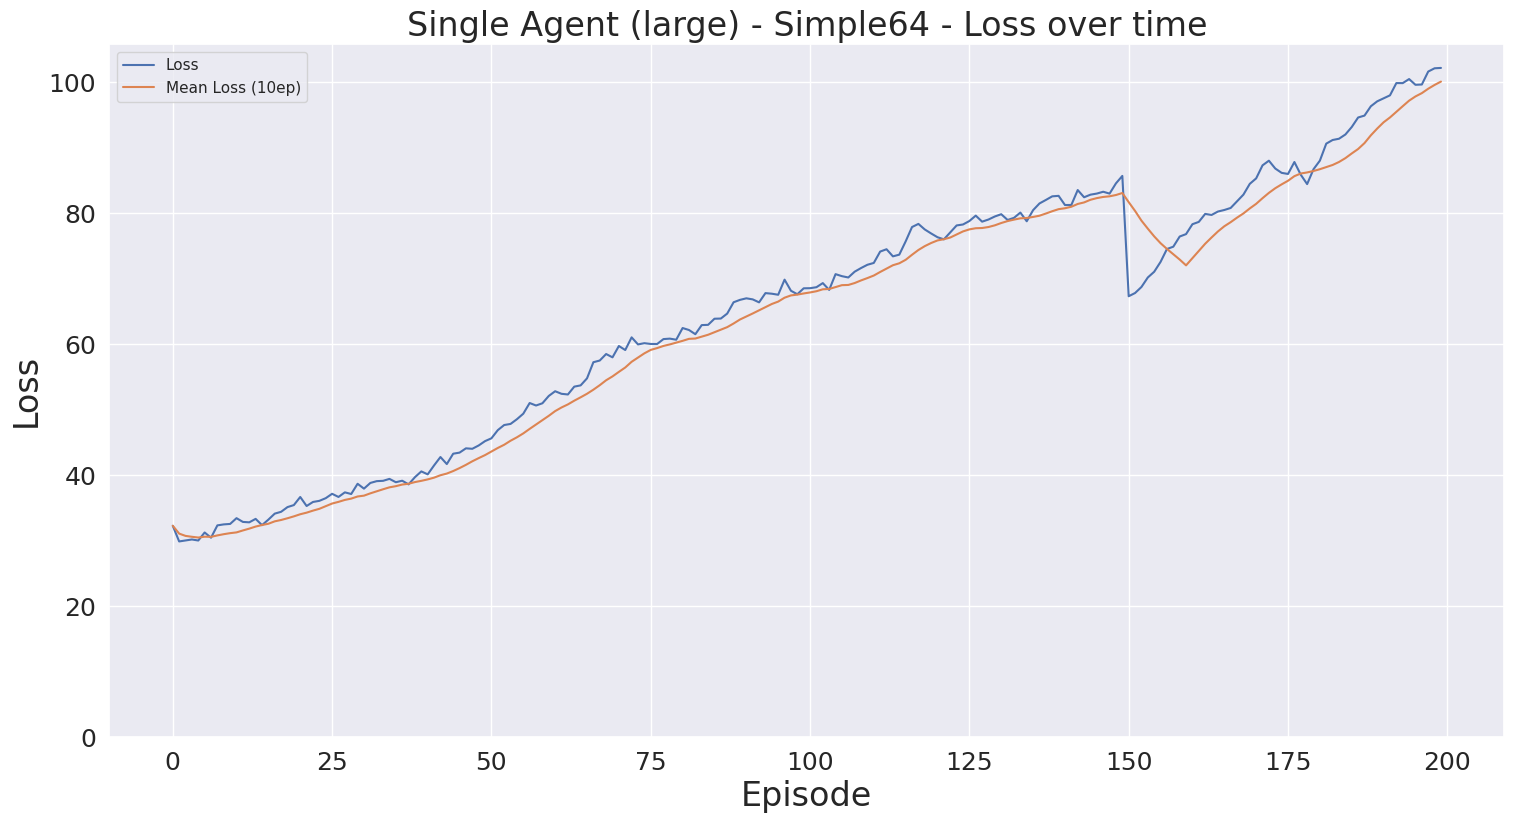

Plotting only TRAINING episodes


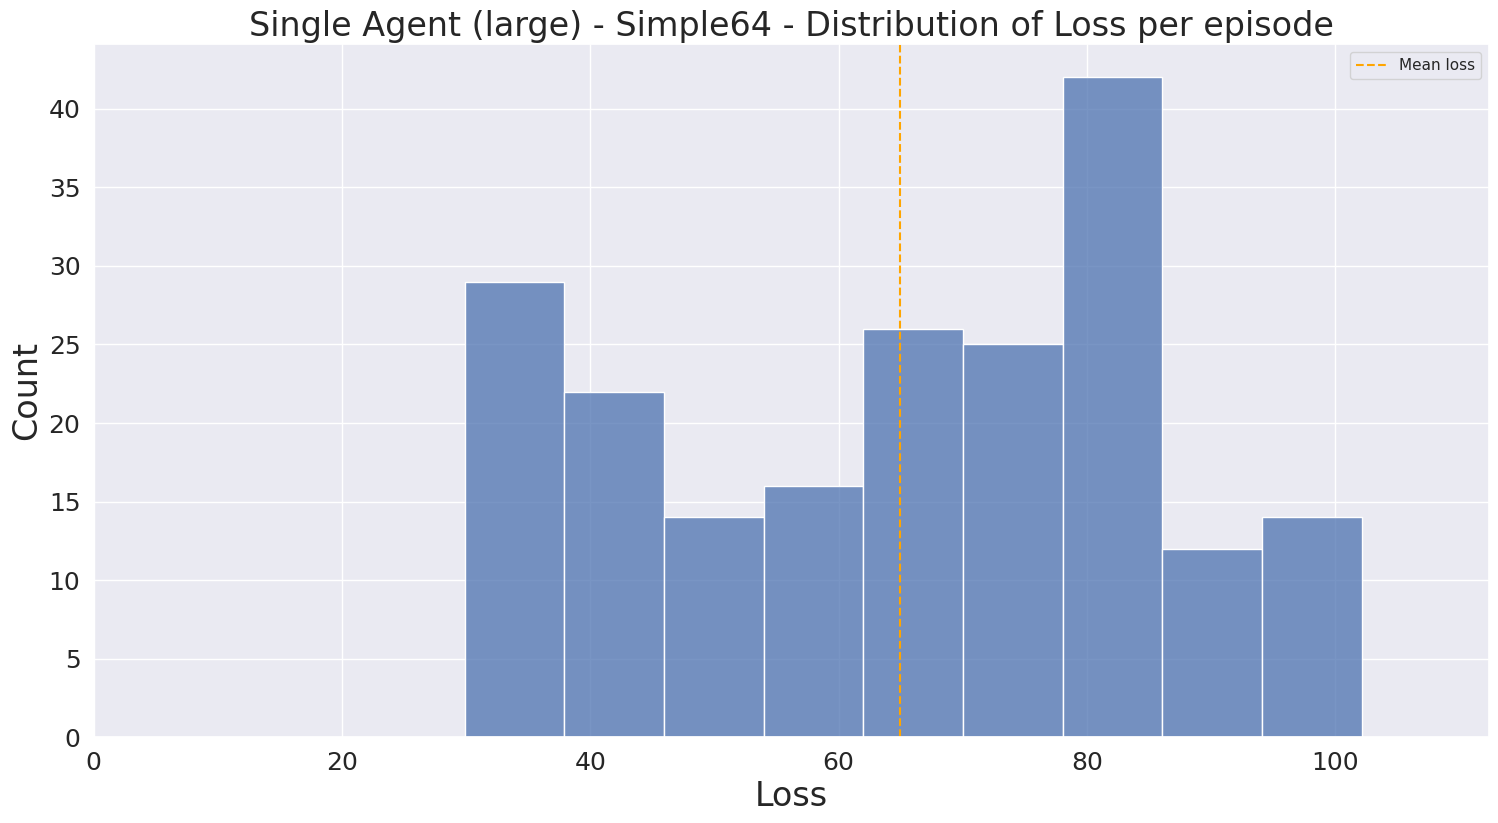

In [17]:
plot_losses(stages=["TRAINING"], **plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_239520/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


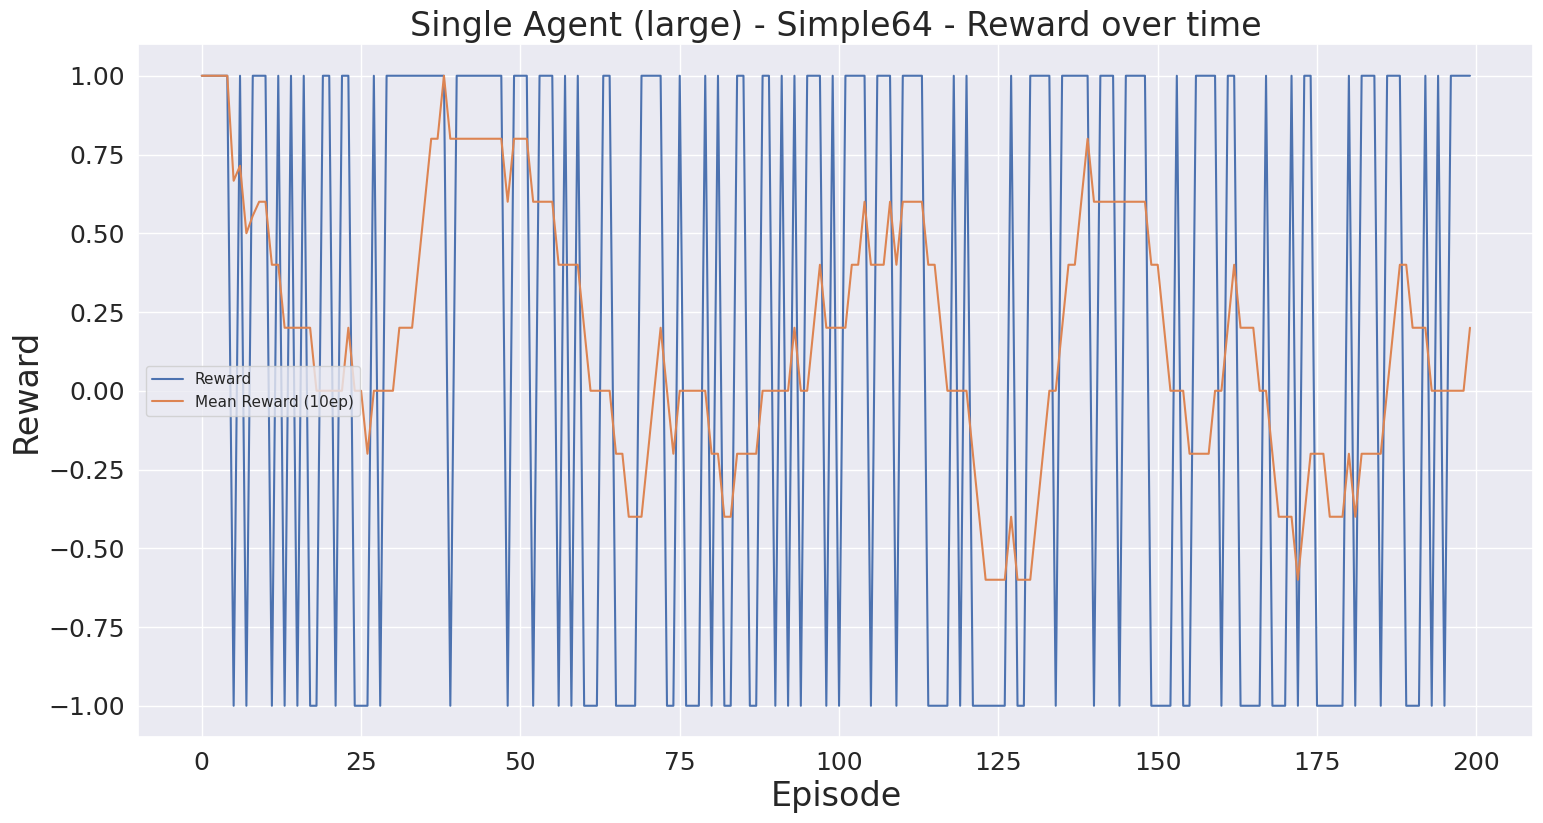

Plotting only TRAINING episodes


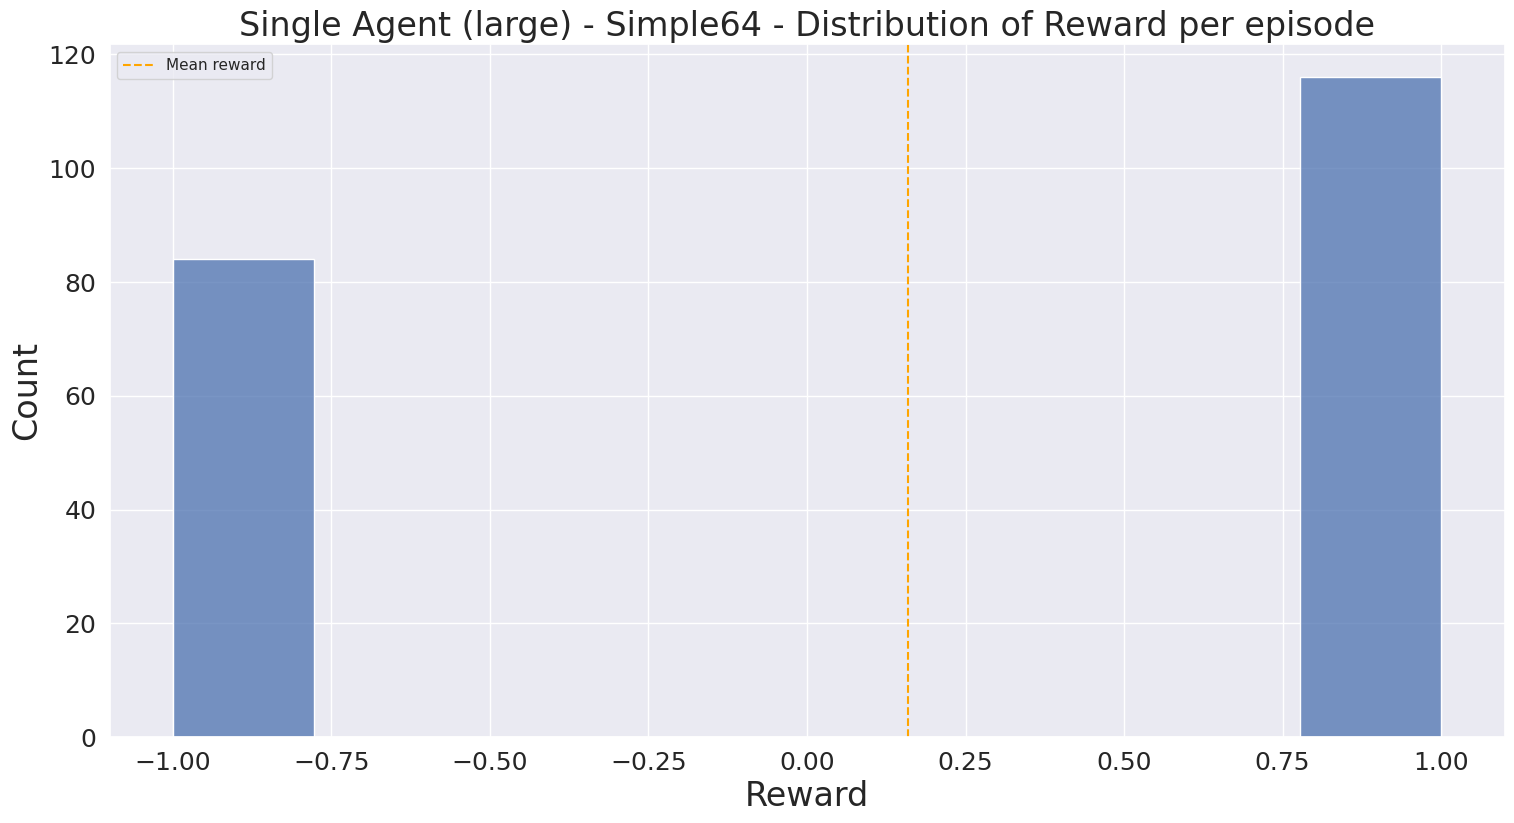

In [18]:
plot_rewards(stages=["TRAINING"], **plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_239520/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


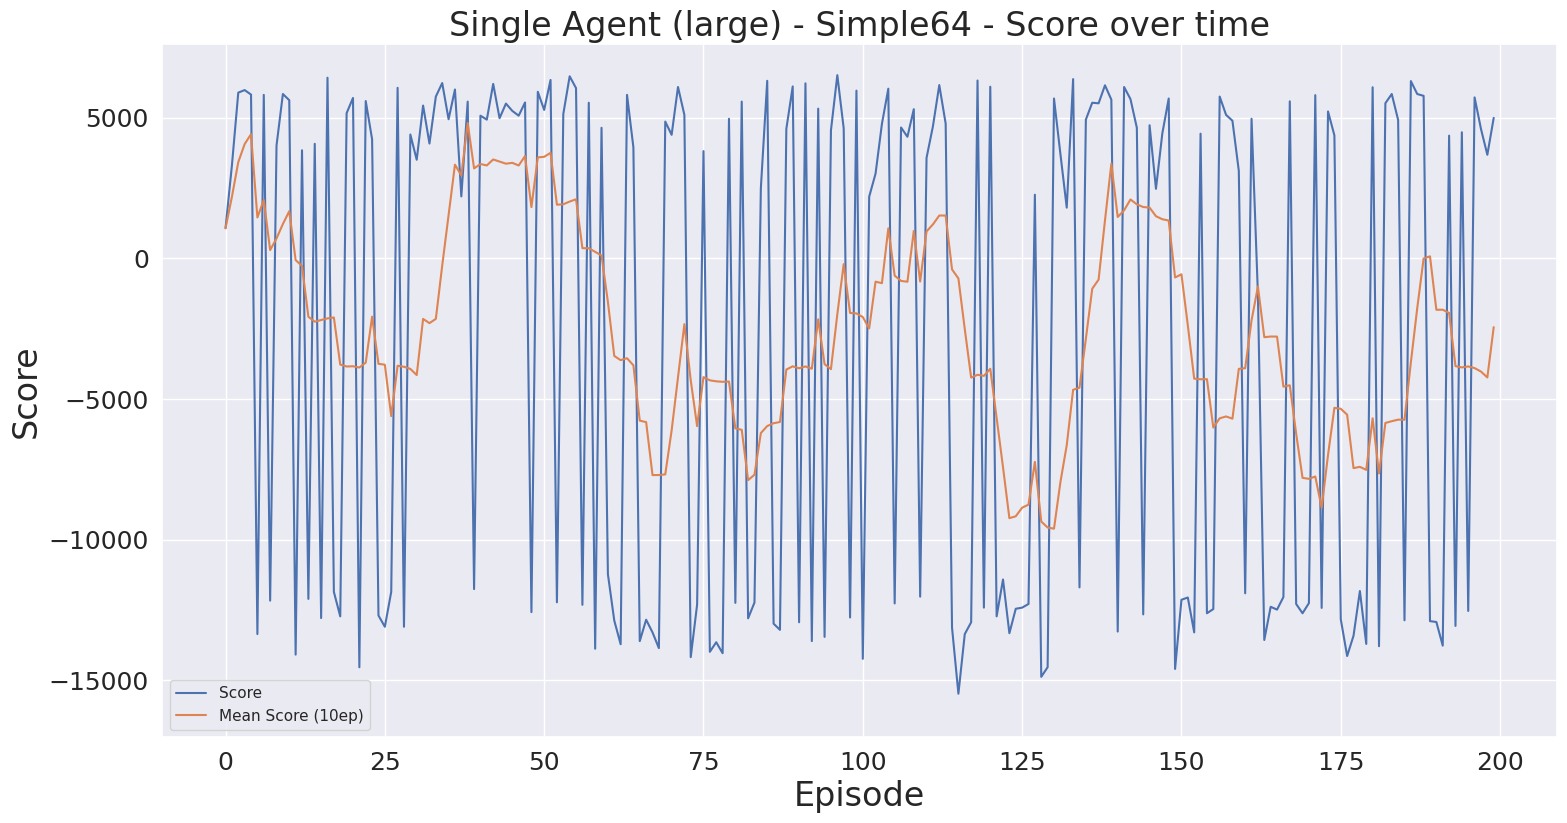

Plotting only TRAINING episodes


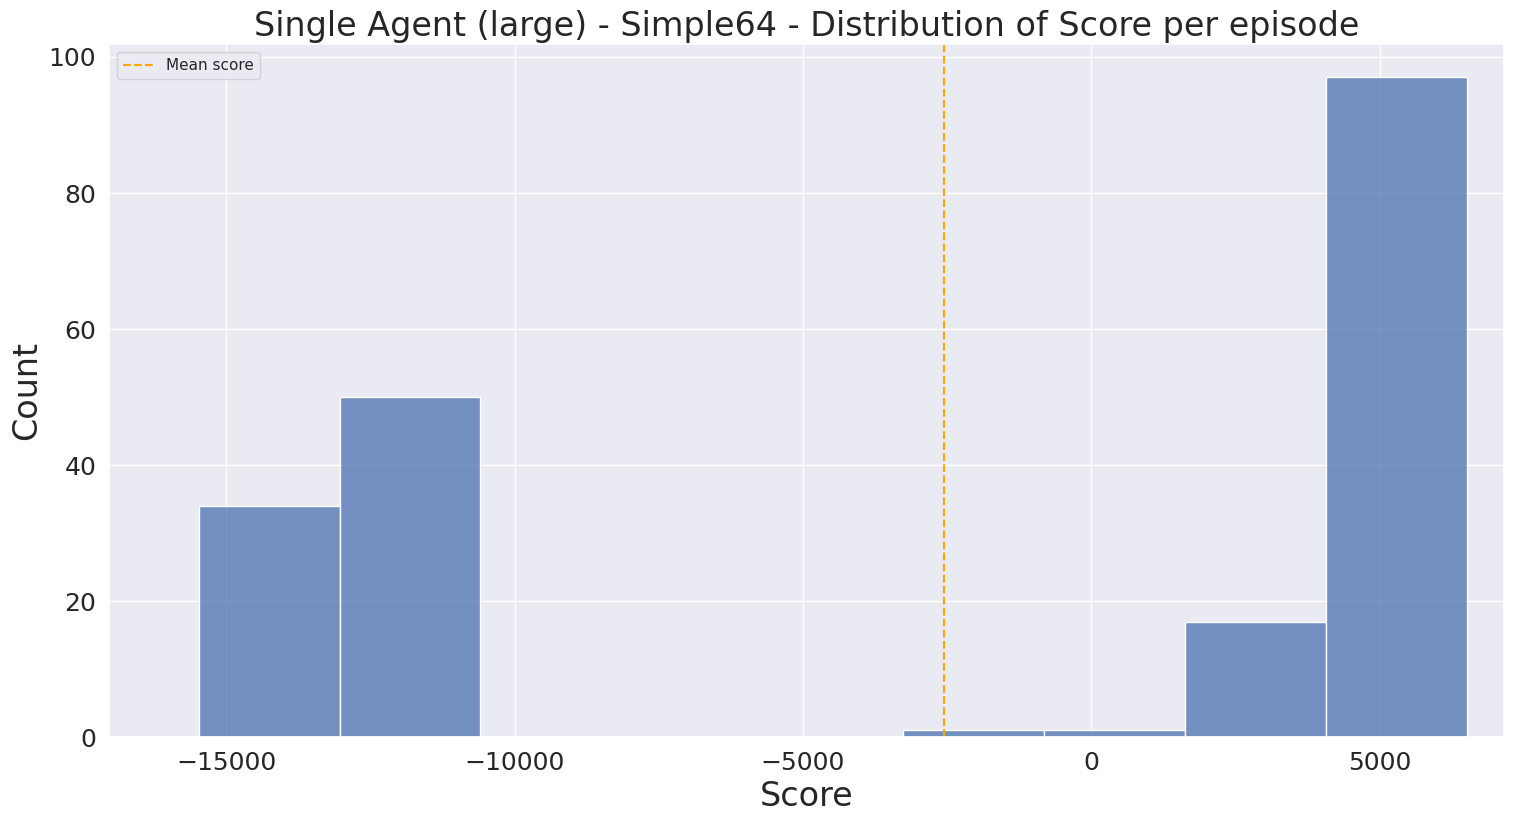

In [19]:
plot_scores(stages=["TRAINING"], **plot_args) ;

Plotting only TRAINING episodes


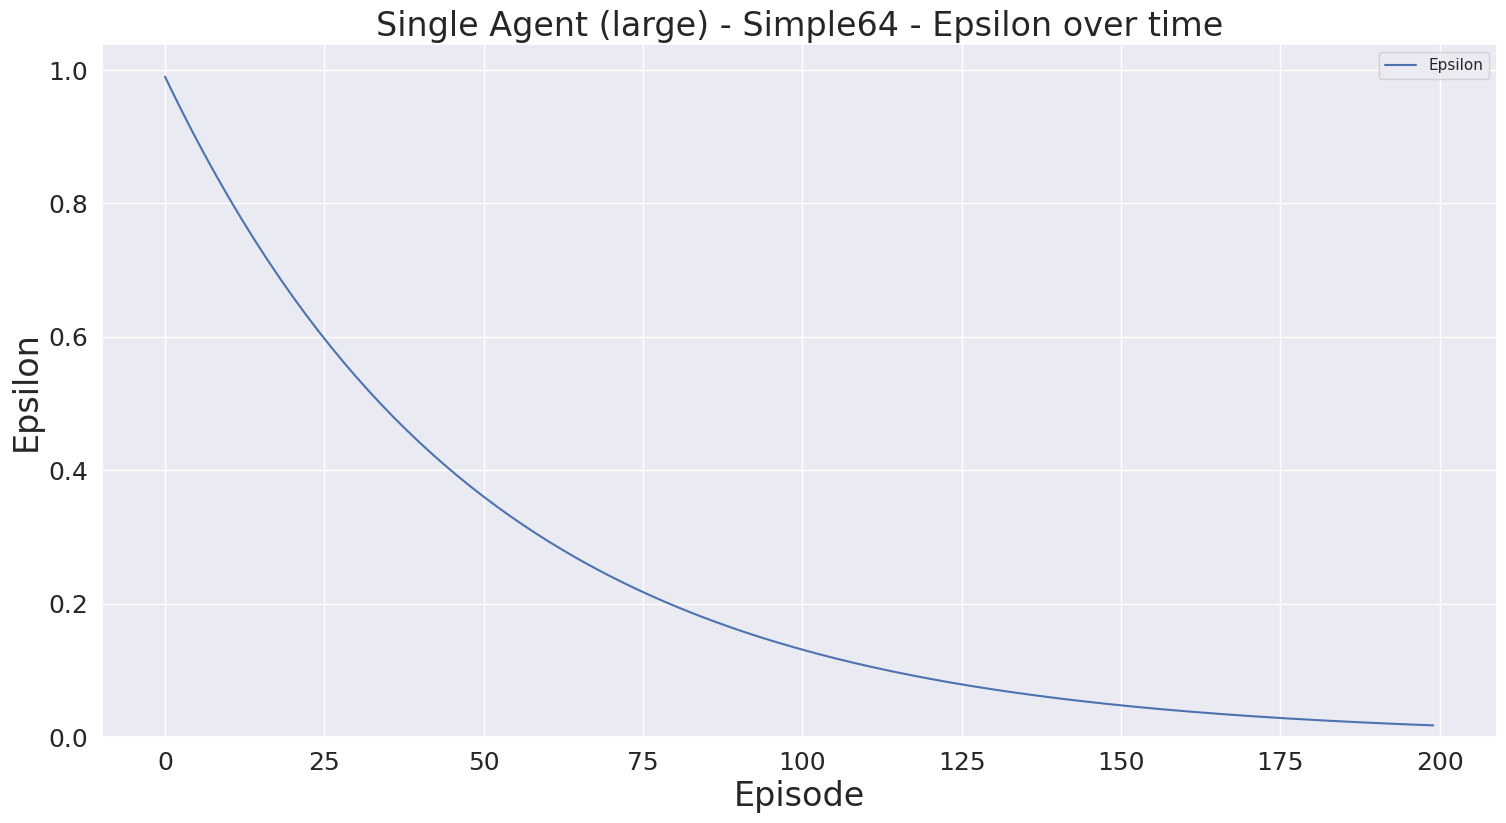

In [20]:
plot_epsilon(**plot_args) ;

In [45]:
training_stats = episode_stats[episode_stats["initial_stage"] == "TRAINING"].copy()
training_stats = add_extra_metrics(training_stats)

In [46]:
training_stats[training_stats["episode"] == 49]

map_name  reward  adjusted_reward  steps   epsilon  \
61  Simple64       1            -29.4    304  0.367886   

                                               losses  emissions   score  \
61  [36.309627532958984, 42.025447845458984, 38.11...   0.028378  5920.0   

    is_burnin  is_training  is_exploit  is_random_mode initial_stage  \
61      False         True       False           False      TRAINING   

   final_stage  episode       loss invalid_action_counts  \
61    TRAINING       49  45.192161          {'dummy': 0}   

                                  valid_action_counts  mean_loss_10ep  \
61  {'ATTACK_ARMY': 5.0, 'ATTACK_BUILDINGS': 18.0,...        43.06006   

    mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
61               0.8                     -34.98           3587.0   

    mean_emissions_10ep  accumulated_emissions  
61             0.028633               1.026363

In [47]:
training_stats[training_stats["episode"] == 49].iloc[0]["valid_action_counts"]

{'ATTACK_ARMY': 5.0,
 'ATTACK_BUILDINGS': 18.0,
 'ATTACK_CLOSEST_ARMY': 10.0,
 'ATTACK_CLOSEST_BUILDING': 33.0,
 'ATTACK_CLOSEST_WORKER': 29.0,
 'ATTACK_WORKERS': 15.0,
 'BUILD_BARRACKS': 4.0,
 'BUILD_COMMAND_CENTER': 2.0,
 'BUILD_SUPPLY_DEPOT': 14,
 'HARVEST_MINERALS': 20,
 'NO_OP': 78,
 'RECRUIT_MARINE': 27.0,
 'RECRUIT_SCV_0': 34,
 'RECRUIT_SCV_1': 11.0,
 'RECRUIT_SCV_2': 5.0}

In [48]:
training_stats[training_stats["episode"] == 49].iloc[0]["invalid_action_counts"]

{'dummy': 0}

In [49]:
training_stats[training_stats["episode"] == 49].iloc[0]["steps"]

304

In [50]:
training_stats[training_stats["episode"] == 49].iloc[0]["valid_action_counts"]

{'ATTACK_ARMY': 5.0,
 'ATTACK_BUILDINGS': 18.0,
 'ATTACK_CLOSEST_ARMY': 10.0,
 'ATTACK_CLOSEST_BUILDING': 33.0,
 'ATTACK_CLOSEST_WORKER': 29.0,
 'ATTACK_WORKERS': 15.0,
 'BUILD_BARRACKS': 4.0,
 'BUILD_COMMAND_CENTER': 2.0,
 'BUILD_SUPPLY_DEPOT': 14,
 'HARVEST_MINERALS': 20,
 'NO_OP': 78,
 'RECRUIT_MARINE': 27.0,
 'RECRUIT_SCV_0': 34,
 'RECRUIT_SCV_1': 11.0,
 'RECRUIT_SCV_2': 5.0}

In [51]:
training_stats[training_stats["episode"] == 60].iloc[0]["invalid_action_counts"]

{'dummy': 0}

In [52]:
training_stats[training_stats["episode"] == 60].iloc[0]["steps"]

229

### Score scheme Exploit

In [9]:
experiment_path = models_path / "best_32"

scenario_name = "Simple64"
model_suffix = f"single_dqn_l_200"
# model_suffix = f"single_dqn_m_130"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Single Agent (large) - {scenario_name}"
# model_name = f"Single Agent (medium) - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 312
Total burnin episodes: 12
Total random mode episodes: 0
Total training episodes: 200
Total exploit episodes: 100
Unique maps in episode stats:  ['Simple64']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps  epsilon losses  emissions  \
307  Simple64       1            -67.0    680      0.0     []        0.0   
308  Simple64      -1            -29.3    283      0.0     []        0.0   
309  Simple64      -1            -34.9    339      0.0     []        0.0   
310  Simple64       1           -132.3   1333      0.0     []        0.0   
311  Simple64       1            -31.7    327      0.0     []        0.0   

            score  is_burnin  is_training  is_exploit  is_random_mode  \
307   2160.000000      False        False        True           False   
308 -11348.333333      False        False        True           False   
309 -12000.000000      False        False        True           False   
310  -4370.000000      False        False        True           False   
311   5304.803922      False        False        True           False   

    initial_stage final_stage  episode  loss invalid_action_counts  \
307       EXPLOIT     EXPLOIT      307   NaN          {'dummy': 0}   
308       EXPLOIT     EXPLOIT      308   NaN          {'dummy': 0}   
309       EXPLOIT     EXPLOIT      309   NaN          {'dummy': 0}   
310       EXPLOIT     EXPLOIT      310   NaN          {'dummy': 0}   
311       EXPLOIT     EXPLOIT      311   NaN          {'dummy': 0}   

                                   valid_action_counts  mean_loss_10ep  \
307  {'ATTACK_ARMY': 4.0, 'ATTACK_BUILDINGS': 13.0,...             NaN   
308  {'ATTACK_ARMY': None, 'ATTACK_BUILDINGS': None...             NaN   
309  {'ATTACK_ARMY': None, 'ATTACK_BUILDINGS': None...             NaN   
310  {'ATTACK_ARMY': None, 'ATTACK_BUILDINGS': 36.0...             NaN   
311  {'ATTACK_ARMY': 19.0, 'ATTACK_BUILDINGS': 38.0...             NaN   

     mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
307               0.2                     -43.95     -2739.083333   
308               0.2                     -41.94     -2495.916667   
309               0.2                     -40.57     -2330.916667   
310               0.4                     -49.81     -1499.916667   
311               0.4                     -49.88     -1545.436275   

     mean_emissions_10ep  accumulated_emissions  
307                  0.0              14.071044  
308                  0.0              14.071044  
309                  0.0              14.071044  
310                  0.0              14.071044  
311                  0.0              14.071044

In [54]:
value_counts = episode_stats[episode_stats["initial_stage"] == "EXPLOIT"]["reward"].value_counts()
total_lost = value_counts[-1] if -1 in value_counts else 0
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1] if 1 in value_counts else 0
total_games = total_won + total_lost + total_ties
pct_victories = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

Win rate: 13.00%
Tie rate: 8.00%
Lose rate: 79.00%


Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


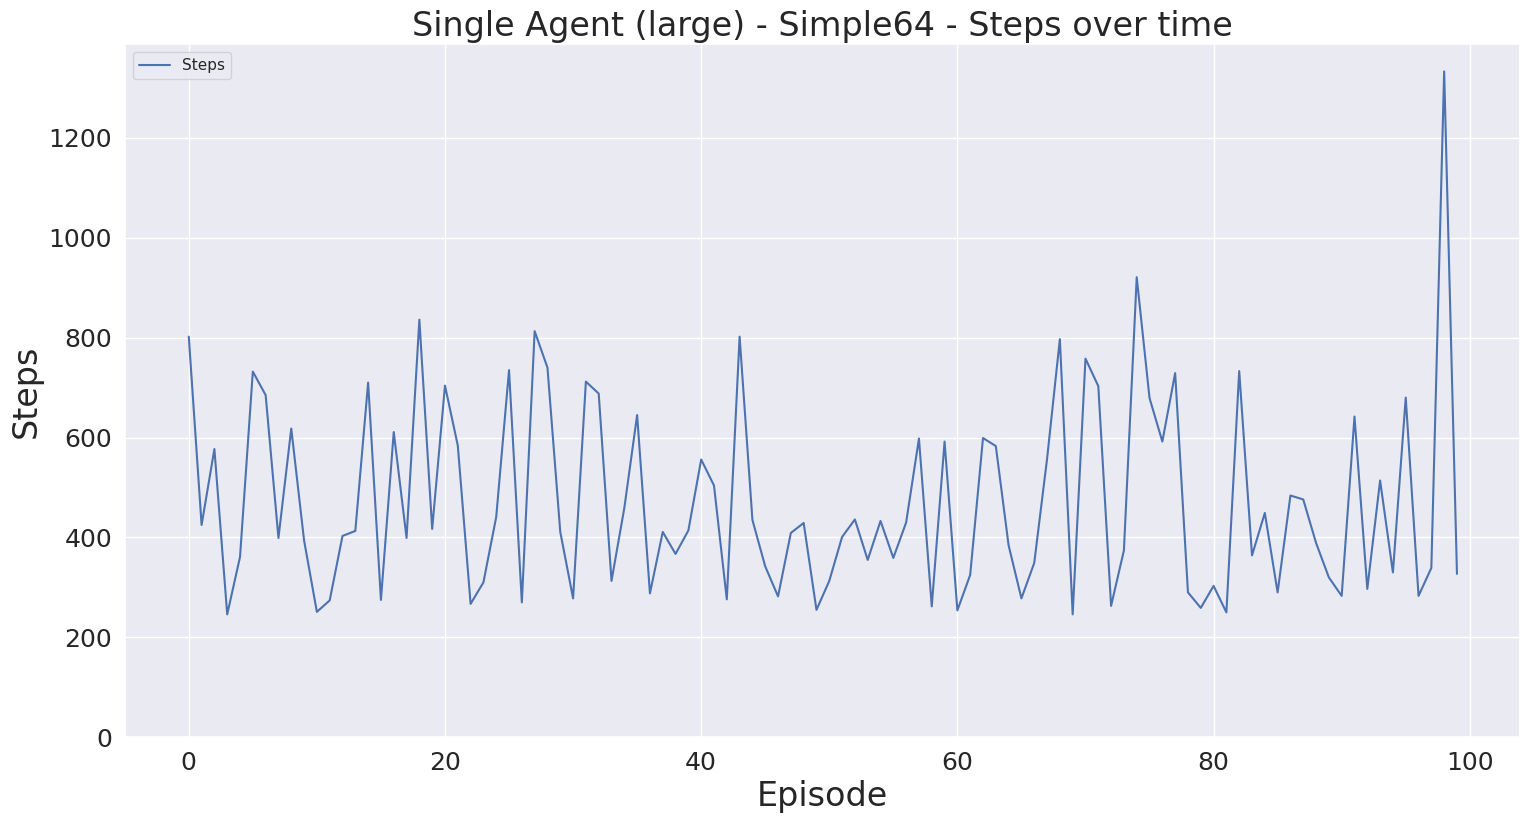

In [10]:
plot_steps_over_time(stages=["EXPLOIT"], **plot_args) ;

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_239520/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


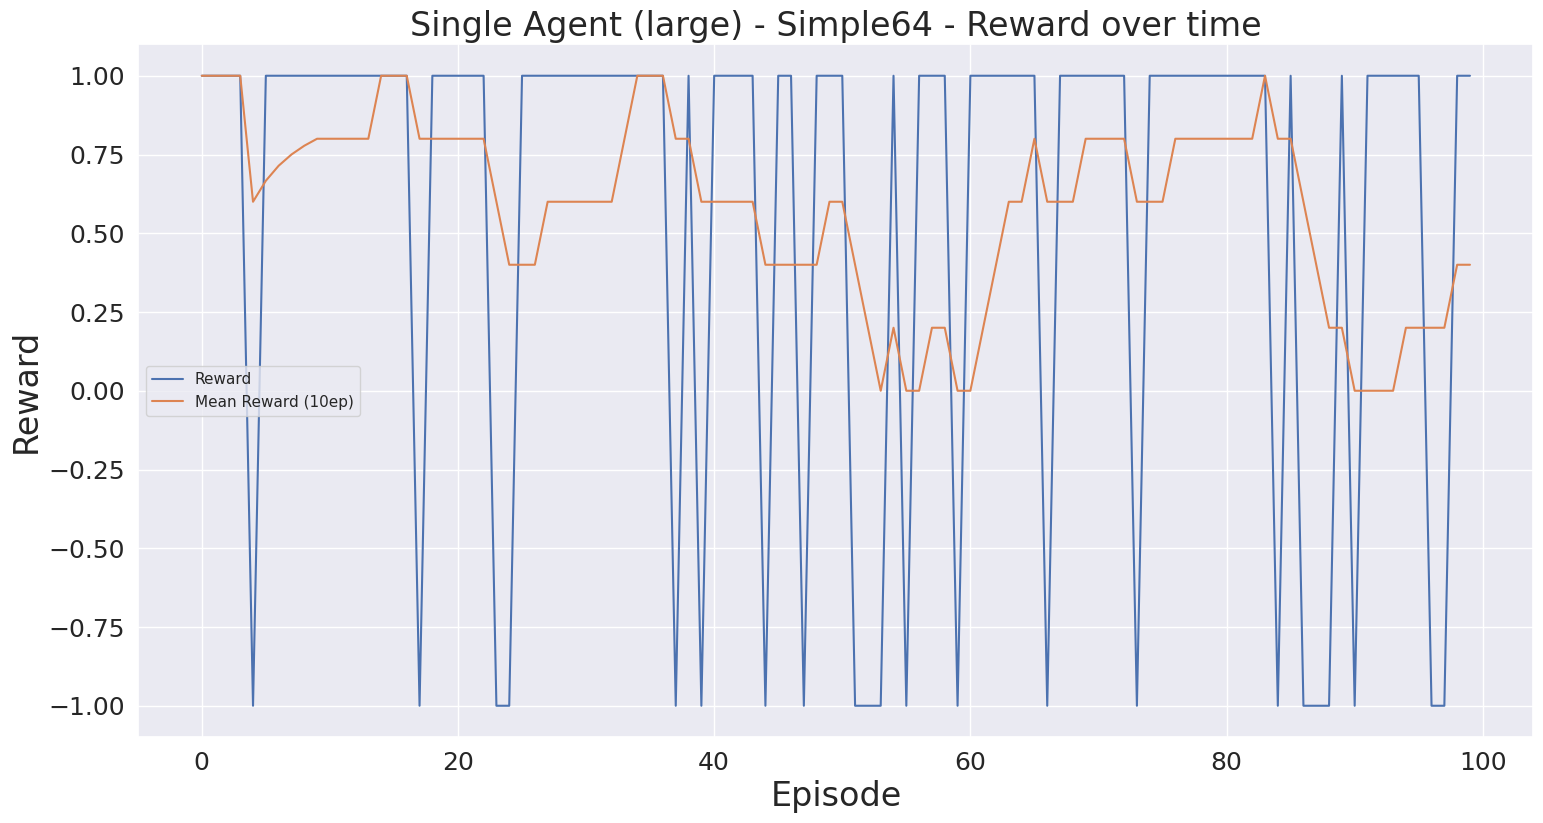

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


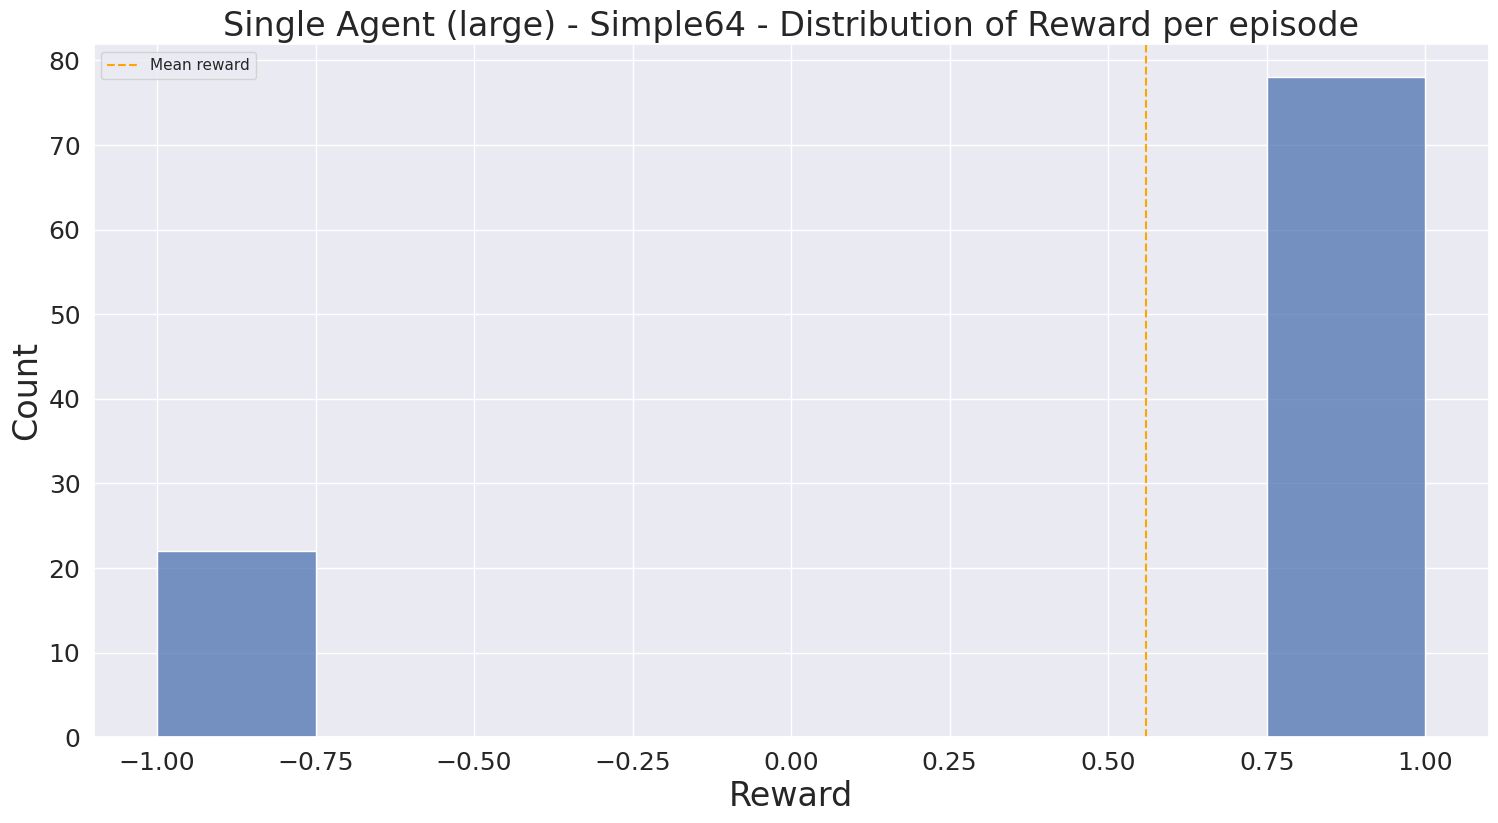

In [11]:
plot_rewards(stages=["EXPLOIT"], **plot_args) ;

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_239520/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


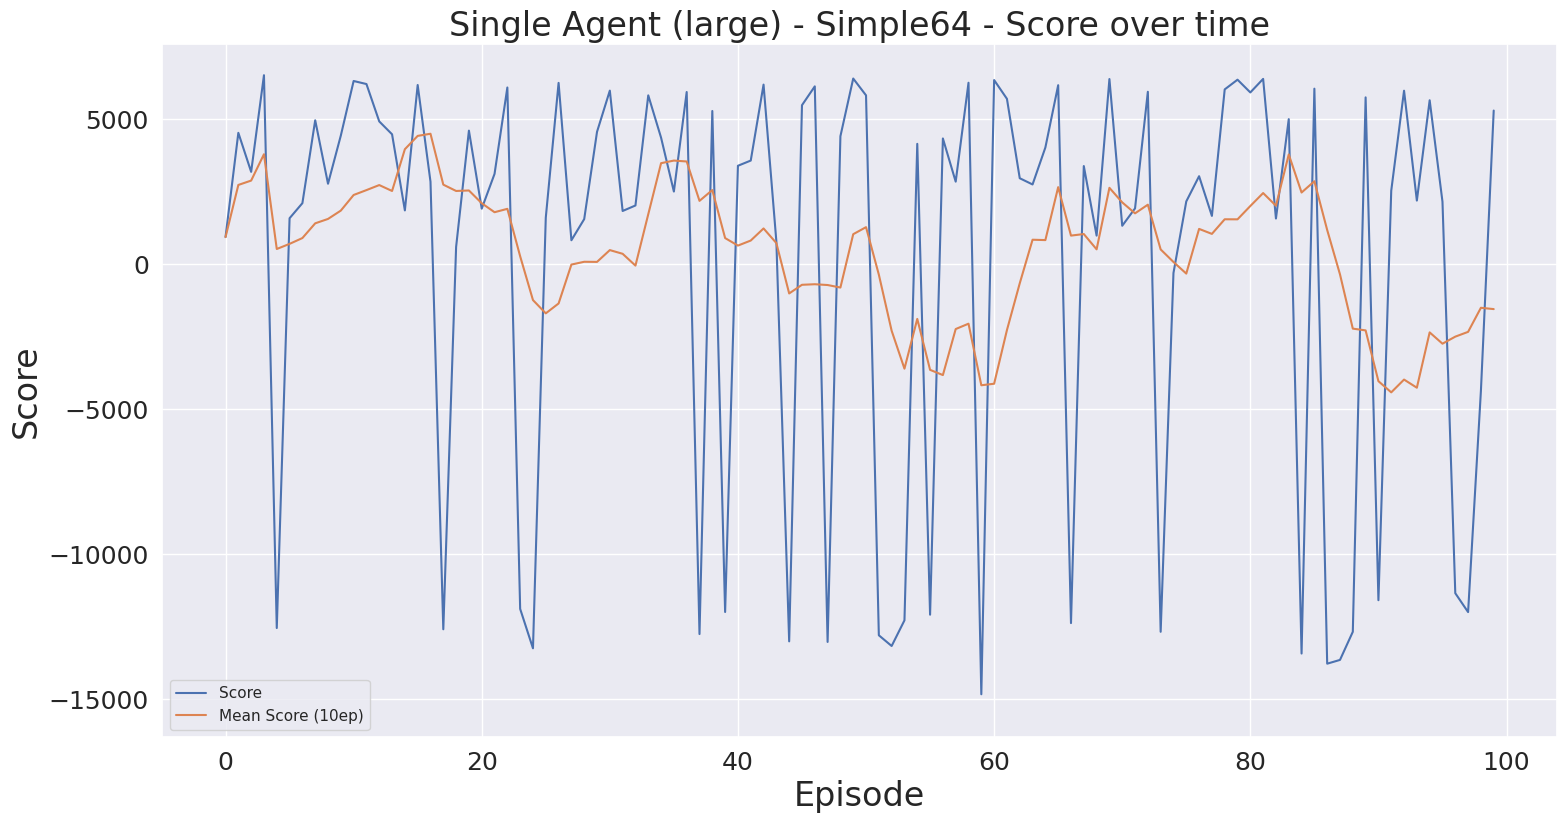

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


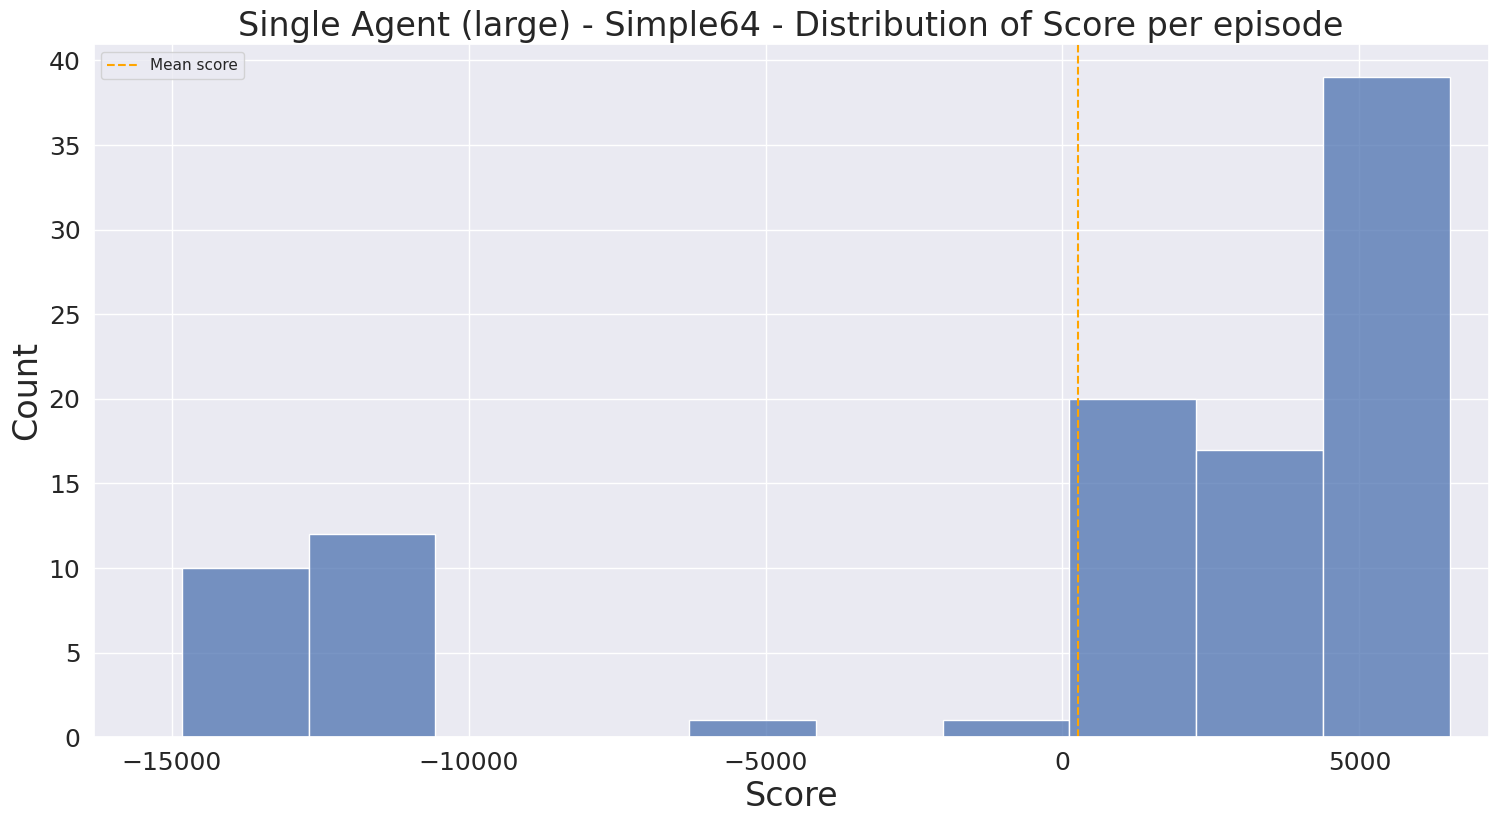

In [12]:
plot_scores(stages=["EXPLOIT"], **plot_args) ;

# Feudal DQN Agent

## Template

In [58]:
model_id = "base_manager"
scenario_name = "CollectMinerals"
reward_scheme = "reward"
reward_scheme_name = "Default"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}"
# model_path = models_path / model_suffix
print(model_path)
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"DQN Agent - {scenario_name} - {reward_scheme_name} rewards"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_suffix, model_path=models_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

/mnt/c/Users/david/Master Data Science/Semestre 5 (Sep 2024 - Ene 2025)/TFM/Proyecto/tfm-rl-starcraft2/models/best_32/single_dqn_m_130/exploit


TypeError: load_stats() got multiple values for argument 'model_name'

In [ ]:
plot_emissions(emission_stats, save_images_path, model_name) ;
plot_losses(**plot_args) ;
plot_rewards(**plot_args) ;
plot_scores(**plot_args) ;
plot_epsilon(**plot_args) ;

print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args) ;

## Base Manager

### Random baseline

In [59]:
experiment_path = models_path / "RandomBaseline"

scenario_name = "SaturateHarvesters"
model_suffix = f"multi_random_base_manager"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Base Manager - {scenario_name} - Random baseline"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

Total episodes: 100
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 0
Total exploit episodes: 100
Unique maps in episode stats:  ['SaturateHarvesters']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


map_name  reward  adjusted_reward  steps  epsilon losses  \
0  SaturateHarvesters    2015           1979.0    360      1.0     []   
1  SaturateHarvesters    2015           1979.0    360      1.0     []   
2  SaturateHarvesters    2127           2091.0    360      1.0     []   
3  SaturateHarvesters    2127           2091.0    360      1.0     []   
4  SaturateHarvesters    2015           1979.0    360      1.0     []   

   emissions  score  is_burnin  is_training  is_exploit  is_random_mode  \
0        0.0    7.2      False        False        True           False   
1        0.0    7.2      False        False        True           False   
2        0.0    9.2      False        False        True           False   
3        0.0    9.2      False        False        True           False   
4        0.0    7.2      False        False        True           False   

  initial_stage final_stage  episode  loss invalid_action_counts  \
0       EXPLOIT     EXPLOIT        0   NaN          {'dummy': 0}   
1       EXPLOIT     EXPLOIT        1   NaN          {'dummy': 0}   
2       EXPLOIT     EXPLOIT        2   NaN          {'dummy': 0}   
3       EXPLOIT     EXPLOIT        3   NaN          {'dummy': 0}   
4       EXPLOIT     EXPLOIT        4   NaN          {'dummy': 0}   

                                 valid_action_counts  mean_loss_10ep  \
0  {'BUILD_COMMAND_CENTER': 2, 'BUILD_SUPPLY_DEPO...             NaN   
1  {'BUILD_COMMAND_CENTER': 2, 'BUILD_SUPPLY_DEPO...             NaN   
2  {'BUILD_COMMAND_CENTER': 2, 'BUILD_SUPPLY_DEPO...             NaN   
3  {'BUILD_COMMAND_CENTER': 2, 'BUILD_SUPPLY_DEPO...             NaN   
4  {'BUILD_COMMAND_CENTER': 2, 'BUILD_SUPPLY_DEPO...             NaN   

   mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
0       2015.000000                1979.000000         7.200000   
1       2015.000000                1979.000000         7.200000   
2       2052.333333                2016.333333         7.866667   
3       2071.000000                2035.000000         8.200000   
4       2059.800000                2023.800000         8.000000   

   mean_emissions_10ep  accumulated_emissions  
0                  0.0                    0.0  
1                  0.0                    0.0  
2                  0.0                    0.0  
3                  0.0                    0.0  
4                  0.0                    0.0

In [60]:
episode_stats[["initial_stage", "reward"]].groupby("initial_stage").mean()

reward
initial_stage         
EXPLOIT        2026.48

/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


Plotting only EXPLOIT episodes


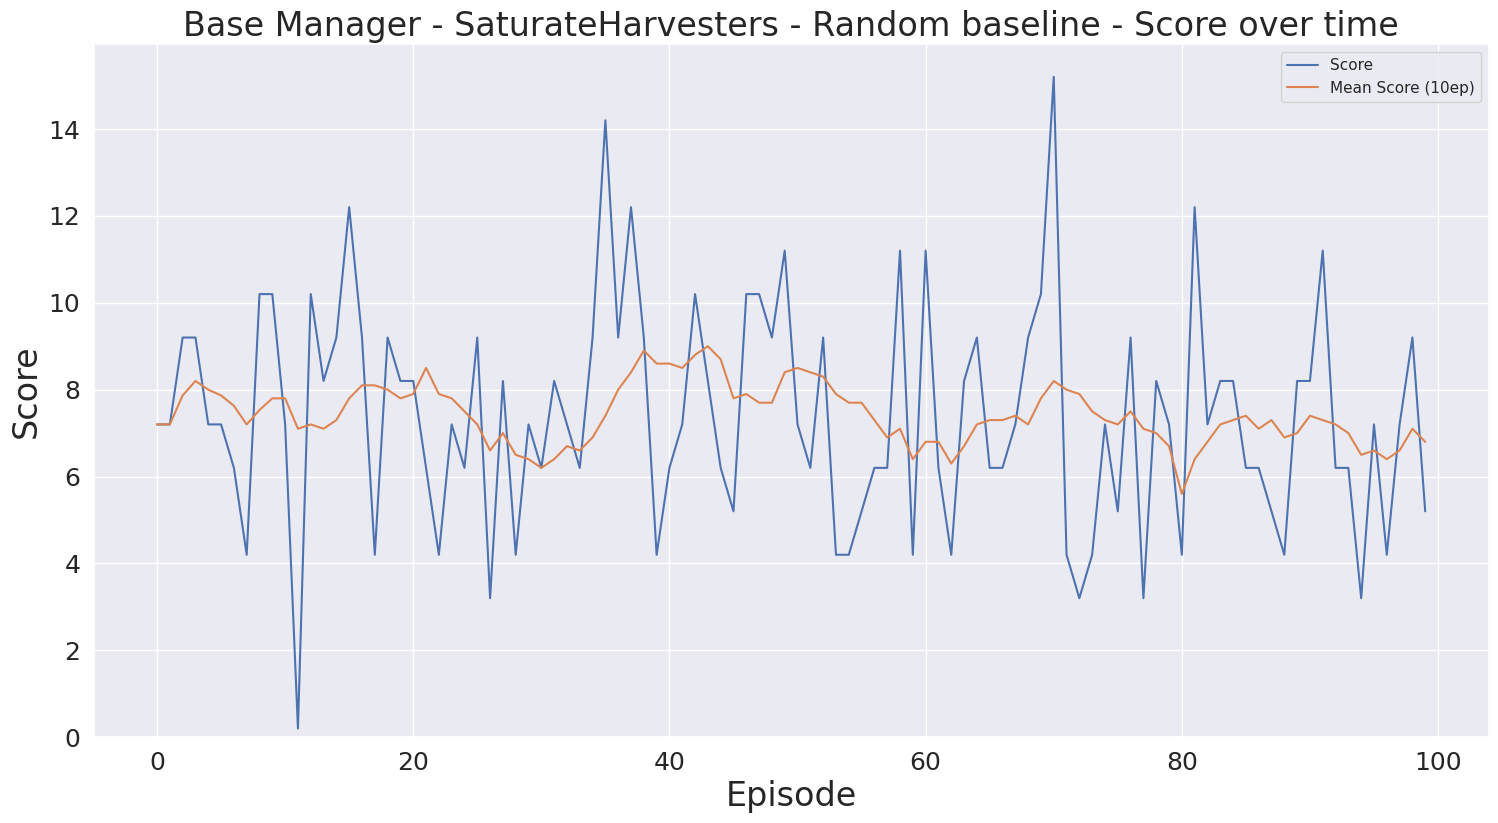

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


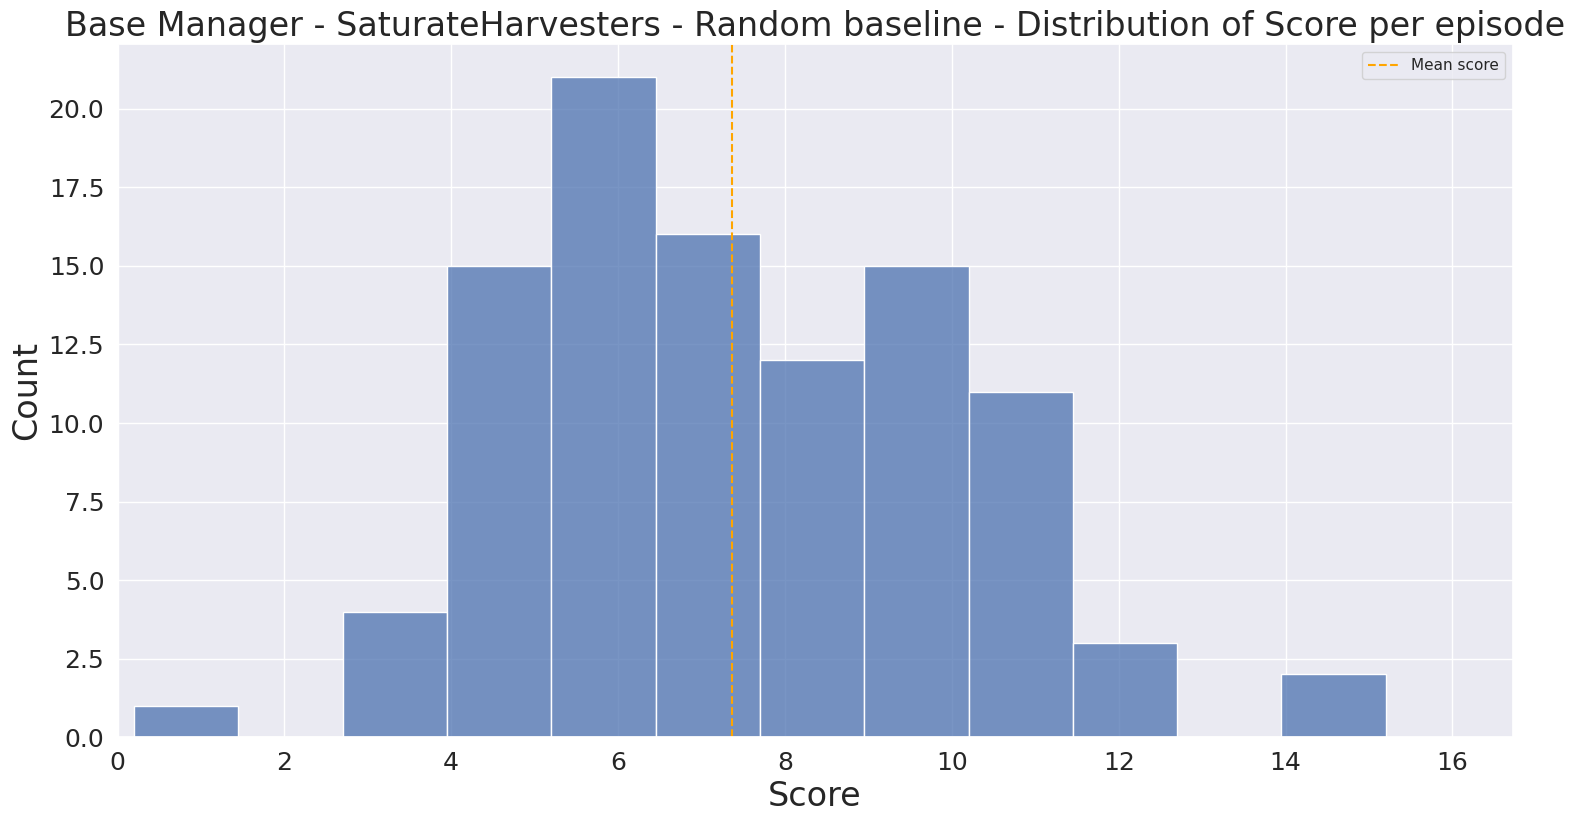

In [61]:
plot_scores(stages=["EXPLOIT"],**plot_args) ;

### Score reward scheme Training

In [62]:
experiment_path = models_path / "best_32"

scenario_name = "SaturateHarvesters"
model_suffix = f"multi_dqn_base_manager"
model_path = experiment_path / model_suffix
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Base Manager"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 59
Total burnin episodes: 9
Total random mode episodes: 0
Total training episodes: 50
Total exploit episodes: 0
Unique maps in episode stats:  ['SaturateHarvesters']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps  epsilon  \
54  SaturateHarvesters    2071           2035.0    360     0.02   
55  SaturateHarvesters    2463           2427.0    360     0.02   
56  SaturateHarvesters    3079           3043.0    360     0.02   
57  SaturateHarvesters    1147           1111.0    360     0.02   
58  SaturateHarvesters    2687           2651.0    360     0.02   

                                               losses  emissions  score  \
54  [0.09745536744594574, 0.10219652950763702, 0.0...   0.012797    7.2   
55  [0.13315458595752716, 0.08276864141225815, 0.0...   0.013062   14.2   
56  [0.09976274520158768, 0.11610715091228485, 0.0...   0.016693   24.2   
57  [0.11316099762916565, 0.1431213766336441, 0.11...   0.013614   -7.8   
58  [0.0759289488196373, 0.10119523108005524, 0.07...   0.017336   17.2   

    is_burnin  is_training  is_exploit  is_random_mode initial_stage  \
54      False         True       False           False      TRAINING   
55      False         True       False           False      TRAINING   
56      False         True       False           False      TRAINING   
57      False         True       False           False      TRAINING   
58      False         True       False           False      TRAINING   

   final_stage  episode      loss invalid_action_counts  \
54    TRAINING       54  0.098363          {'dummy': 0}   
55    TRAINING       55  0.096256          {'dummy': 0}   
56    TRAINING       56  0.099232          {'dummy': 0}   
57    TRAINING       57  0.103849          {'dummy': 0}   
58    TRAINING       58  0.100993          {'dummy': 0}   

                                  valid_action_counts  mean_loss_10ep  \
54  {'BUILD_COMMAND_CENTER': 1.0, 'BUILD_SUPPLY_DE...        0.088645   
55  {'BUILD_COMMAND_CENTER': 2.0, 'BUILD_SUPPLY_DE...        0.090183   
56  {'BUILD_COMMAND_CENTER': 2.0, 'BUILD_SUPPLY_DE...        0.092251   
57  {'BUILD_COMMAND_CENTER': 2.0, 'BUILD_SUPPLY_DE...        0.094556   
58  {'BUILD_COMMAND_CENTER': 2.0, 'BUILD_SUPPLY_DE...        0.096252   

    mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
54            2241.8                     2205.8            10.90   
55            2373.4                     2337.4            13.20   
56            2493.8                     2457.8            15.20   
57            2395.8                     2359.8            13.40   
58            2440.6                     2404.6            14.05   

    mean_emissions_10ep  accumulated_emissions  
54             0.013092               0.349442  
55             0.013354               0.362505  
56             0.013956               0.379197  
57             0.014224               0.392811  
58             0.014557               0.410147

In [63]:
episode_stats[["initial_stage", "reward"]].groupby("initial_stage").mean()

reward
initial_stage             
BURN_IN        2083.444444
TRAINING       2595.720000

In [64]:
emission_stats.iloc[-1]

timestamp                                           2024-12-11 11:41:21
project_name                                                 codecarbon
run_id                             cf2eced1-d593-45d0-88b5-02e3e49901d2
duration                                                    2102.448563
emissions                                                      0.003492
emissions_rate                                                 0.000002
cpu_power                                                          32.5
gpu_power                                                           0.0
ram_power                                                      2.888793
cpu_energy                                                      0.01898
gpu_energy                                                            0
ram_energy                                                     0.001687
energy_consumed                                                0.020667
country_name                                                    

In [65]:
episode_stats.initial_stage.unique()

array(['BURN_IN', 'TRAINING'], dtype=object)

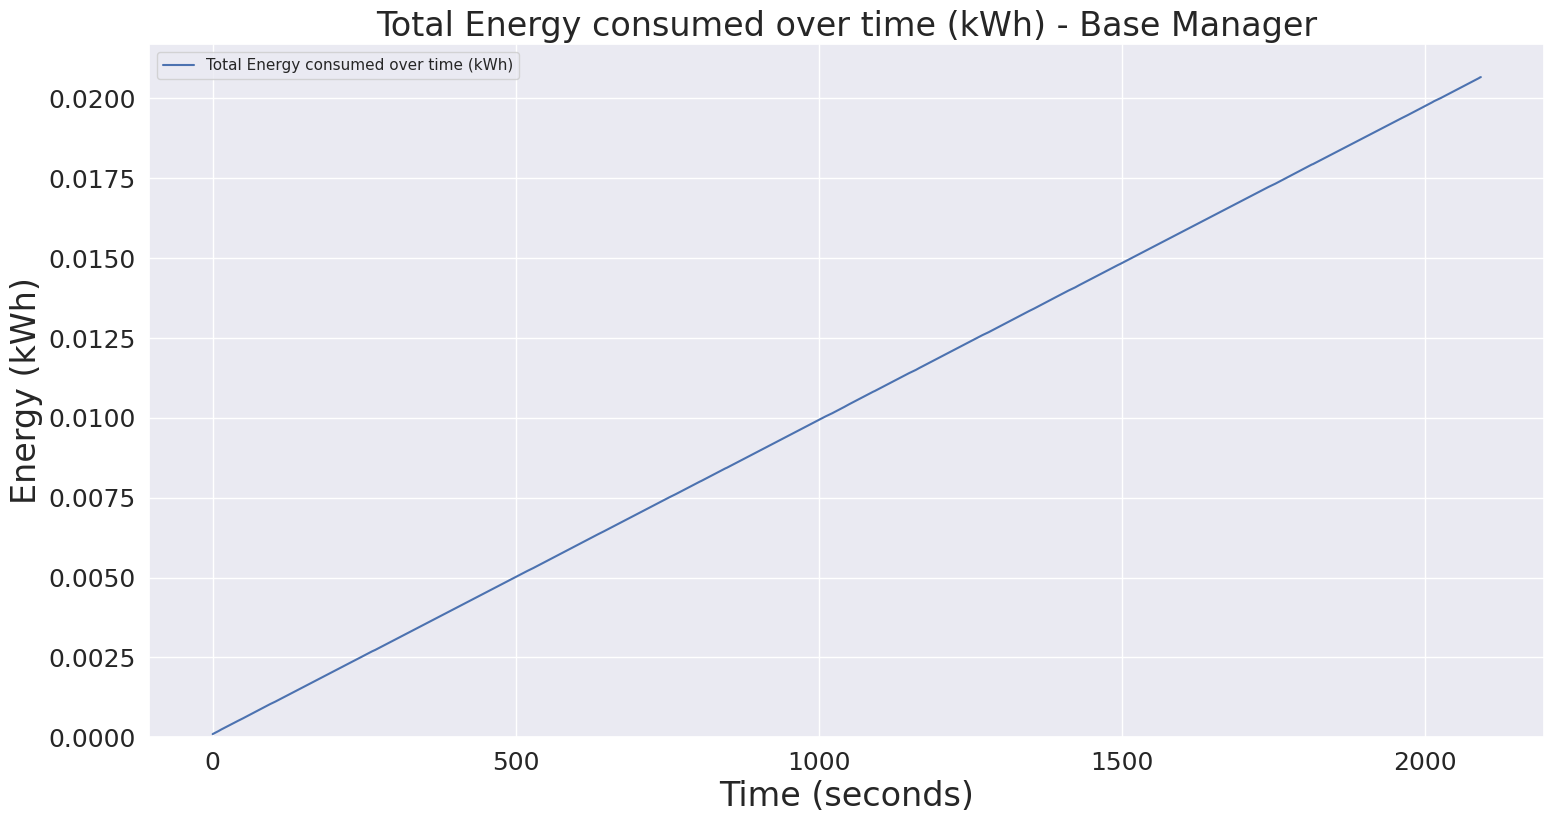

In [66]:
plot_emissions(emission_stats, save_images_path, model_name) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


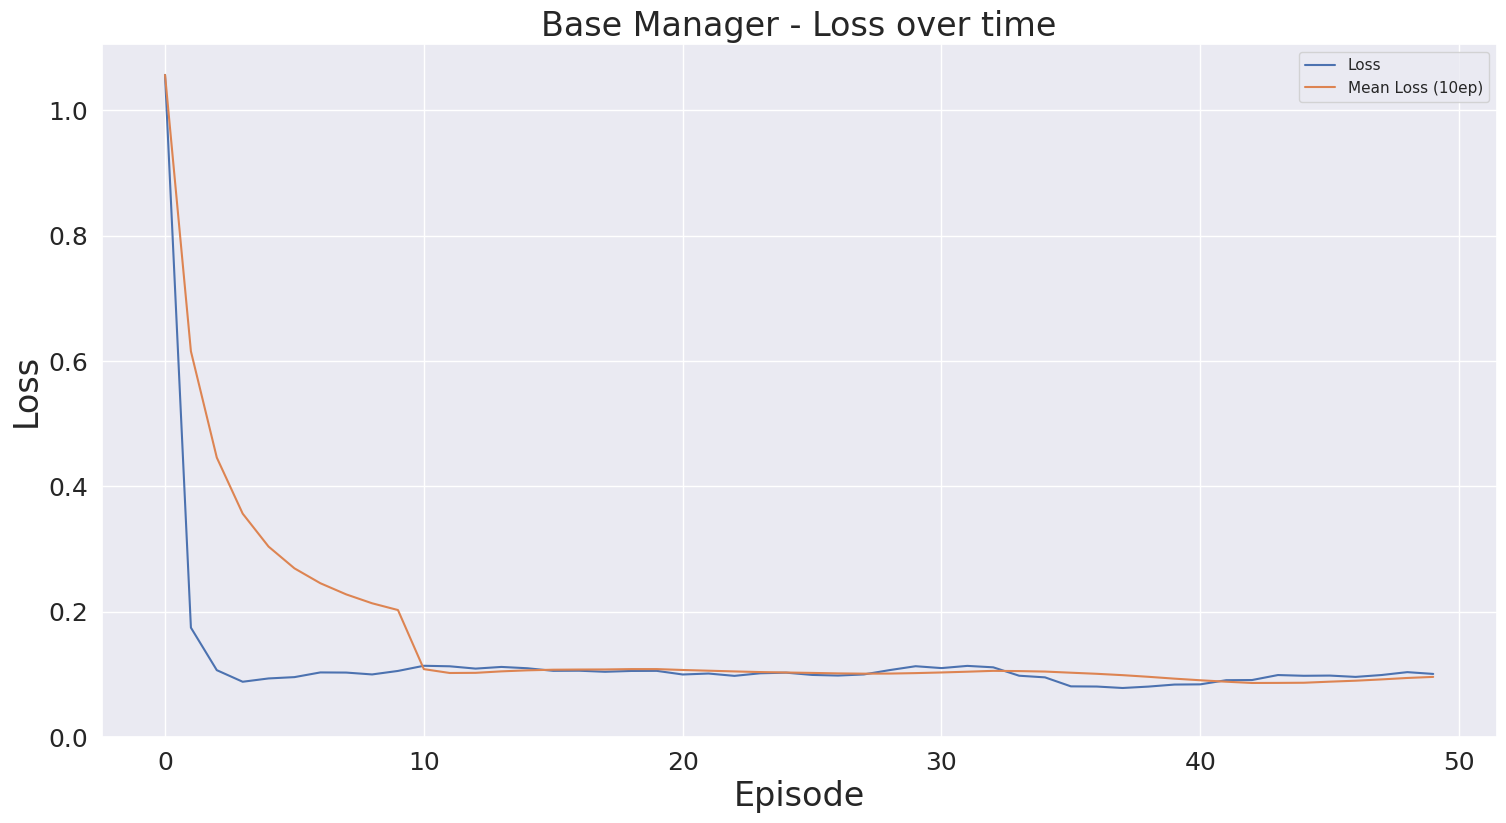

Plotting only TRAINING episodes


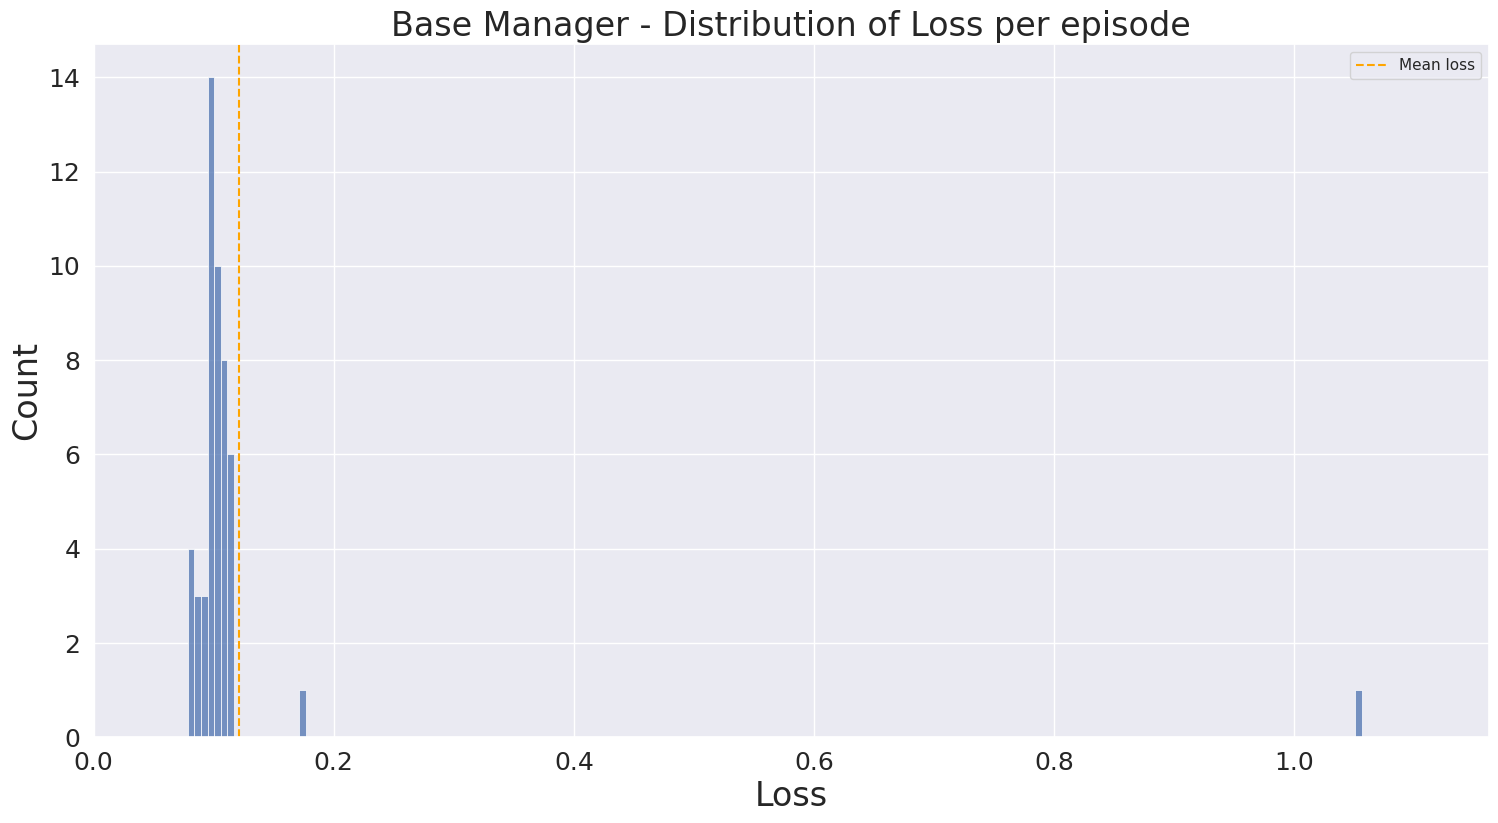

In [67]:
plot_losses(stages=["TRAINING"],**plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


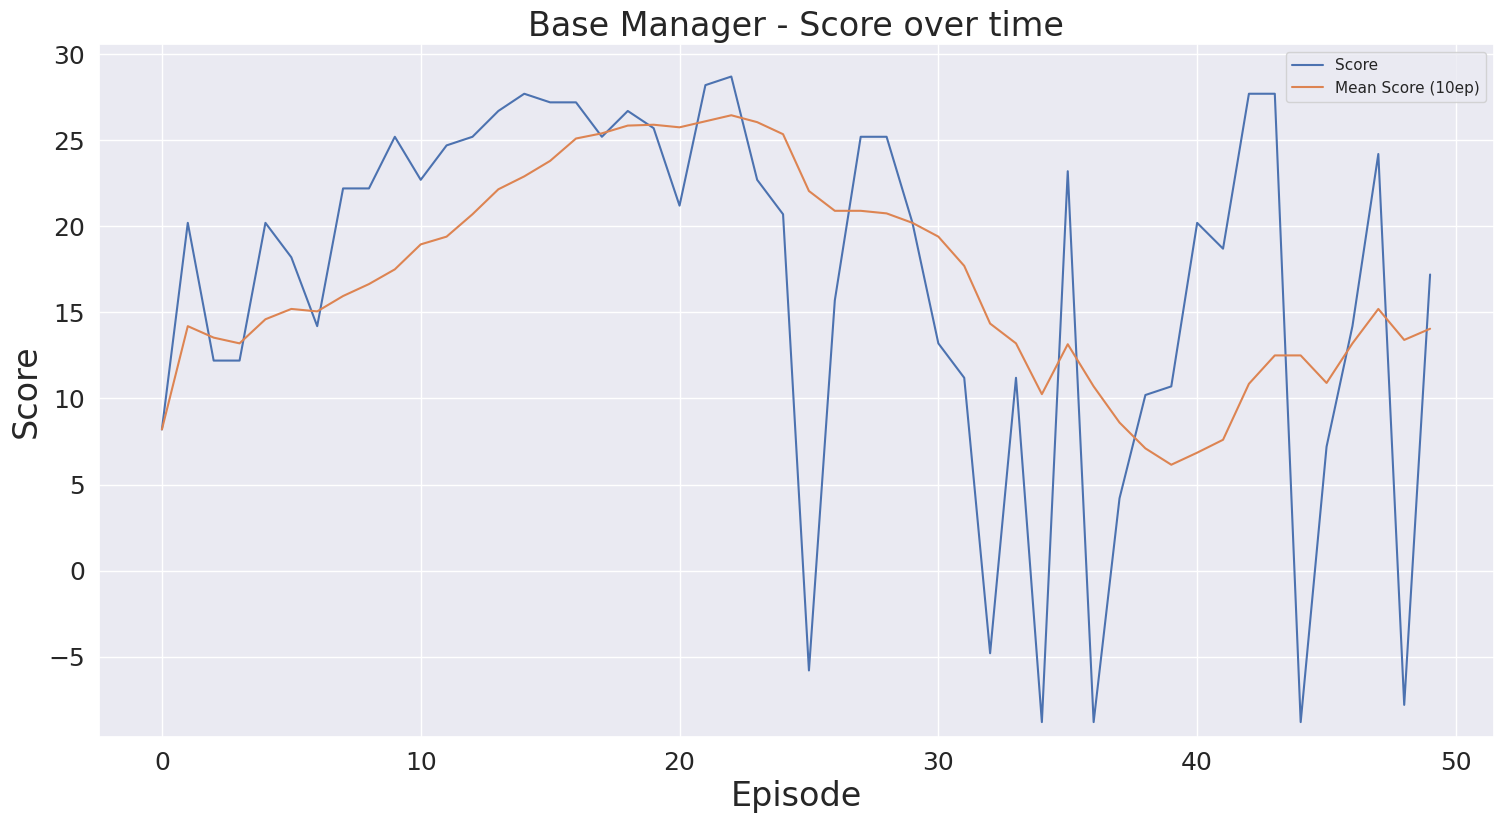

Plotting only TRAINING episodes


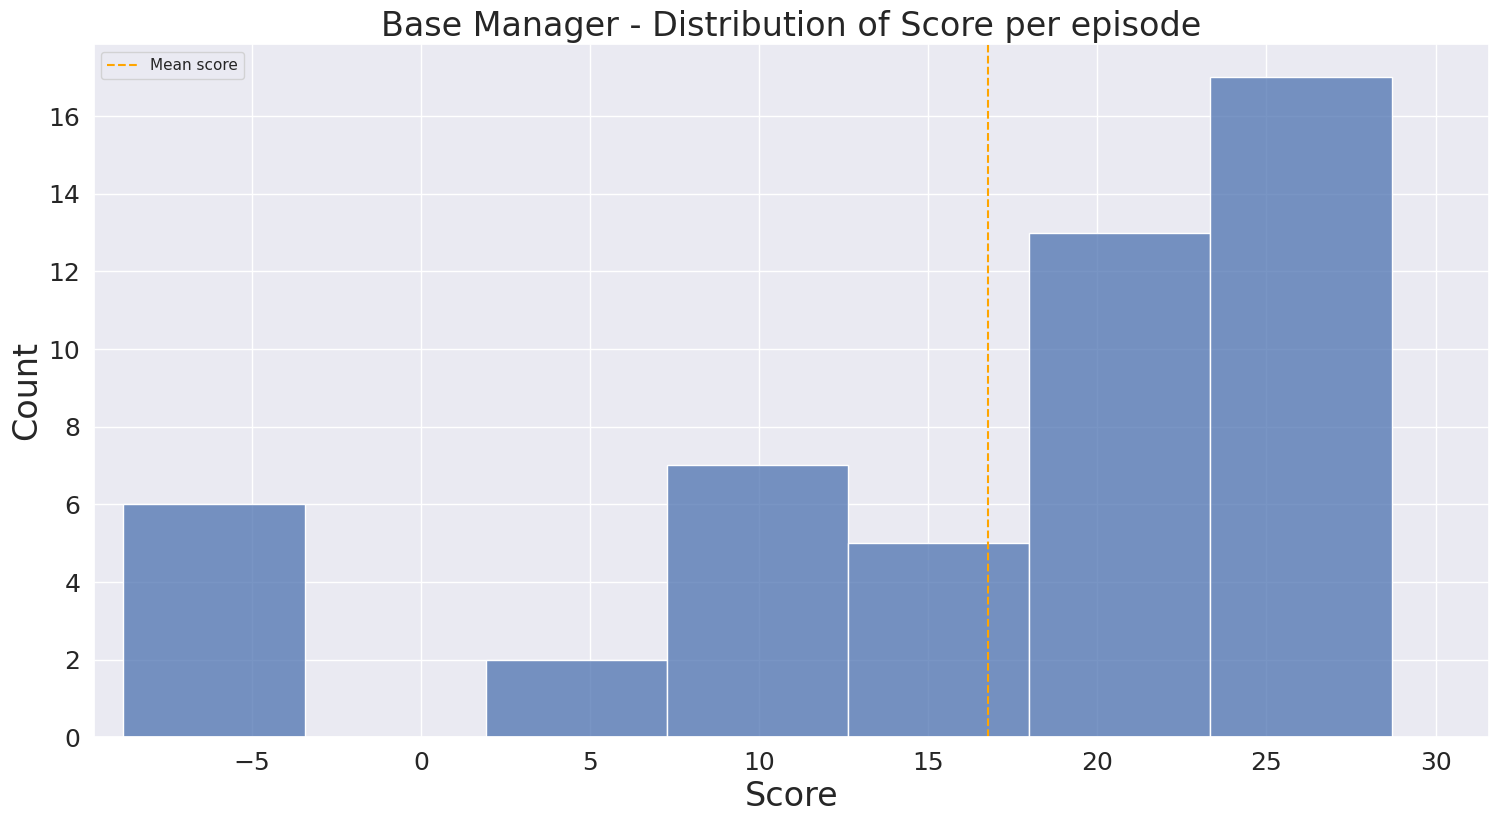

In [68]:
plot_scores(stages=["TRAINING"],**plot_args) ;

Plotting only TRAINING episodes


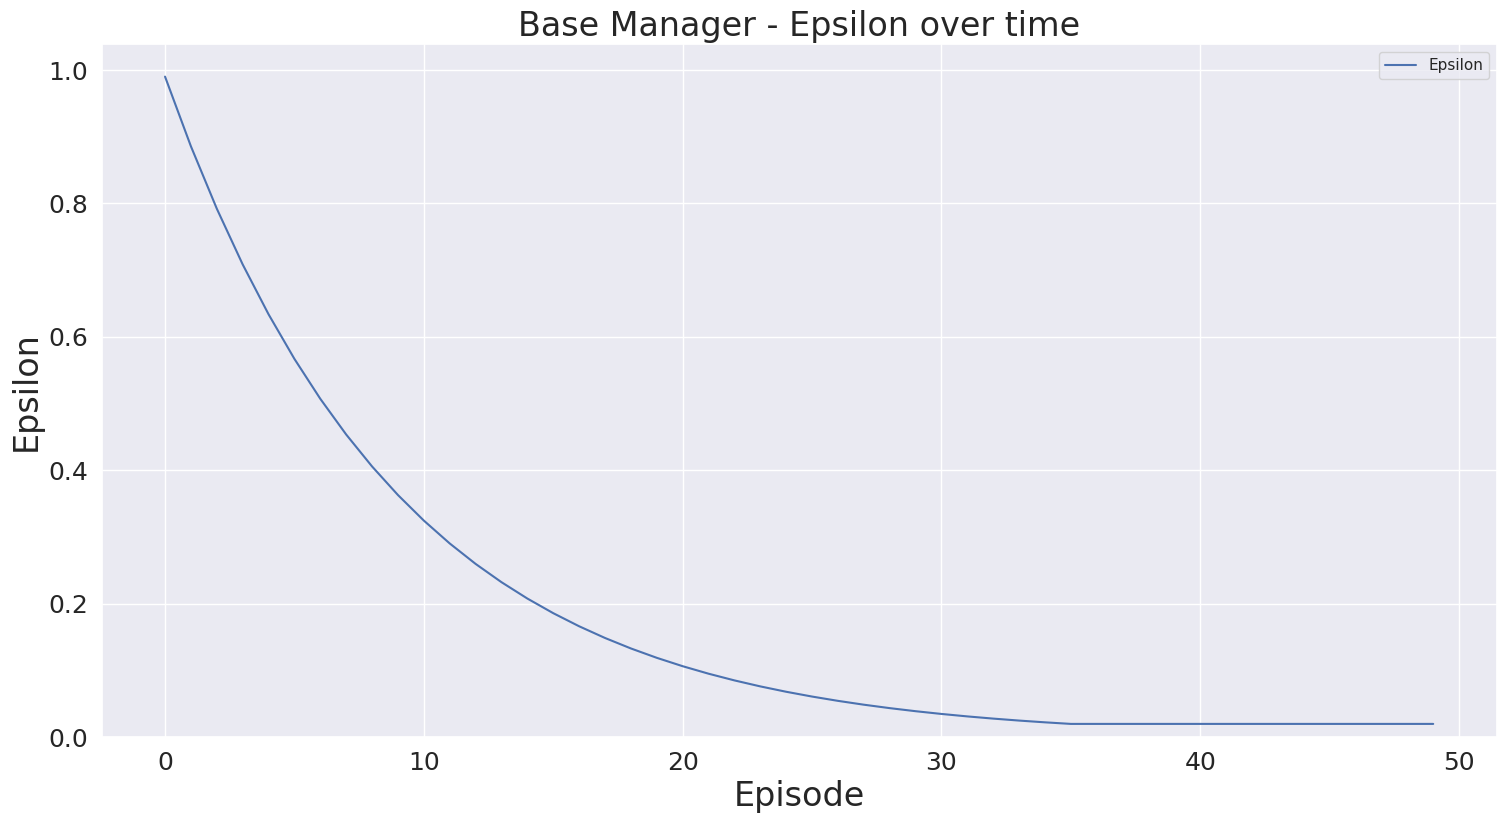

In [69]:
plot_epsilon(**plot_args) ;

### Score reward scheme Exploit

In [70]:
experiment_path = models_path / "best_32"

scenario_name = "SaturateHarvesters"
model_suffix = f"multi_dqn_base_manager"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Base Manager"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 159
Total burnin episodes: 9
Total random mode episodes: 0
Total training episodes: 50
Total exploit episodes: 100
Unique maps in episode stats:  ['SaturateHarvesters']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps  epsilon losses  \
154  SaturateHarvesters    3331           3295.0    360      0.0     []   
155  SaturateHarvesters    3051           3015.0    360      0.0     []   
156  SaturateHarvesters    3135           3099.0    360      0.0     []   
157  SaturateHarvesters    3303           3267.0    360      0.0     []   
158  SaturateHarvesters    2883           2847.0    360      0.0     []   

     emissions  score  is_burnin  is_training  is_exploit  is_random_mode  \
154        0.0   27.2      False        False        True           False   
155        0.0   23.7      False        False        True           False   
156        0.0   25.2      False        False        True           False   
157        0.0   26.2      False        False        True           False   
158        0.0   20.2      False        False        True           False   

    initial_stage final_stage  episode  loss invalid_action_counts  \
154       EXPLOIT     EXPLOIT      154   NaN          {'dummy': 0}   
155       EXPLOIT     EXPLOIT      155   NaN          {'dummy': 0}   
156       EXPLOIT     EXPLOIT      156   NaN          {'dummy': 0}   
157       EXPLOIT     EXPLOIT      157   NaN          {'dummy': 0}   
158       EXPLOIT     EXPLOIT      158   NaN          {'dummy': 0}   

                                   valid_action_counts  mean_loss_10ep  \
154  {'BUILD_COMMAND_CENTER': 2.0, 'BUILD_SUPPLY_DE...             NaN   
155  {'BUILD_COMMAND_CENTER': 4.0, 'BUILD_SUPPLY_DE...             NaN   
156  {'BUILD_COMMAND_CENTER': 2.0, 'BUILD_SUPPLY_DE...             NaN   
157  {'BUILD_COMMAND_CENTER': 2.0, 'BUILD_SUPPLY_DE...             NaN   
158  {'BUILD_COMMAND_CENTER': 2.0, 'BUILD_SUPPLY_DE...             NaN   

     mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
154            3157.4                     3121.4            25.65   
155            3160.2                     3124.2            25.75   
156            3163.0                     3127.0            25.85   
157            3177.0                     3141.0            26.05   
158            3151.8                     3115.8            25.45   

     mean_emissions_10ep  accumulated_emissions  
154                  0.0               0.410147  
155                  0.0               0.410147  
156                  0.0               0.410147  
157                  0.0               0.410147  
158                  0.0               0.410147

In [71]:
episode_stats[["initial_stage", "reward"]].groupby("initial_stage").mean()

reward
initial_stage             
BURN_IN        2083.444444
EXPLOIT        3152.080000
TRAINING       2595.720000

/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


Plotting only EXPLOIT episodes


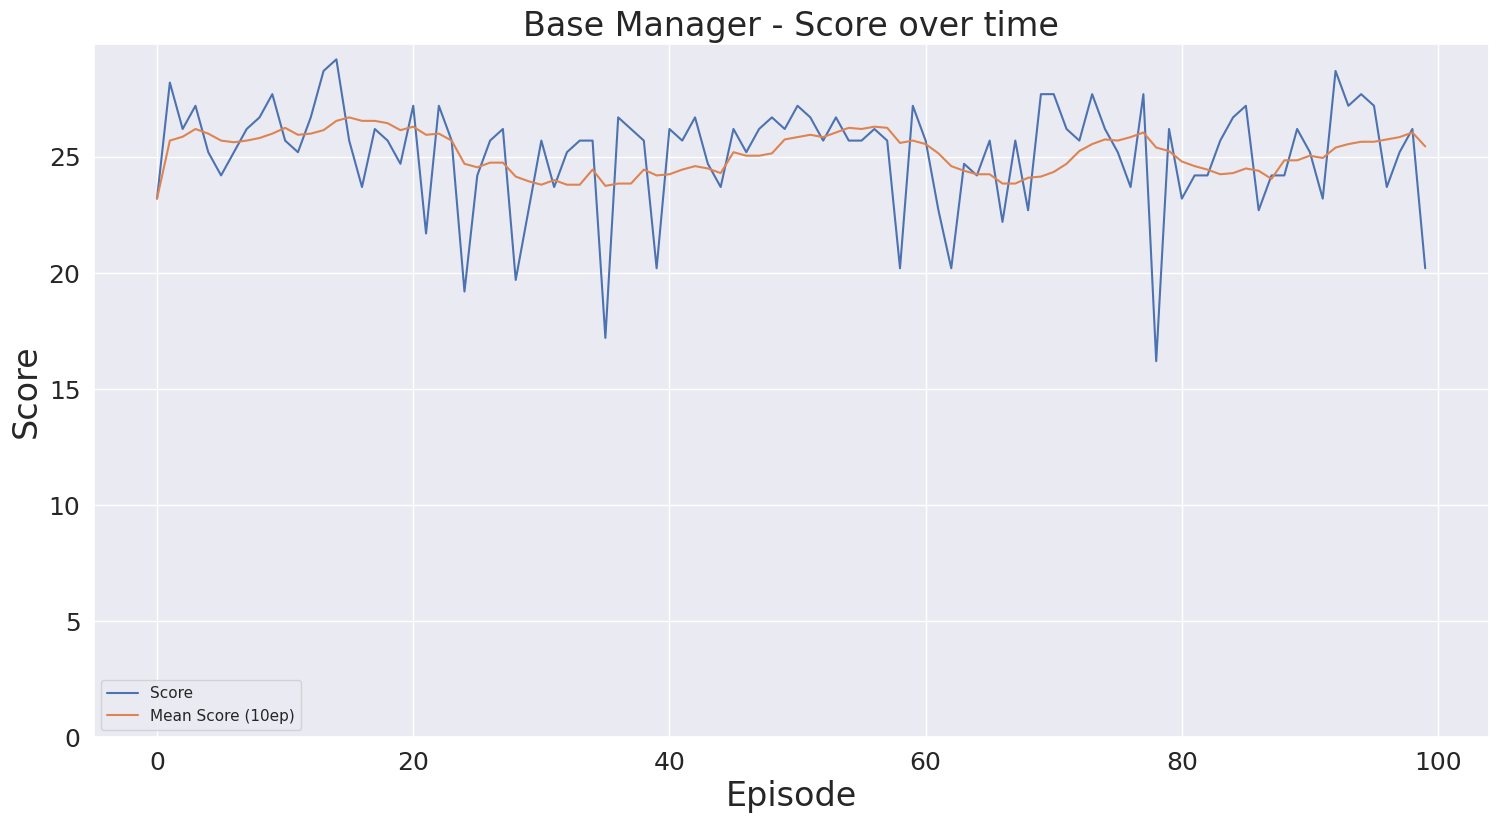

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


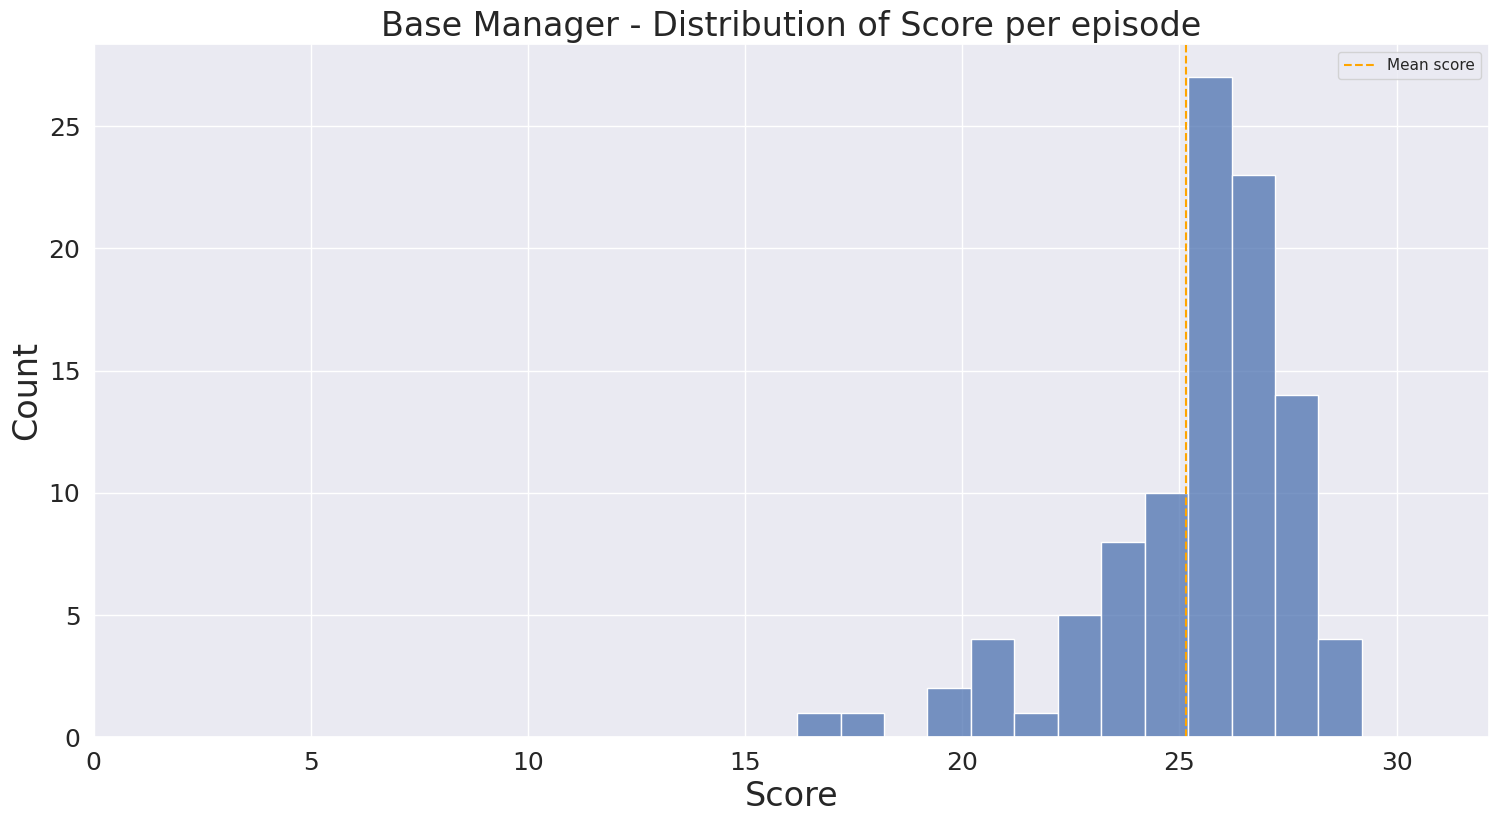

In [72]:
plot_scores(stages=["EXPLOIT"],**plot_args) ;

## Army Recruit Manager

### Random baseline

In [73]:
experiment_path = models_path / "RandomBaseline"

scenario_name = "BuildMarinesFixed"
model_suffix = f"multi_random_army_recruit_manager"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Recruit Manager - {scenario_name} - Random baseline"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

Total episodes: 100
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 0
Total exploit episodes: 100
Unique maps in episode stats:  ['BuildMarinesFixed']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


map_name  reward  adjusted_reward  steps  epsilon losses  \
0  BuildMarinesFixed     290            260.0    300      1.0     []   
1  BuildMarinesFixed     330            300.0    300      1.0     []   
2  BuildMarinesFixed     480            450.0    300      1.0     []   
3  BuildMarinesFixed     320            290.0    300      1.0     []   
4  BuildMarinesFixed     370            340.0    300      1.0     []   

   emissions  score  is_burnin  is_training  is_exploit  is_random_mode  \
0        0.0   2350      False        False        True           False   
1        0.0   2200      False        False        True           False   
2        0.0   3050      False        False        True           False   
3        0.0   2200      False        False        True           False   
4        0.0   2350      False        False        True           False   

  initial_stage final_stage  episode  loss invalid_action_counts  \
0       EXPLOIT     EXPLOIT        0   NaN          {'dummy': 0}   
1       EXPLOIT     EXPLOIT        1   NaN          {'dummy': 0}   
2       EXPLOIT     EXPLOIT        2   NaN          {'dummy': 0}   
3       EXPLOIT     EXPLOIT        3   NaN          {'dummy': 0}   
4       EXPLOIT     EXPLOIT        4   NaN          {'dummy': 0}   

                                 valid_action_counts  mean_loss_10ep  \
0  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 24...             NaN   
1  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 24...             NaN   
2  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 19...             NaN   
3  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 24...             NaN   
4  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 25...             NaN   

   mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
0        290.000000                 260.000000      2350.000000   
1        310.000000                 280.000000      2275.000000   
2        366.666667                 336.666667      2533.333333   
3        355.000000                 325.000000      2450.000000   
4        358.000000                 328.000000      2430.000000   

   mean_emissions_10ep  accumulated_emissions  
0                  0.0                    0.0  
1                  0.0                    0.0  
2                  0.0                    0.0  
3                  0.0                    0.0  
4                  0.0                    0.0

In [74]:
episode_stats[["initial_stage", "reward"]].groupby("initial_stage").mean()

reward
initial_stage        
EXPLOIT         339.1

/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


Plotting only EXPLOIT episodes


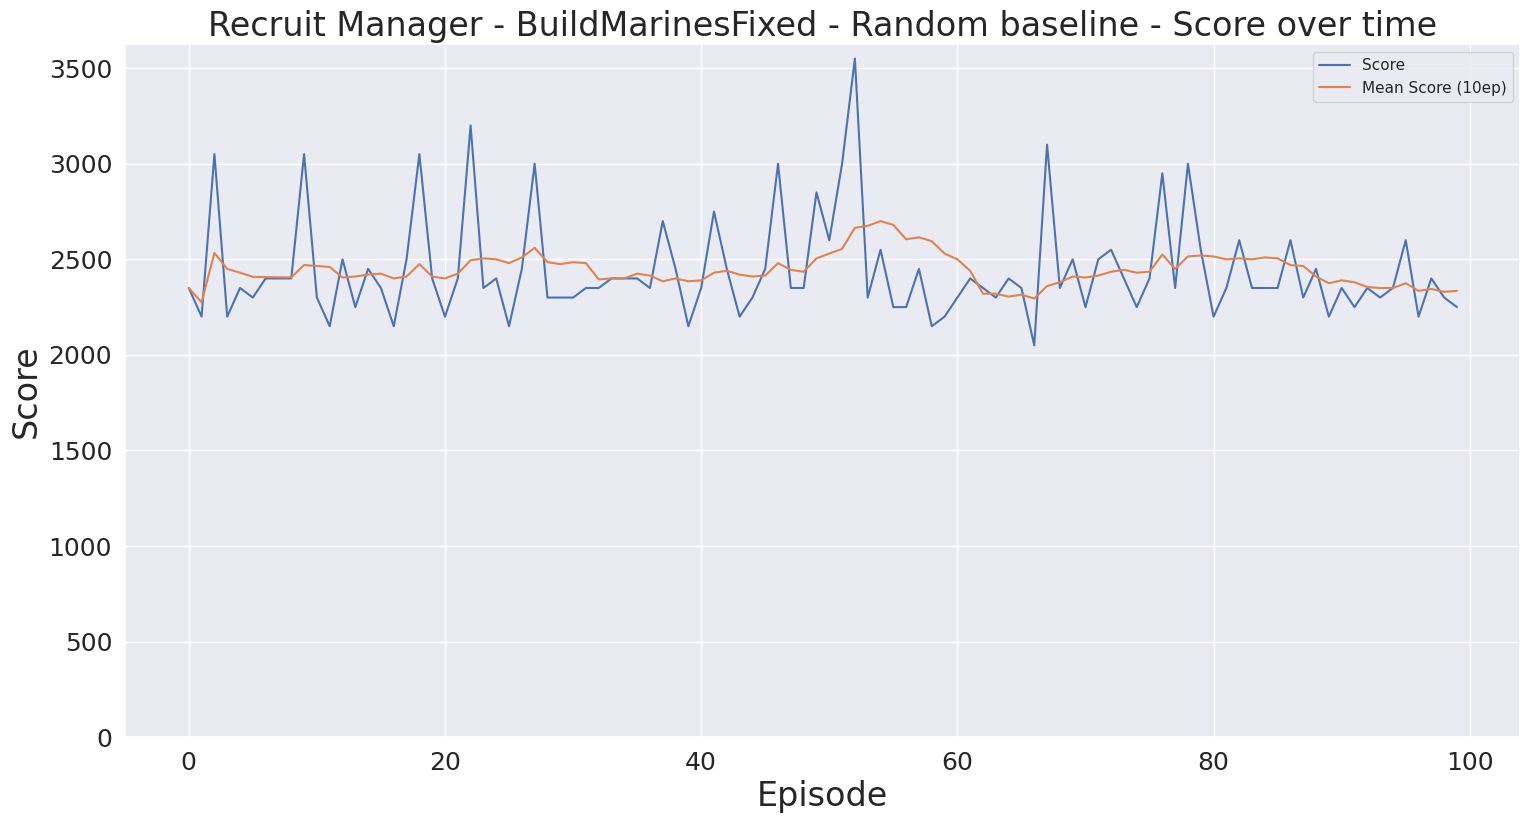

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


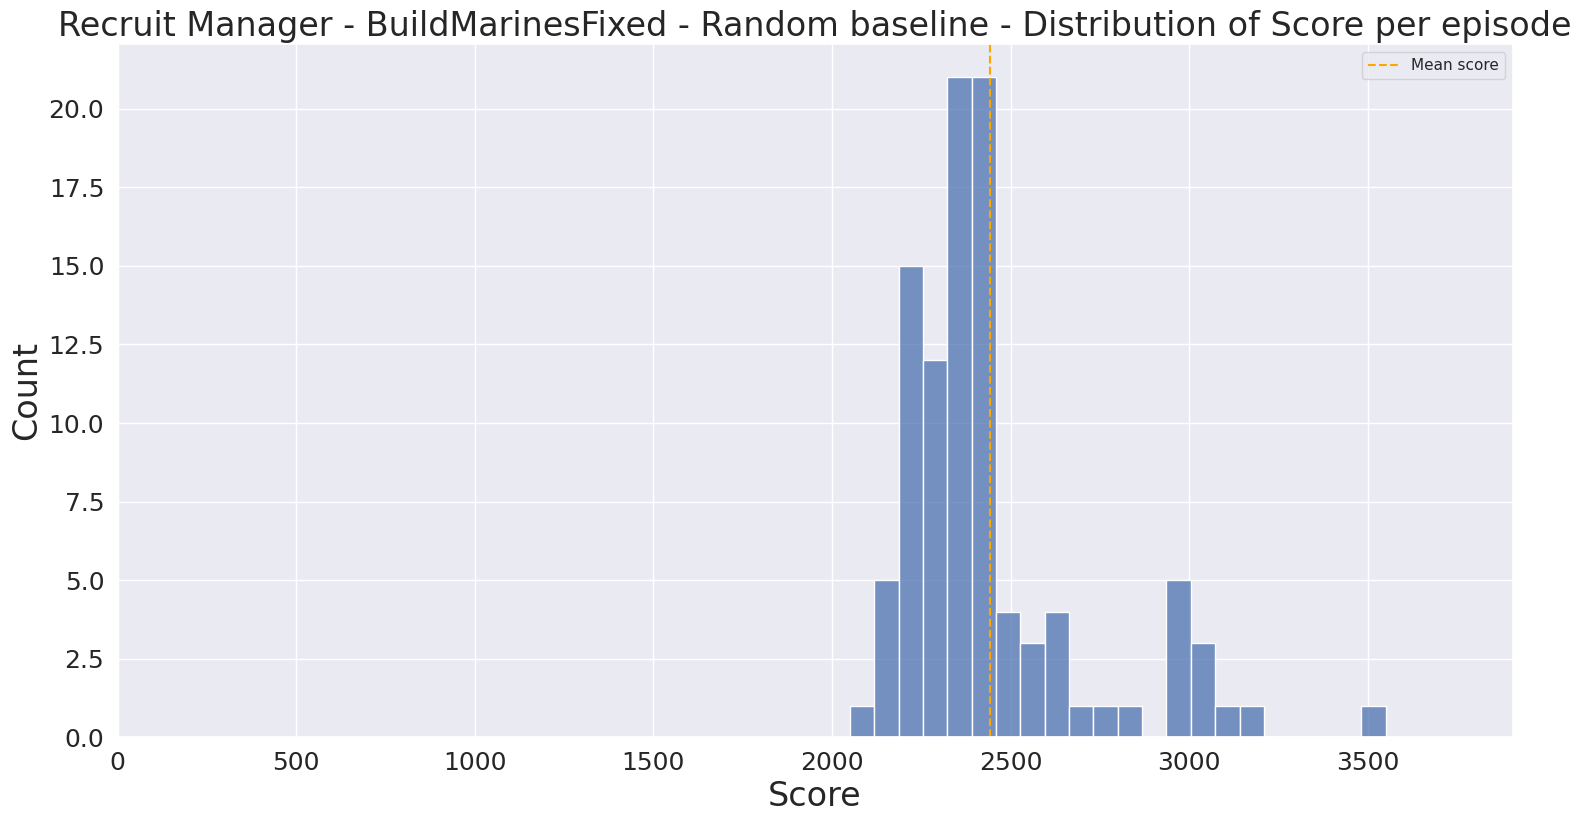

In [75]:
plot_scores(stages=["EXPLOIT"],**plot_args) ;

### Score reward scheme Exploration

In [76]:
experiment_path = models_path / "best_32"

scenario_name = "BuildMarinesRandom"
model_suffix = f"multi_dqn_army_recruit_manager_exploration"
model_path = experiment_path / model_suffix
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Recruit Manager - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 41
Total burnin episodes: 11
Total random mode episodes: 0
Total training episodes: 30
Total exploit episodes: 0
Unique maps in episode stats:  ['BuildMarinesRandom']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps   epsilon  \
36  BuildMarinesRandom     660            630.0    300  0.053751   
37  BuildMarinesRandom     410            380.0    300  0.050000   
38  BuildMarinesRandom     590            560.0    300  0.050000   
39  BuildMarinesRandom     480            450.0    300  0.050000   
40  BuildMarinesRandom     580            550.0    300  0.050000   

                                               losses  emissions  score  \
36  [10.44627571105957, 12.687966346740723, 9.7725...   0.006290   4250   
37  [12.040298461914062, 10.547734260559082, 12.17...   0.004863   3050   
38  [9.8352689743042, 12.347085952758789, 9.346141...   0.006692   3950   
39  [11.048276901245117, 10.089489936828613, 10.57...   0.006896   3150   
40  [11.419998168945312, 14.045954704284668, 13.52...   0.005310   3900   

    is_burnin  is_training  is_exploit  is_random_mode initial_stage  \
36      False         True       False           False      TRAINING   
37      False         True       False           False      TRAINING   
38      False         True       False           False      TRAINING   
39      False         True       False           False      TRAINING   
40      False         True       False           False      TRAINING   

   final_stage  episode       loss invalid_action_counts  \
36    TRAINING       36  11.377872          {'dummy': 0}   
37    TRAINING       37  11.349742          {'dummy': 0}   
38    TRAINING       38  11.216664          {'dummy': 0}   
39    TRAINING       39  11.302424          {'dummy': 0}   
40    TRAINING       40  11.720339          {'dummy': 0}   

                                  valid_action_counts  mean_loss_10ep  \
36  {'BUILD_BARRACKS': None, 'BUILD_SUPPLY_DEPOT':...        9.950190   
37  {'BUILD_BARRACKS': 7.0, 'BUILD_SUPPLY_DEPOT': ...       10.203362   
38  {'BUILD_BARRACKS': 2.0, 'BUILD_SUPPLY_DEPOT': ...       10.424102   
39  {'BUILD_BARRACKS': 4.0, 'BUILD_SUPPLY_DEPOT': ...       10.619309   
40  {'BUILD_BARRACKS': 2.0, 'BUILD_SUPPLY_DEPOT': ...       10.848867   

    mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
36             502.0                      472.0           3435.0   
37             478.0                      448.0           3315.0   
38             484.0                      454.0           3350.0   
39             476.0                      446.0           3300.0   
40             493.0                      463.0           3420.0   

    mean_emissions_10ep  accumulated_emissions  
36             0.004602               0.089657  
37             0.004634               0.094520  
38             0.004948               0.101212  
39             0.005269               0.108108  
40             0.005417               0.113419

In [77]:
emission_stats.iloc[-1]

timestamp                                           2024-12-09 20:44:50
project_name                                                 codecarbon
run_id                             fbe07681-0d8a-40d9-a807-efa3710b39ff
duration                                                    1077.158504
emissions                                                      0.001789
emissions_rate                                                 0.000002
cpu_power                                                          32.5
gpu_power                                                           0.0
ram_power                                                      2.888792
cpu_energy                                                     0.009724
gpu_energy                                                            0
ram_energy                                                     0.000864
energy_consumed                                                0.010589
country_name                                                    

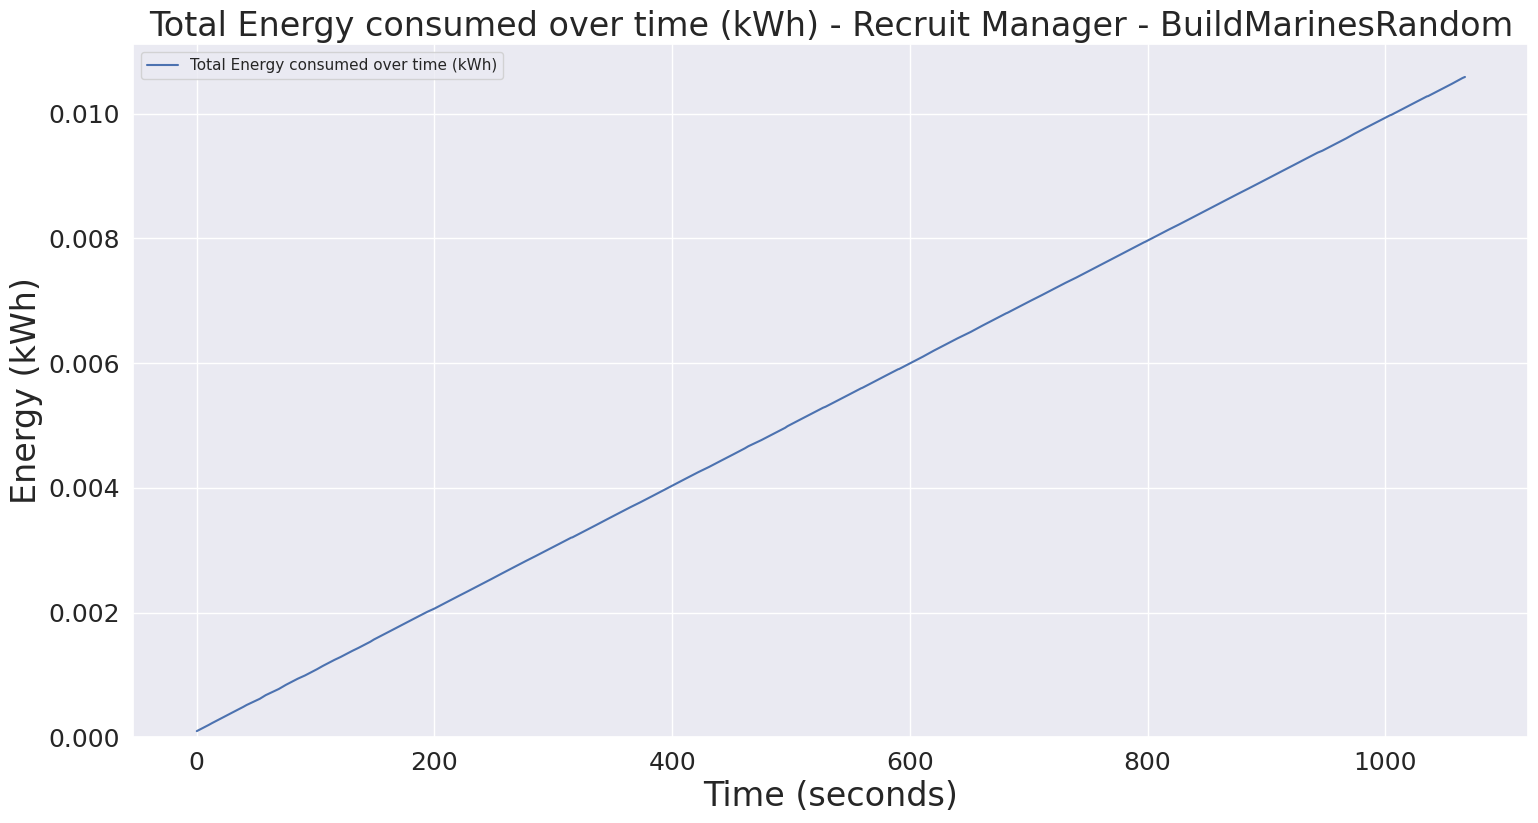

In [78]:
plot_emissions(emission_stats, save_images_path, model_name) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


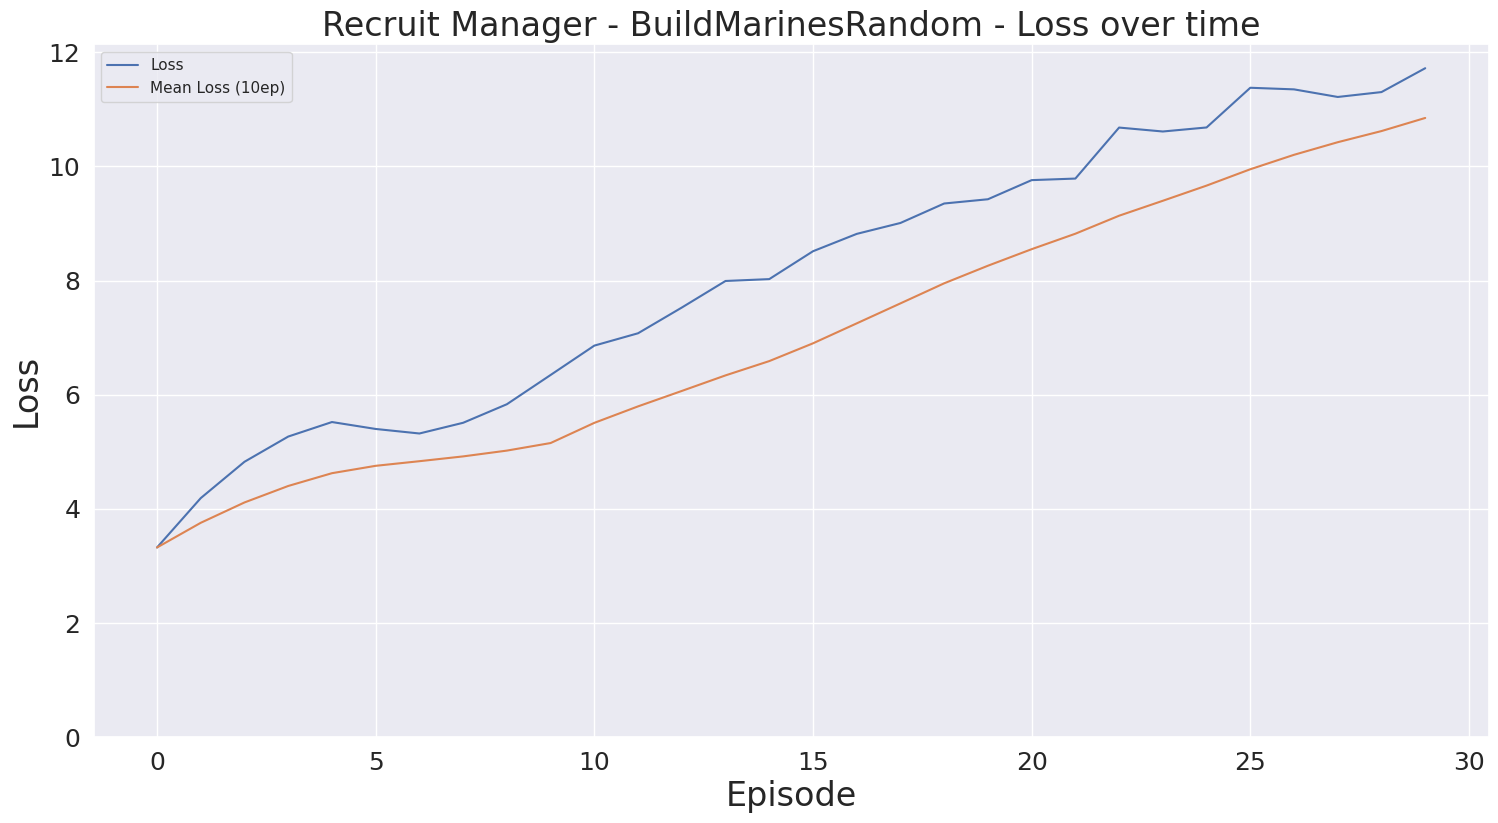

Plotting only TRAINING episodes


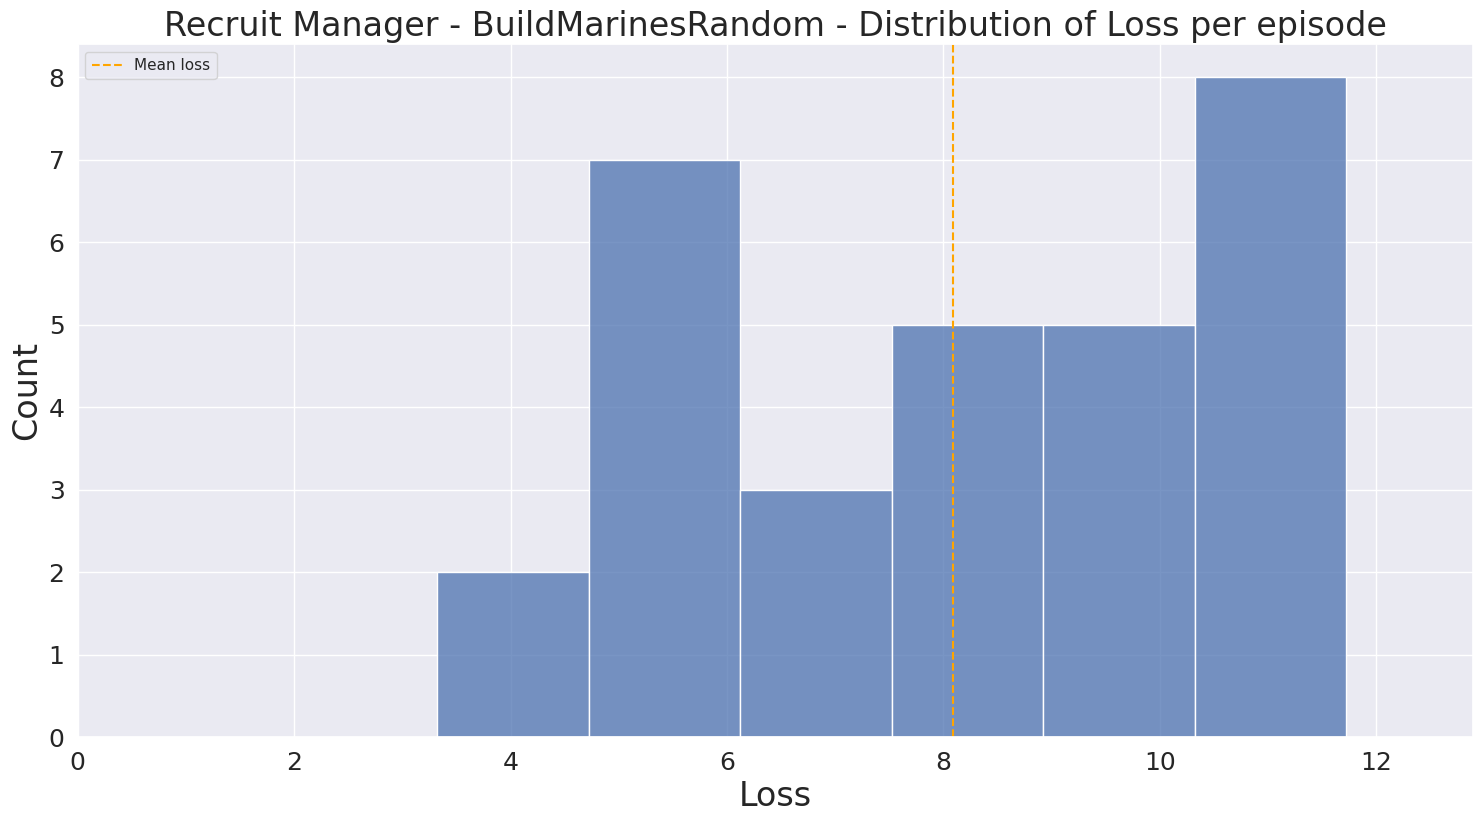

In [79]:
plot_losses(**plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


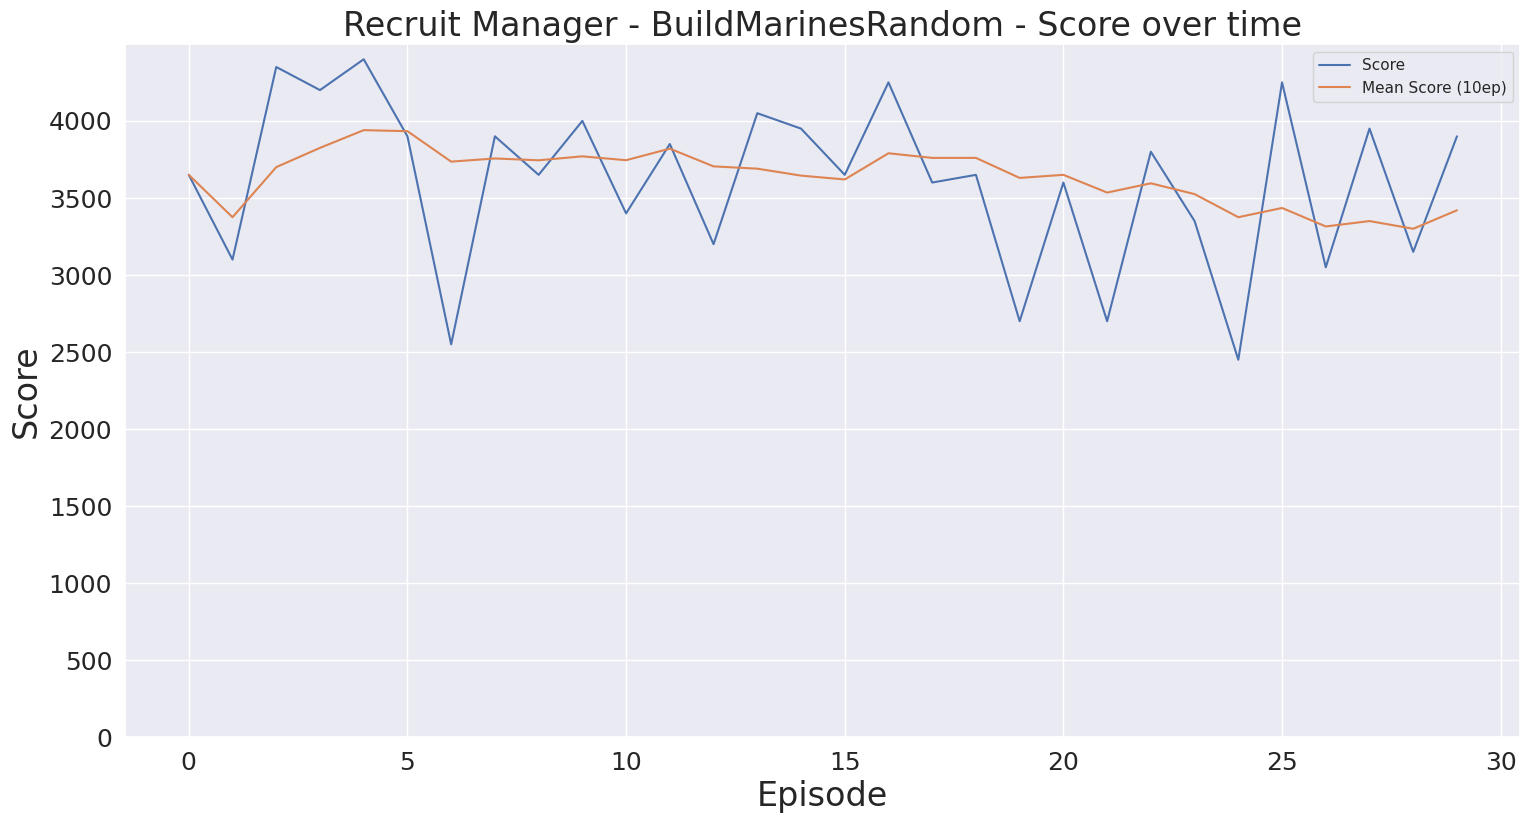

Plotting only TRAINING episodes


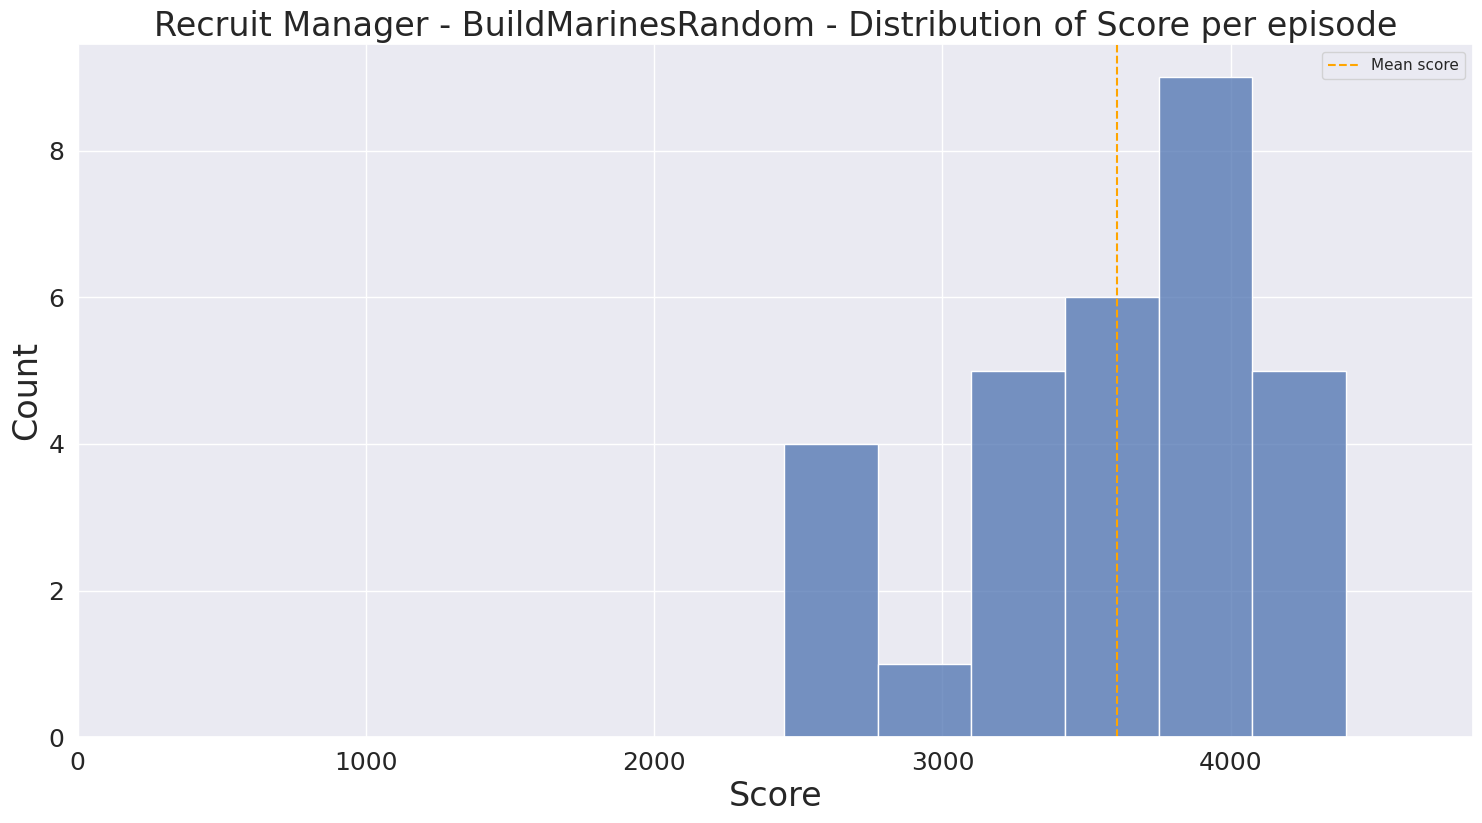

In [80]:
plot_scores(stages=["TRAINING"], **plot_args) ;

Plotting only TRAINING episodes


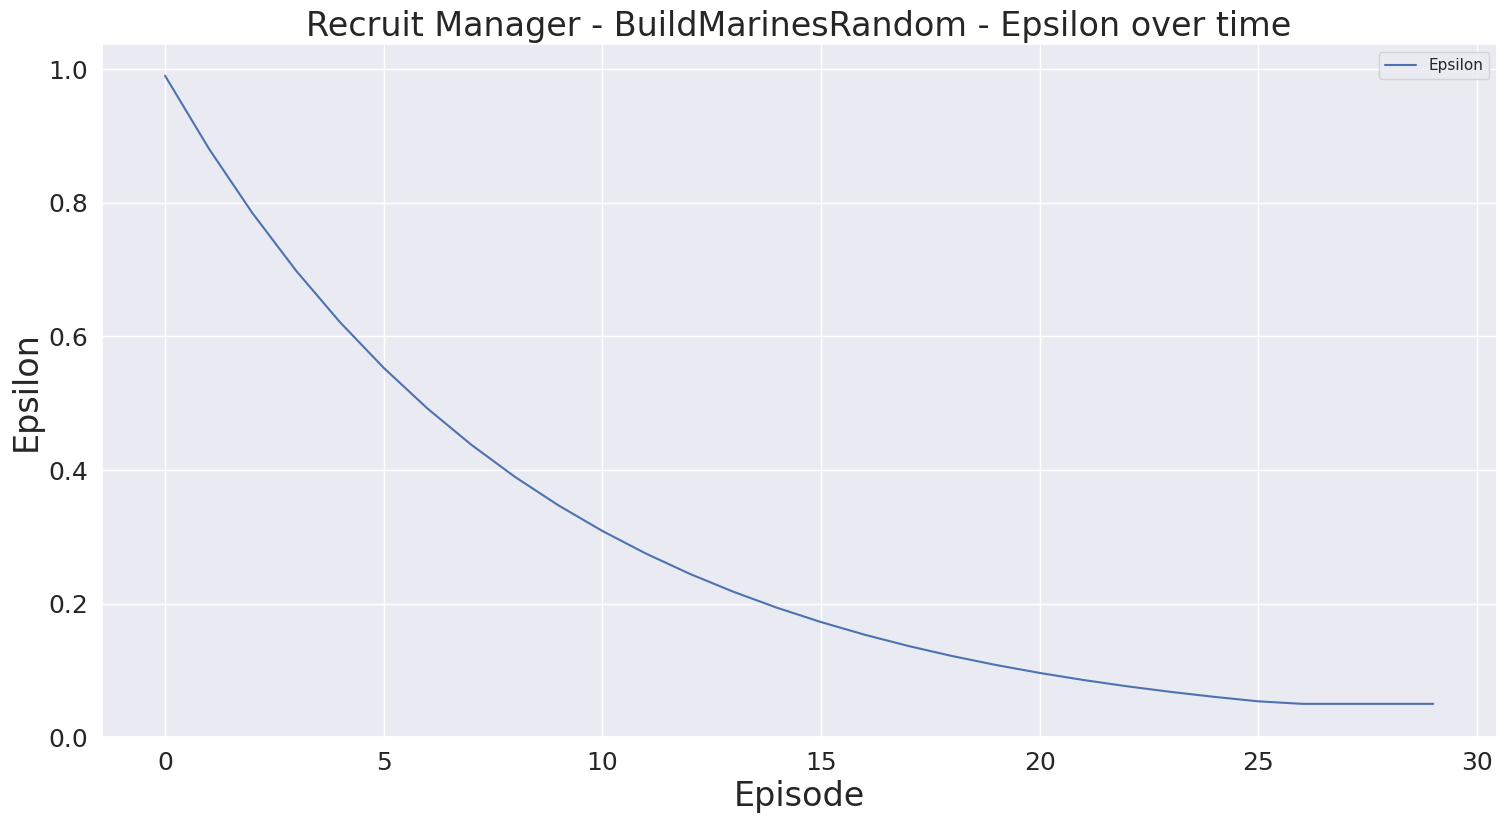

In [81]:
plot_epsilon(**plot_args) ;

### Score reward scheme Training

In [82]:
experiment_path = models_path / "best_32"

scenario_name = "BuildMarinesFixed"
model_suffix = f"multi_dqn_army_recruit_manager"
model_path = experiment_path / model_suffix
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Recruit Manager - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 30
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 30
Total exploit episodes: 0
Unique maps in episode stats:  ['BuildMarinesFixed']


map_name  reward  adjusted_reward  steps   epsilon  \
25  BuildMarinesFixed     490            460.0    300  0.053751   
26  BuildMarinesFixed     430            400.0    300  0.050000   
27  BuildMarinesFixed     520            490.0    300  0.050000   
28  BuildMarinesFixed     510            480.0    300  0.050000   
29  BuildMarinesFixed     540            510.0    300  0.050000   

                                               losses  emissions  score  \
25  [13.061075210571289, 13.68050765991211, 14.436...   0.006855   3400   
26  [10.615574836730957, 13.426578521728516, 10.63...   0.007109   3100   
27  [11.828131675720215, 12.449511528015137, 13.37...   0.009231   3550   
28  [12.196358680725098, 11.45894718170166, 12.841...   0.007654   3500   
29  [12.750527381896973, 11.887771606445312, 13.53...   0.007916   3650   

    is_burnin  is_training  is_exploit  is_random_mode initial_stage  \
25      False         True       False           False      TRAINING   
26      False         True       False           False      TRAINING   
27      False         True       False           False      TRAINING   
28      False         True       False           False      TRAINING   
29      False         True       False           False      TRAINING   

   final_stage  episode       loss invalid_action_counts  \
25    TRAINING       25  12.585264          {'dummy': 0}   
26    TRAINING       26  12.466264          {'dummy': 0}   
27    TRAINING       27  12.580915          {'dummy': 0}   
28    TRAINING       28  12.842139          {'dummy': 0}   
29    TRAINING       29  12.673060          {'dummy': 0}   

                                  valid_action_counts  mean_loss_10ep  \
25  {'BUILD_BARRACKS': 6, 'BUILD_SUPPLY_DEPOT': 16...       12.570468   
26  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 21...       12.603082   
27  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 15...       12.639816   
28  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 17...       12.659727   
29  {'BUILD_BARRACKS': 6, 'BUILD_SUPPLY_DEPOT': 16...       12.662588   

    mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
25             513.0                      483.0           3500.0   
26             505.0                      475.0           3460.0   
27             503.0                      473.0           3455.0   
28             498.0                      468.0           3430.0   
29             500.0                      470.0           3440.0   

    mean_emissions_10ep  accumulated_emissions  
25             0.006100               0.100205  
26             0.006357               0.107313  
27             0.006678               0.116544  
28             0.006808               0.124198  
29             0.007067               0.132115

In [83]:
emission_stats.iloc[-1]

timestamp                                           2024-12-09 21:40:28
project_name                                                 codecarbon
run_id                             29ac95aa-c548-47e2-af15-49cae2e77ba0
duration                                                    1208.645218
emissions                                                      0.002007
emissions_rate                                                 0.000002
cpu_power                                                          32.5
gpu_power                                                           0.0
ram_power                                                      2.888792
cpu_energy                                                     0.010911
gpu_energy                                                            0
ram_energy                                                      0.00097
energy_consumed                                                0.011881
country_name                                                    

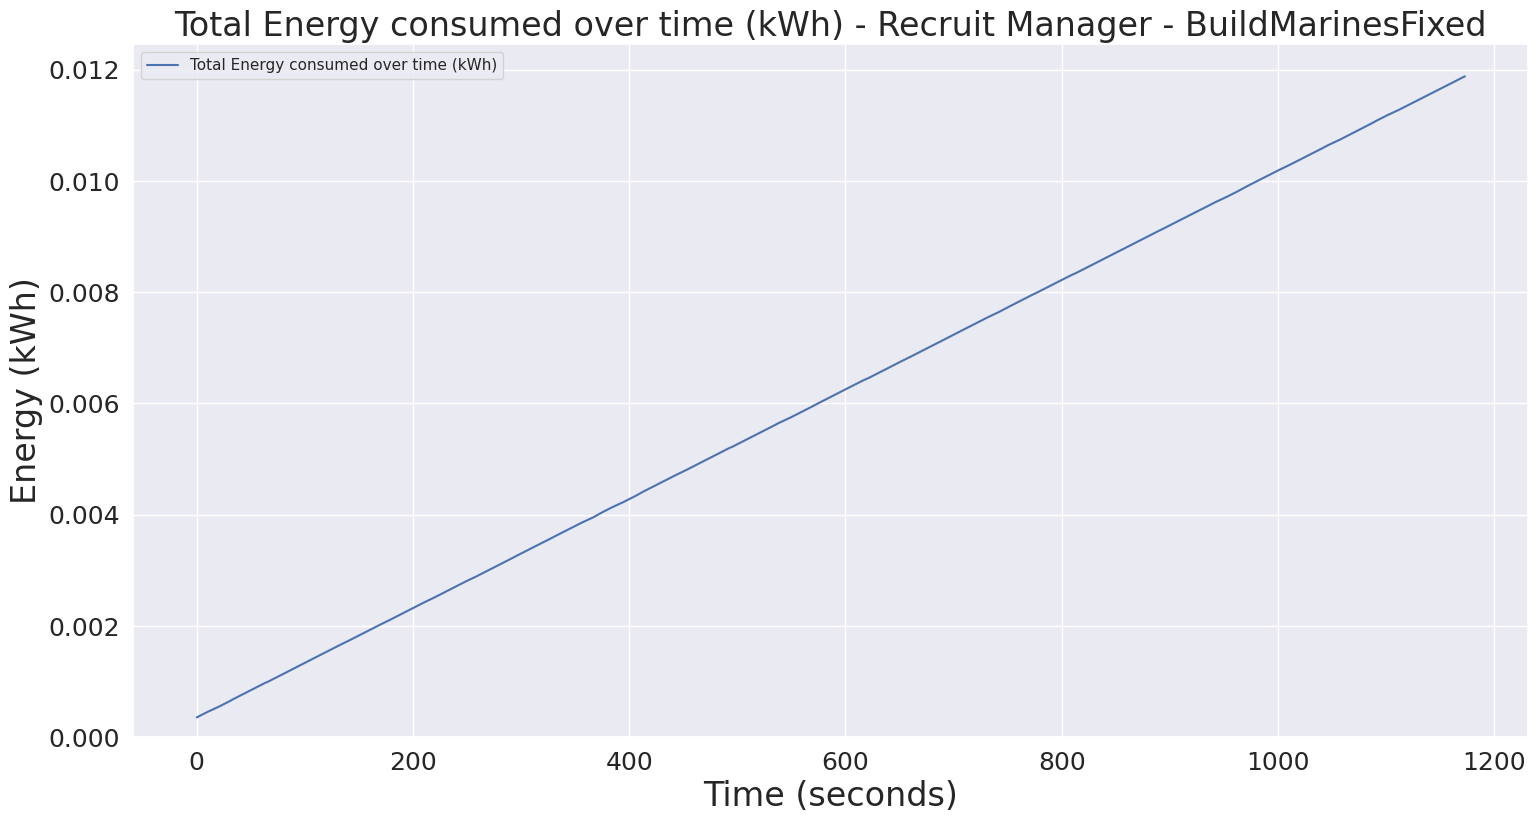

In [84]:
plot_emissions(emission_stats, save_images_path, model_name) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


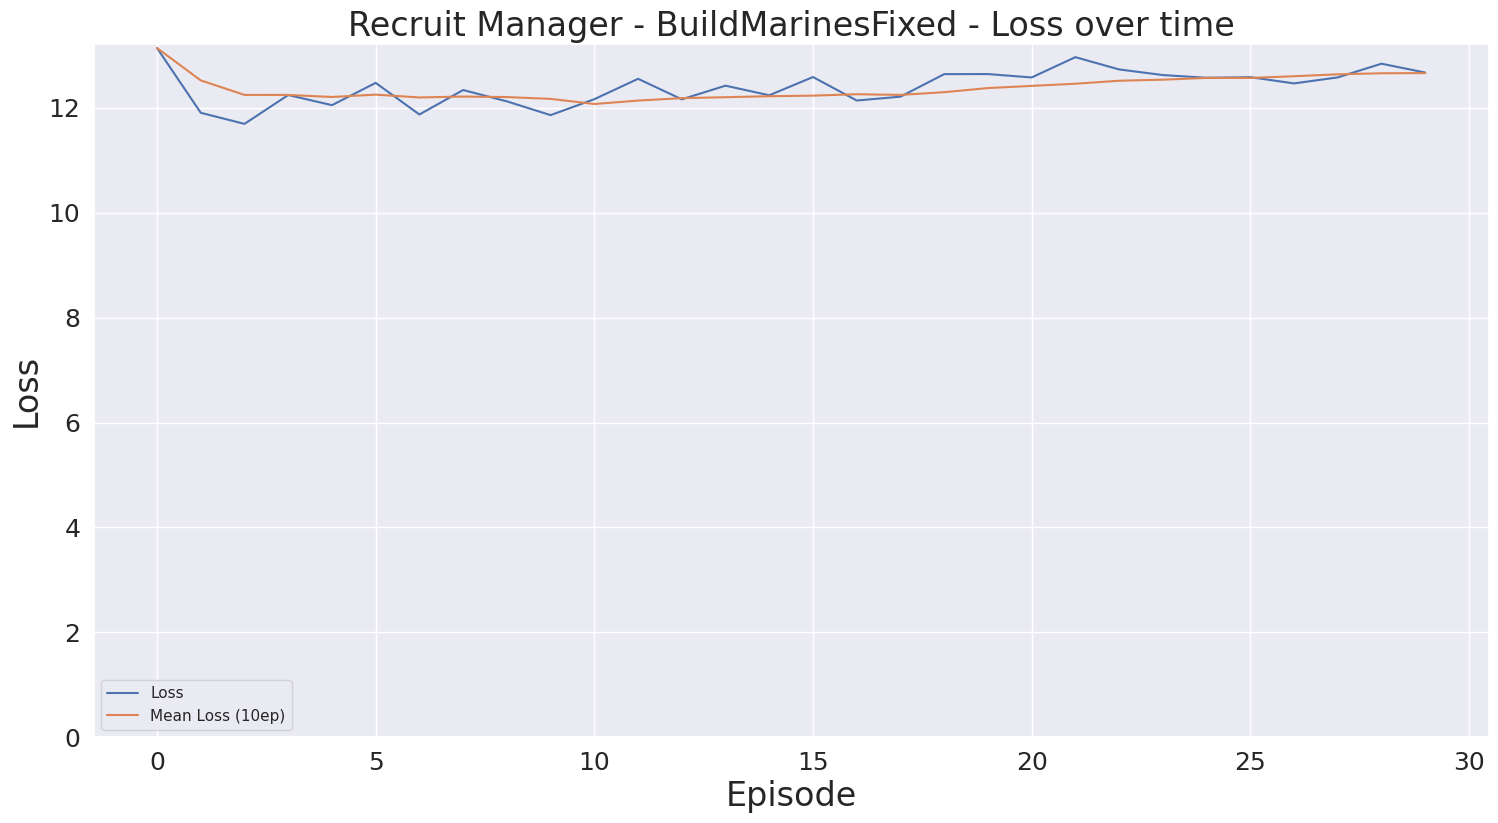

Plotting only TRAINING episodes


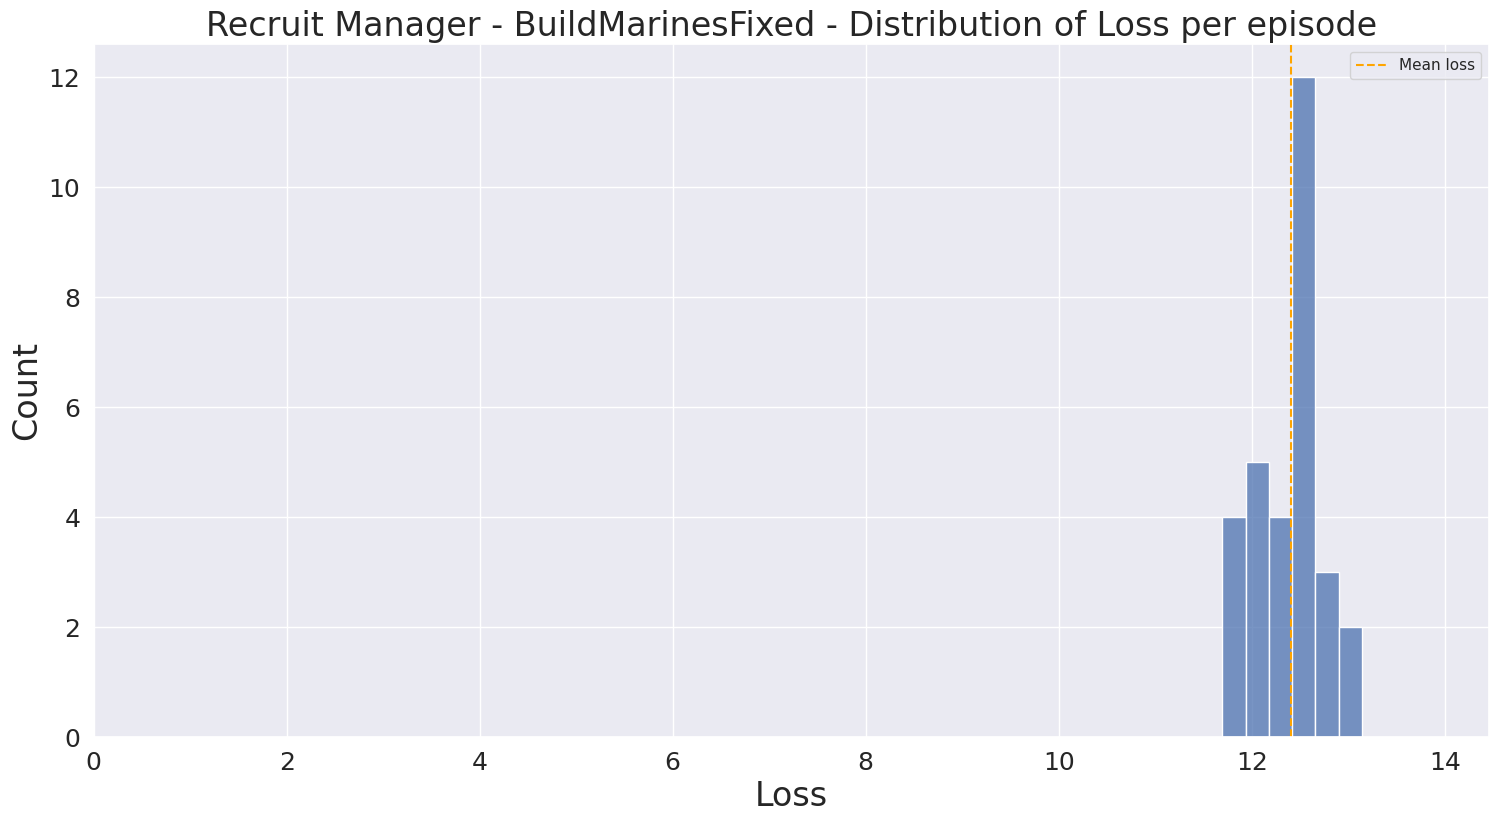

In [85]:
plot_losses(**plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


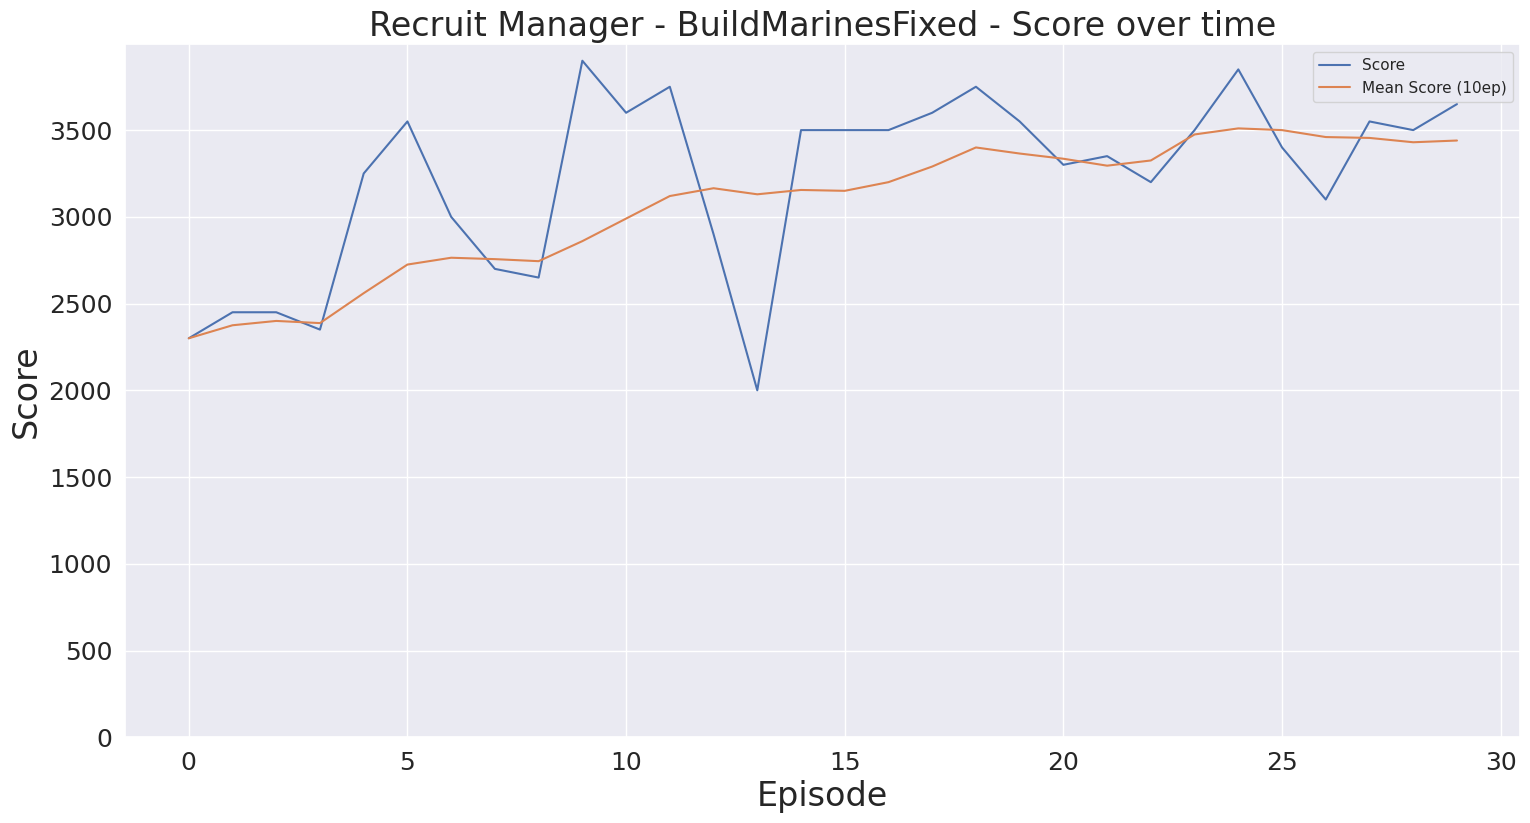

Plotting only TRAINING episodes


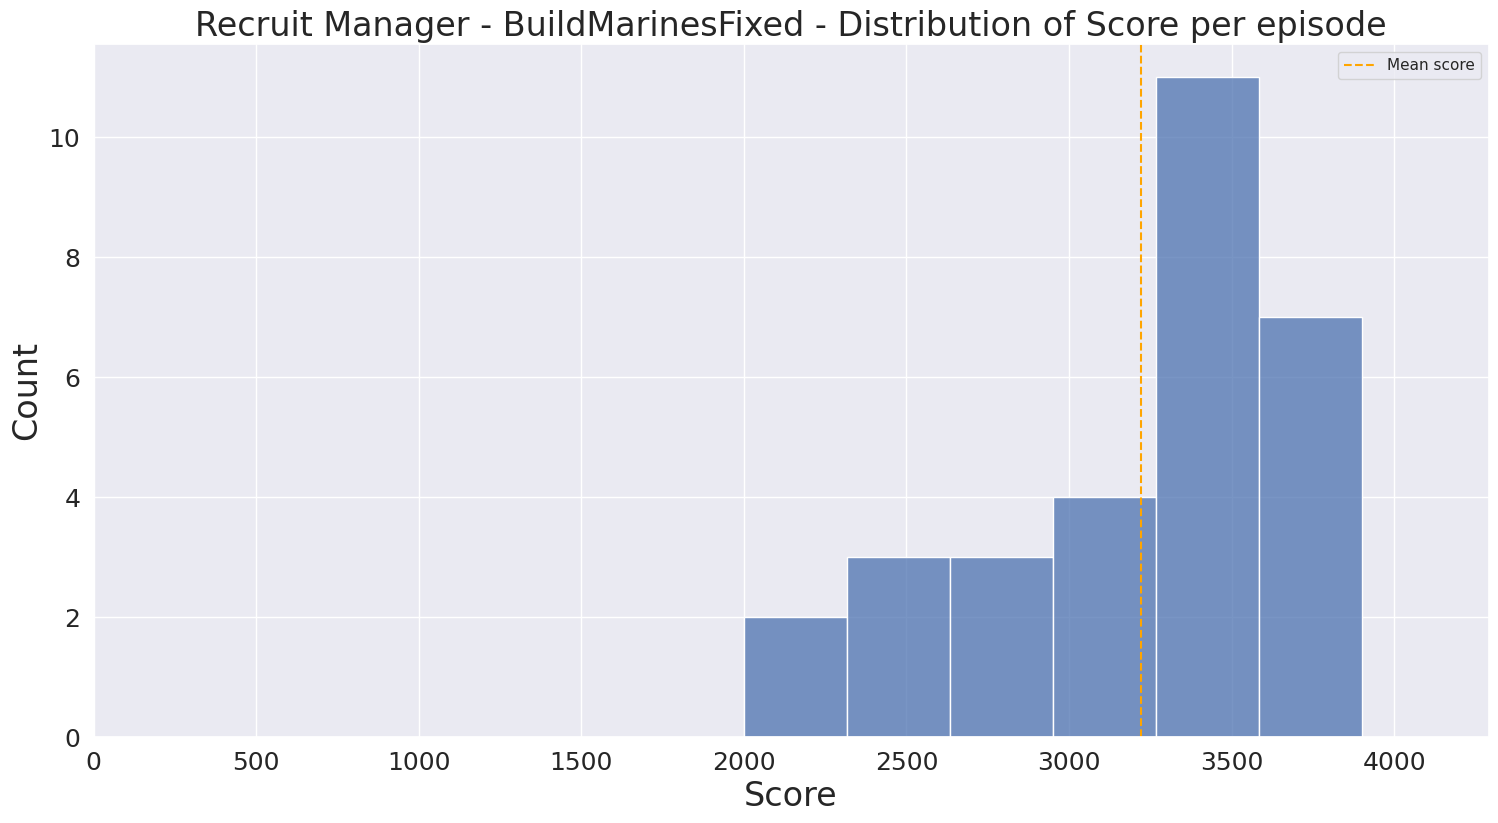

In [86]:
plot_scores(stages=["TRAINING"], **plot_args) ;

### Score reward scheme Exploit

In [87]:
experiment_path = models_path / "best_32"

scenario_name = "BuildMarinesFixed"
model_suffix = f"multi_dqn_army_recruit_manager"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Recruit Manager - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 130
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 30
Total exploit episodes: 100
Unique maps in episode stats:  ['BuildMarinesFixed']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps  epsilon losses  \
125  BuildMarinesFixed     540            510.0    300      0.0     []   
126  BuildMarinesFixed     430            400.0    300      0.0     []   
127  BuildMarinesFixed     540            510.0    300      0.0     []   
128  BuildMarinesFixed     540            510.0    300      0.0     []   
129  BuildMarinesFixed     540            510.0    300      0.0     []   

     emissions  score  is_burnin  is_training  is_exploit  is_random_mode  \
125        0.0   3650      False        False        True           False   
126        0.0   3150      False        False        True           False   
127        0.0   3650      False        False        True           False   
128        0.0   3700      False        False        True           False   
129        0.0   3700      False        False        True           False   

    initial_stage final_stage  episode  loss invalid_action_counts  \
125       EXPLOIT     EXPLOIT      125   NaN          {'dummy': 0}   
126       EXPLOIT     EXPLOIT      126   NaN          {'dummy': 0}   
127       EXPLOIT     EXPLOIT      127   NaN          {'dummy': 0}   
128       EXPLOIT     EXPLOIT      128   NaN          {'dummy': 0}   
129       EXPLOIT     EXPLOIT      129   NaN          {'dummy': 0}   

                                   valid_action_counts  mean_loss_10ep  \
125  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 14...             NaN   
126  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 13...             NaN   
127  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 14...             NaN   
128  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 14...             NaN   
129  {'BUILD_BARRACKS': 4, 'BUILD_SUPPLY_DEPOT': 14...             NaN   

     mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
125             518.0                      488.0           3570.0   
126             518.0                      488.0           3570.0   
127             518.0                      488.0           3565.0   
128             529.0                      499.0           3620.0   
129             529.0                      499.0           3625.0   

     mean_emissions_10ep  accumulated_emissions  
125                  0.0               0.132115  
126                  0.0               0.132115  
127                  0.0               0.132115  
128                  0.0               0.132115  
129                  0.0               0.132115

/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


Plotting only EXPLOIT episodes


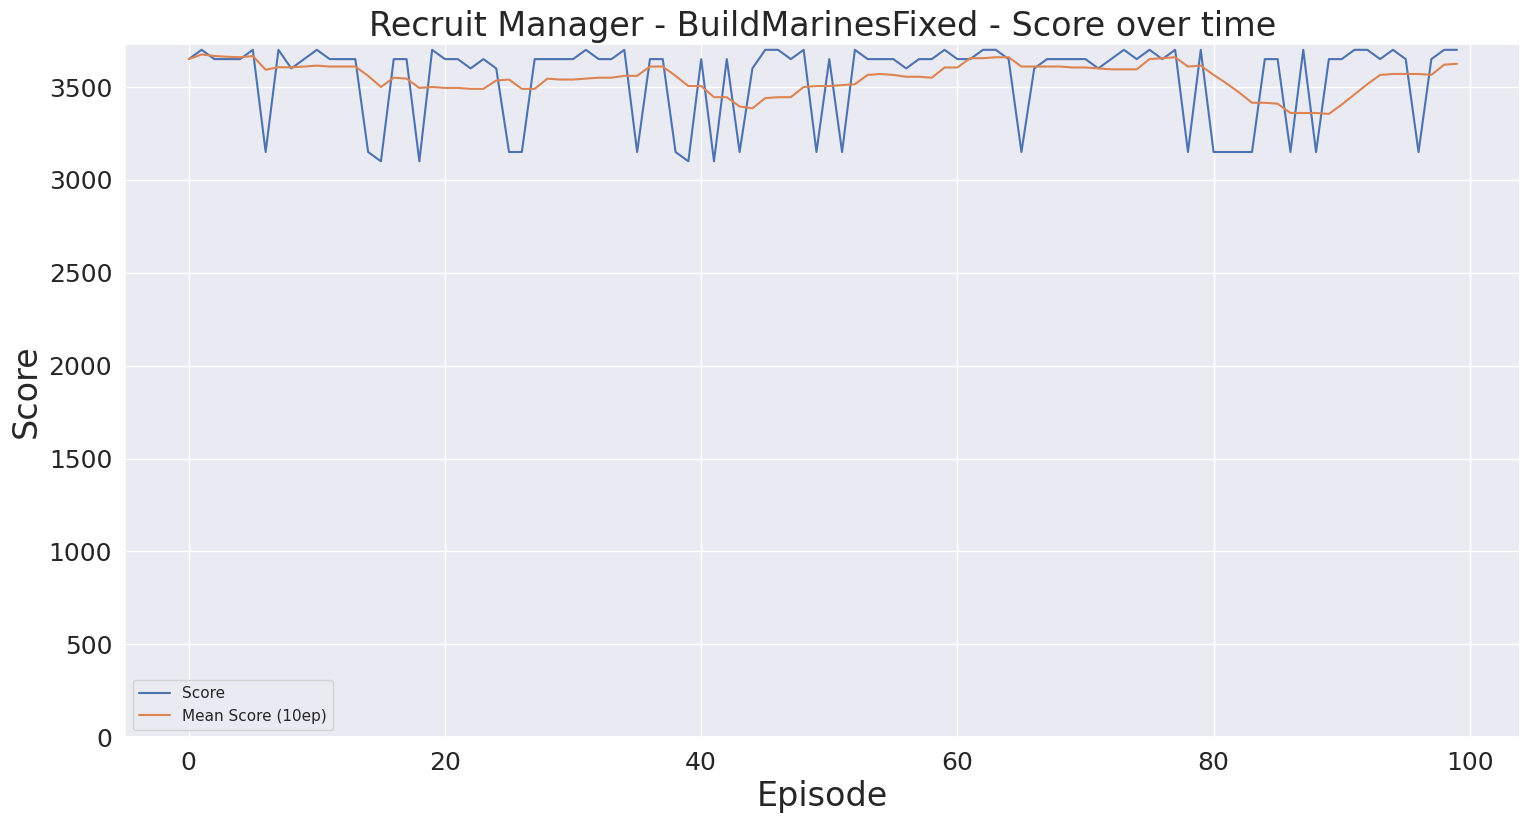

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


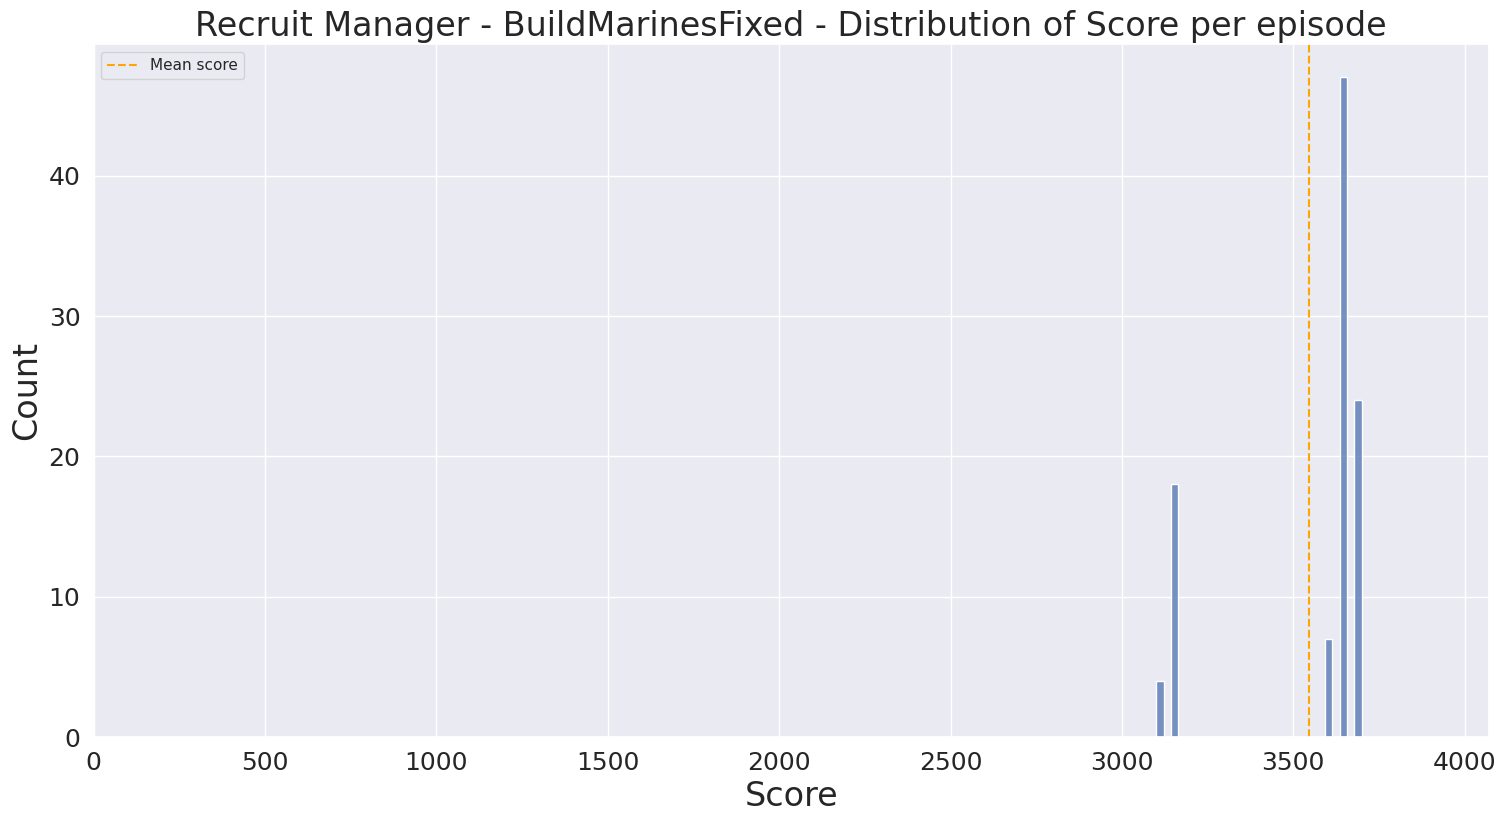

In [88]:
plot_scores(stages=["EXPLOIT"], **plot_args) ;

## Army Attack Manager

### Random baseline

In [89]:
experiment_path = models_path / "RandomBaseline"

scenario_name = "DefeatBases"
model_suffix = f"multi_random_army_attack_manager"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Attack Manager - {scenario_name} - Random baseline"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

Total episodes: 100
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 0
Total exploit episodes: 100
Unique maps in episode stats:  ['DefeatBases']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


map_name  reward  adjusted_reward  steps  epsilon losses  emissions  \
0  DefeatBases       0             -1.3     13      1.0     []        0.0   
1  DefeatBases       0             -1.4     14      1.0     []        0.0   
2  DefeatBases       0             -1.3     13      1.0     []        0.0   
3  DefeatBases       0             -1.2     12      1.0     []        0.0   
4  DefeatBases       0             -1.4     14      1.0     []        0.0   

   score  is_burnin  is_training  is_exploit  is_random_mode initial_stage  \
0 -405.5      False        False        True           False       EXPLOIT   
1 -705.5      False        False        True           False       EXPLOIT   
2 -198.5      False        False        True           False       EXPLOIT   
3 -386.5      False        False        True           False       EXPLOIT   
4 -389.5      False        False        True           False       EXPLOIT   

  final_stage  episode  loss invalid_action_counts  \
0     EXPLOIT        0   NaN          {'dummy': 0}   
1     EXPLOIT        1   NaN          {'dummy': 0}   
2     EXPLOIT        2   NaN          {'dummy': 0}   
3     EXPLOIT        3   NaN          {'dummy': 0}   
4     EXPLOIT        4   NaN          {'dummy': 0}   

                                 valid_action_counts  mean_loss_10ep  \
0  {'ATTACK_ARMY': 1.0, 'ATTACK_BUILDINGS': 1.0, ...             NaN   
1  {'ATTACK_ARMY': 1.0, 'ATTACK_BUILDINGS': 3.0, ...             NaN   
2  {'ATTACK_ARMY': 4.0, 'ATTACK_BUILDINGS': 2.0, ...             NaN   
3  {'ATTACK_ARMY': 2.0, 'ATTACK_BUILDINGS': 2.0, ...             NaN   
4  {'ATTACK_ARMY': 5.0, 'ATTACK_BUILDINGS': 3.0, ...             NaN   

   mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
0               0.0                  -1.300000           -405.5   
1               0.0                  -1.350000           -555.5   
2               0.0                  -1.333333           -436.5   
3               0.0                  -1.300000           -424.0   
4               0.0                  -1.320000           -417.1   

   mean_emissions_10ep  accumulated_emissions  
0                  0.0                    0.0  
1                  0.0                    0.0  
2                  0.0                    0.0  
3                  0.0                    0.0  
4                  0.0                    0.0

In [90]:
episode_stats[["initial_stage", "reward"]].groupby("initial_stage").mean()

reward
initial_stage        
EXPLOIT           0.0

/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


Plotting only EXPLOIT episodes


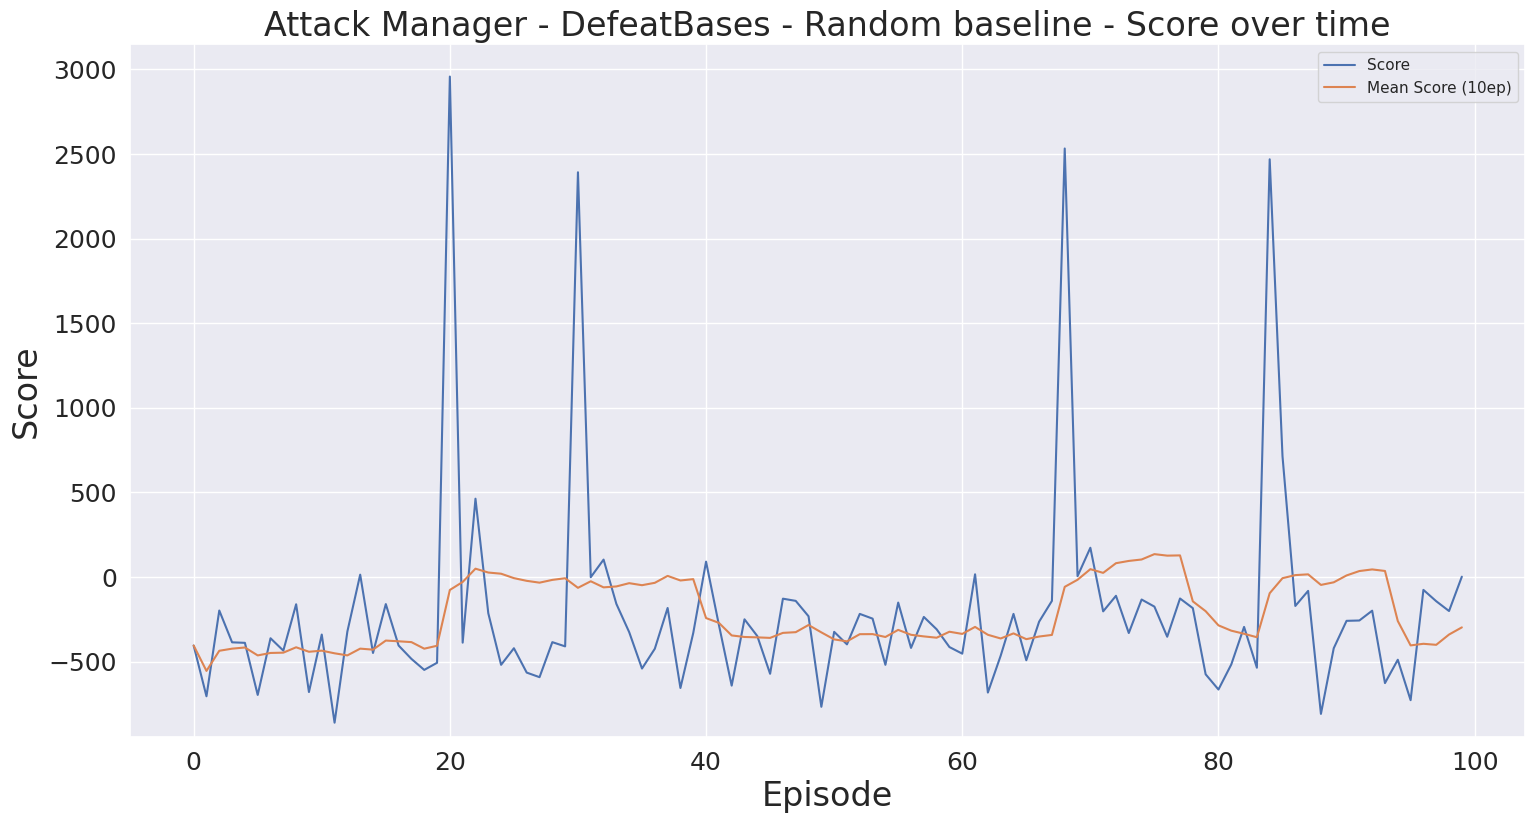

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


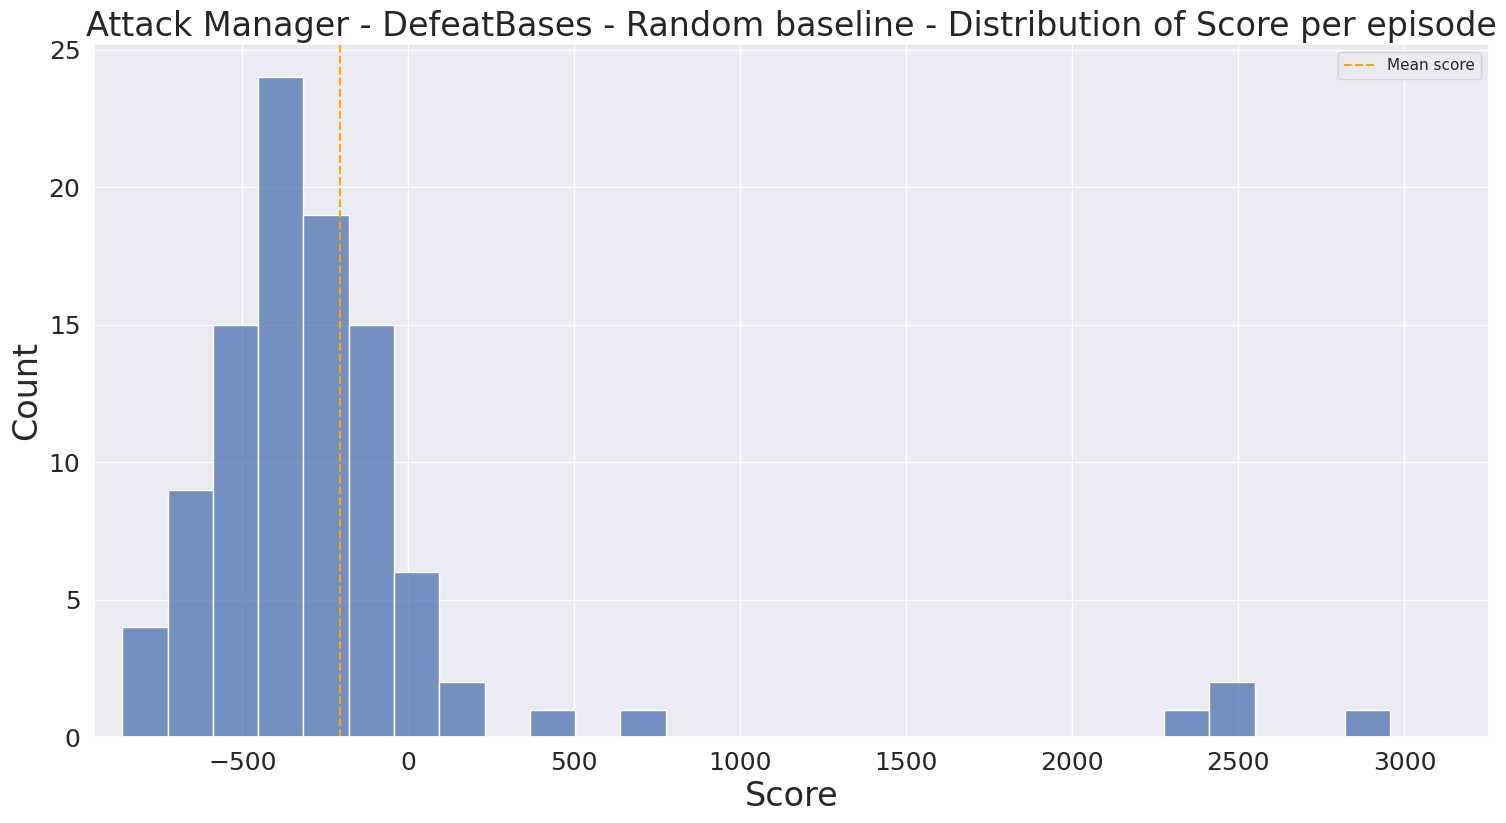

In [91]:
plot_scores(stages=["EXPLOIT"],**plot_args) ;

### Score reward scheme Training

In [92]:
experiment_path = models_path / "best_32"

scenario_name = "DefeatBases"
model_suffix = f"multi_dqn_army_attack_manager"
model_path = experiment_path / model_suffix
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Attack Manager - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 150
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 150
Total exploit episodes: 0
Unique maps in episode stats:  ['DefeatBases']


map_name  reward  adjusted_reward  steps  epsilon  \
145  DefeatBases       0             -4.7     47    0.005   
146  DefeatBases       0             -5.9     59    0.005   
147  DefeatBases       0             -3.8     38    0.005   
148  DefeatBases       0             -5.1     51    0.005   
149  DefeatBases       0             -3.6     36    0.005   

                                                losses  emissions   score  \
145  [31.24416732788086, 24.294496536254883, 30.653...   0.000941  2628.5   
146  [23.677839279174805, 26.15410804748535, 28.019...   0.000949  2915.5   
147  [24.64508819580078, 30.114009857177734, 23.778...   0.000955  3153.2   
148  [25.55941390991211, 28.0499324798584, 28.88956...   0.000963  2983.5   
149  [29.45714569091797, 25.782852172851562, 30.760...   0.000968  2573.3   

     is_burnin  is_training  is_exploit  is_random_mode initial_stage  \
145      False         True       False           False      TRAINING   
146      False         True       False           False      TRAINING   
147      False         True       False           False      TRAINING   
148      False         True       False           False      TRAINING   
149      False         True       False           False      TRAINING   

    final_stage  episode       loss invalid_action_counts  \
145    TRAINING      145  26.447861          {'dummy': 0}   
146    TRAINING      146  26.901715          {'dummy': 0}   
147    TRAINING      147  26.851228          {'dummy': 0}   
148    TRAINING      148  27.087518          {'dummy': 0}   
149    TRAINING      149  26.922733          {'dummy': 0}   

                                   valid_action_counts  mean_loss_10ep  \
145  {'ATTACK_ARMY': 4.0, 'ATTACK_BUILDINGS': 2.0, ...       26.790917   
146  {'ATTACK_ARMY': 2.0, 'ATTACK_BUILDINGS': None,...       26.801820   
147  {'ATTACK_ARMY': 4.0, 'ATTACK_BUILDINGS': 3.0, ...       26.761055   
148  {'ATTACK_ARMY': None, 'ATTACK_BUILDINGS': None...       26.818464   
149  {'ATTACK_ARMY': 5.0, 'ATTACK_BUILDINGS': 4.0, ...       26.872511   

     mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
145               0.0                      -4.06          2830.39   
146               0.0                      -4.26          2804.63   
147               0.0                      -4.26          2874.09   
148               0.0                      -4.40          2868.89   
149               0.0                      -4.36          2831.88   

     mean_emissions_10ep  accumulated_emissions  
145             0.000912               0.067013  
146             0.000919               0.067962  
147             0.000925               0.068917  
148             0.000932               0.069880  
149             0.000938               0.070848

In [93]:
emission_stats.iloc[-1]

timestamp                                           2024-12-08 16:55:15
project_name                                                 codecarbon
run_id                             bbfcac97-7179-4929-a453-1cef67c91314
duration                                                     585.071483
emissions                                                      0.000972
emissions_rate                                                 0.000002
cpu_power                                                          32.5
gpu_power                                                           0.0
ram_power                                                      2.888793
cpu_energy                                                     0.005282
gpu_energy                                                            0
ram_energy                                                     0.000469
energy_consumed                                                0.005751
country_name                                                    

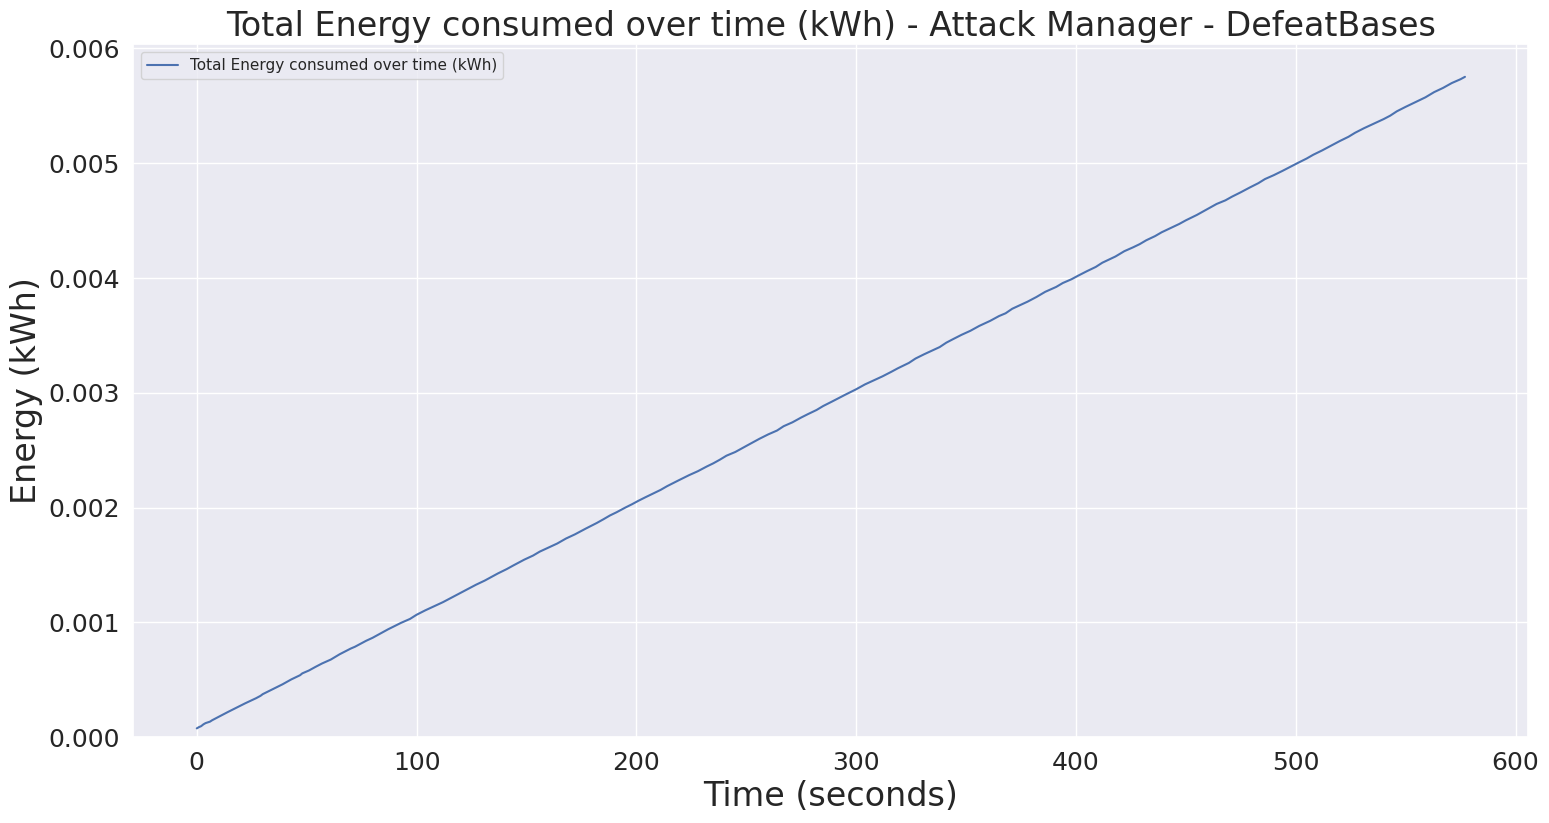

In [94]:
plot_emissions(emission_stats, save_images_path, model_name) ;

Plotting only TRAINING episodes


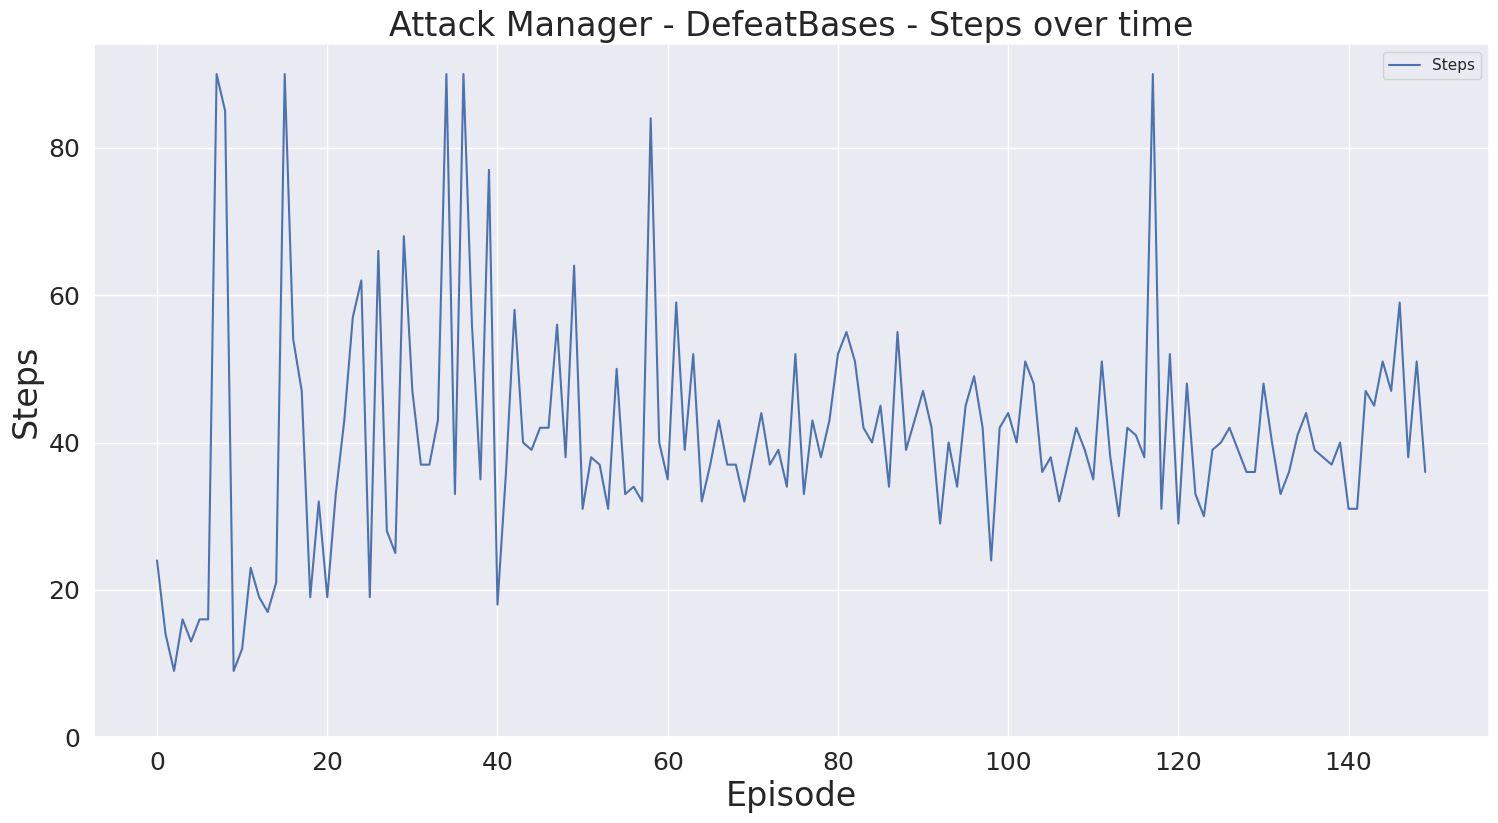

In [95]:
plot_steps_over_time(stages=["TRAINING"], **plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


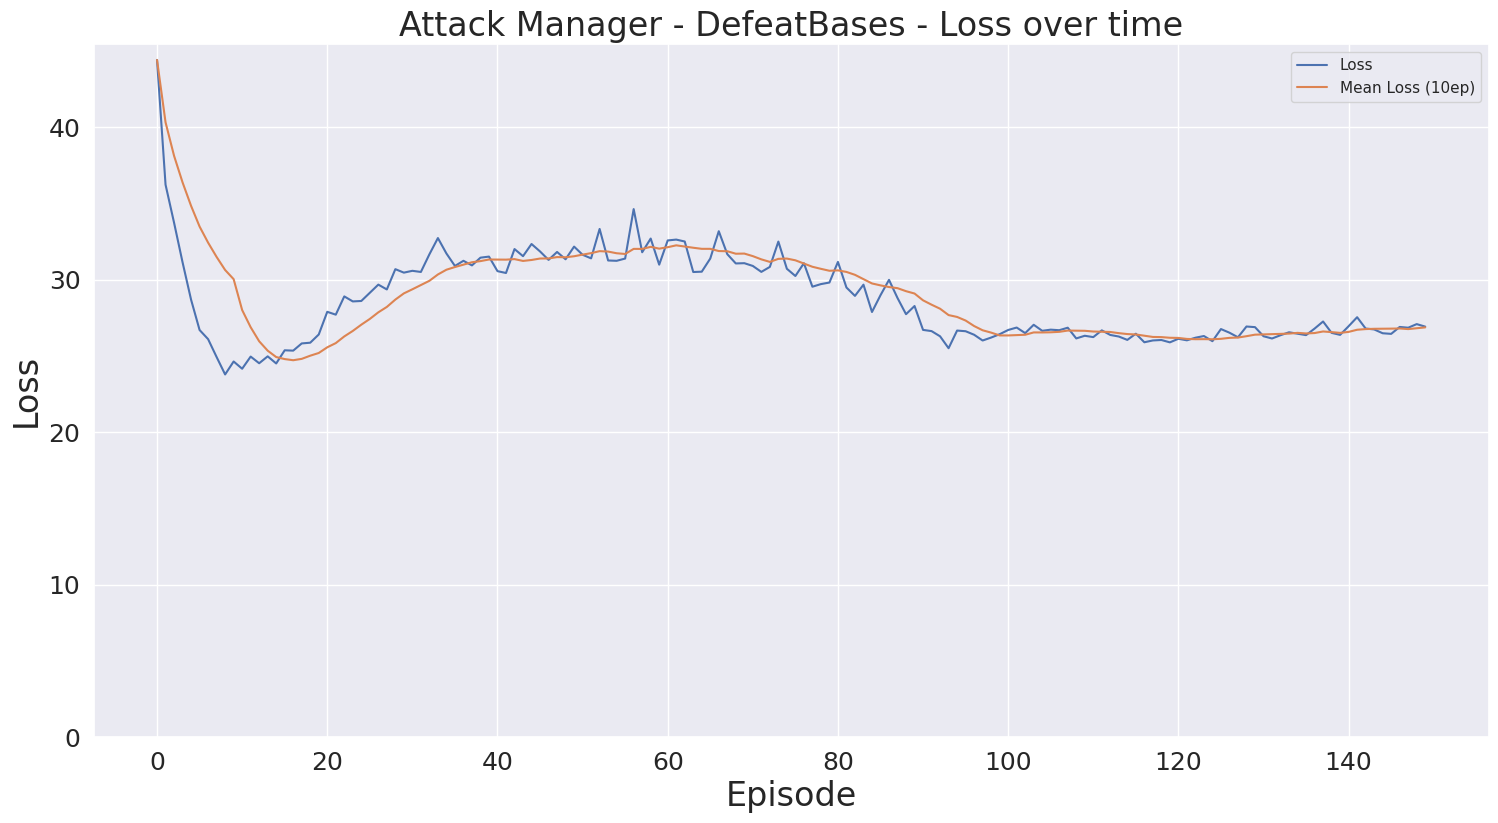

Plotting only TRAINING episodes


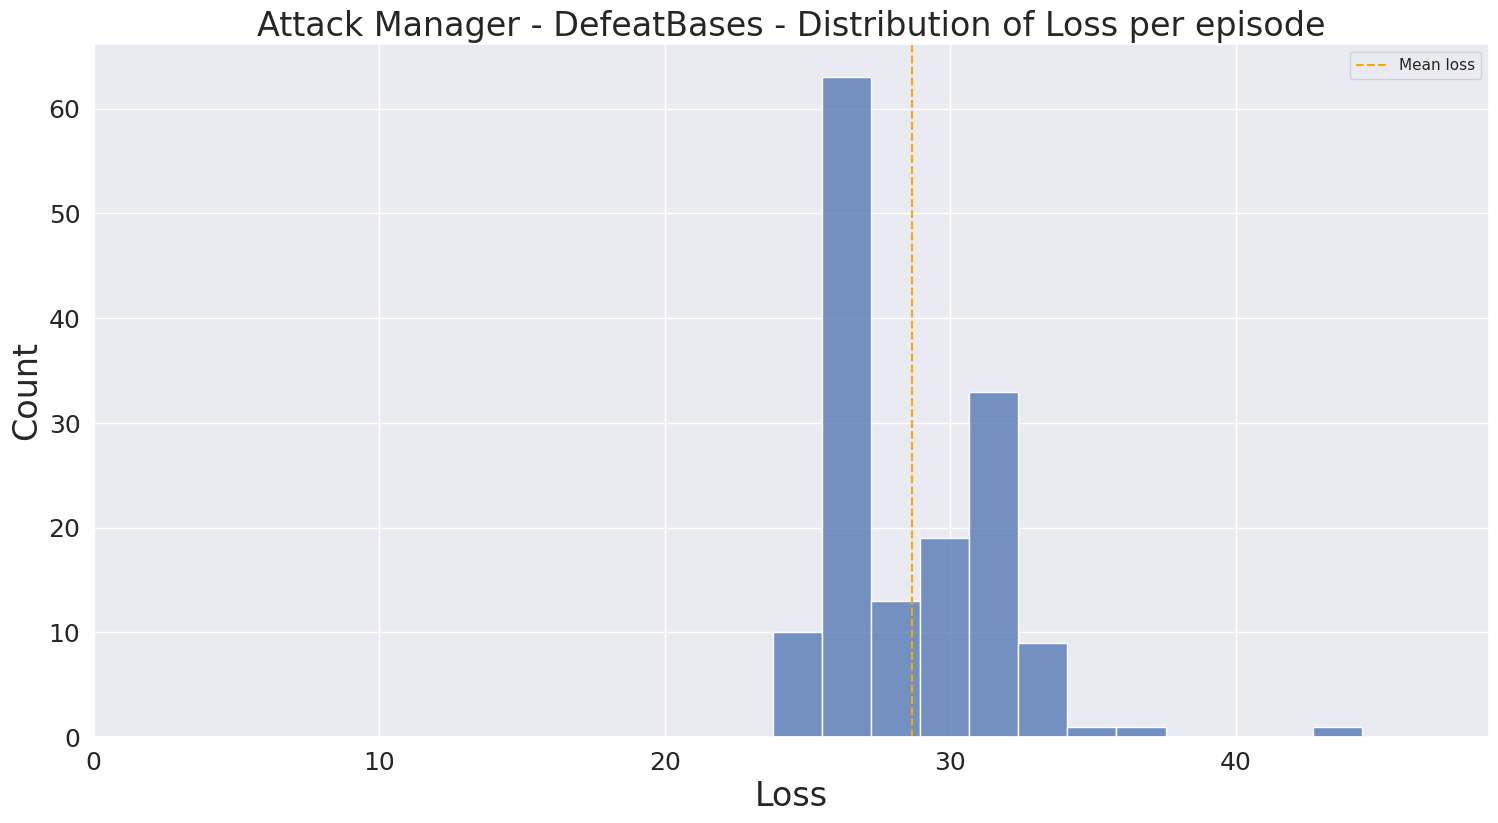

In [96]:
plot_losses(**plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


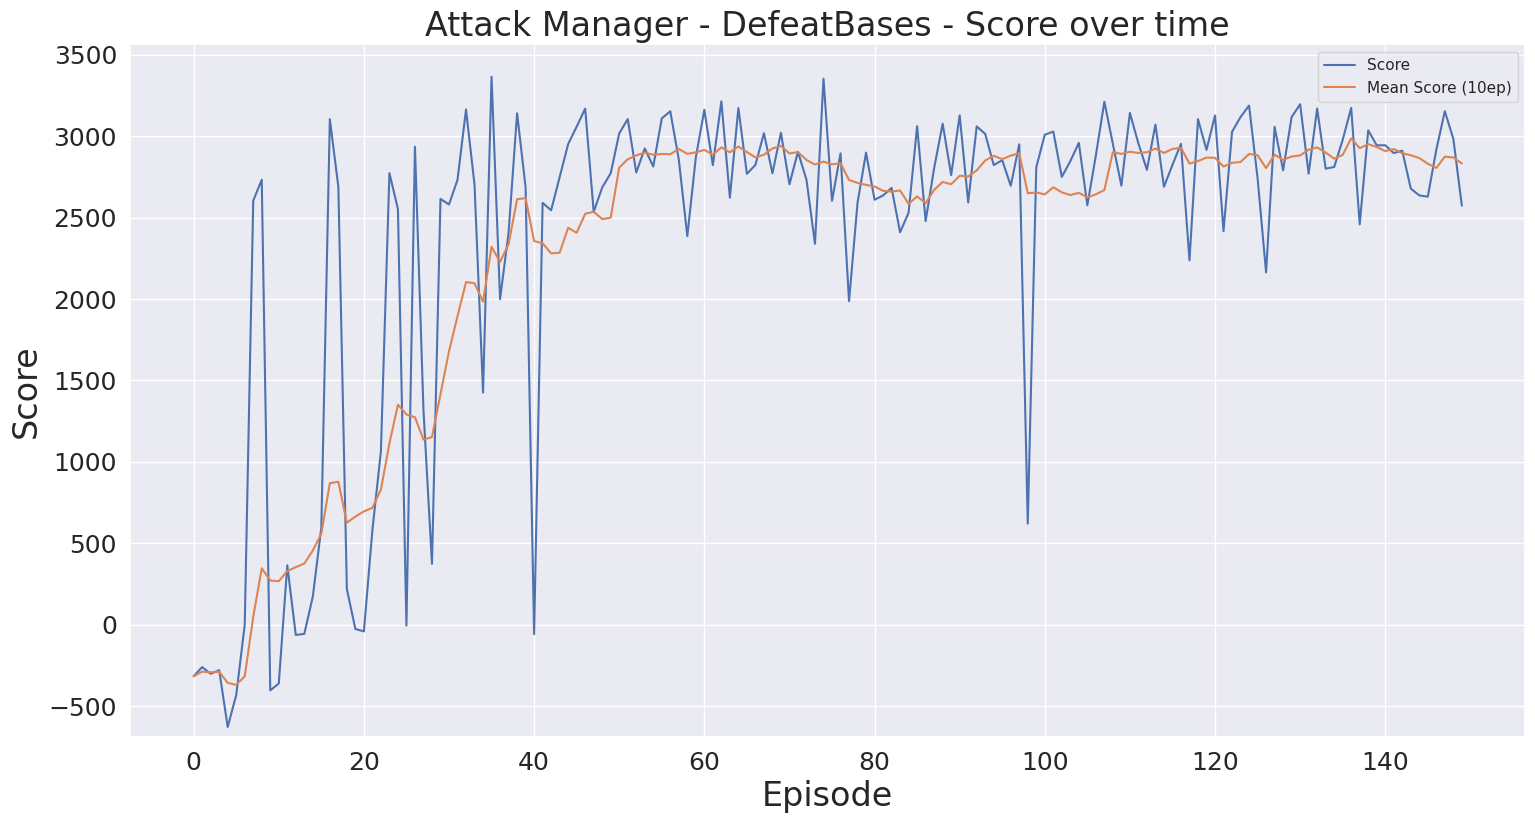

Plotting only TRAINING episodes


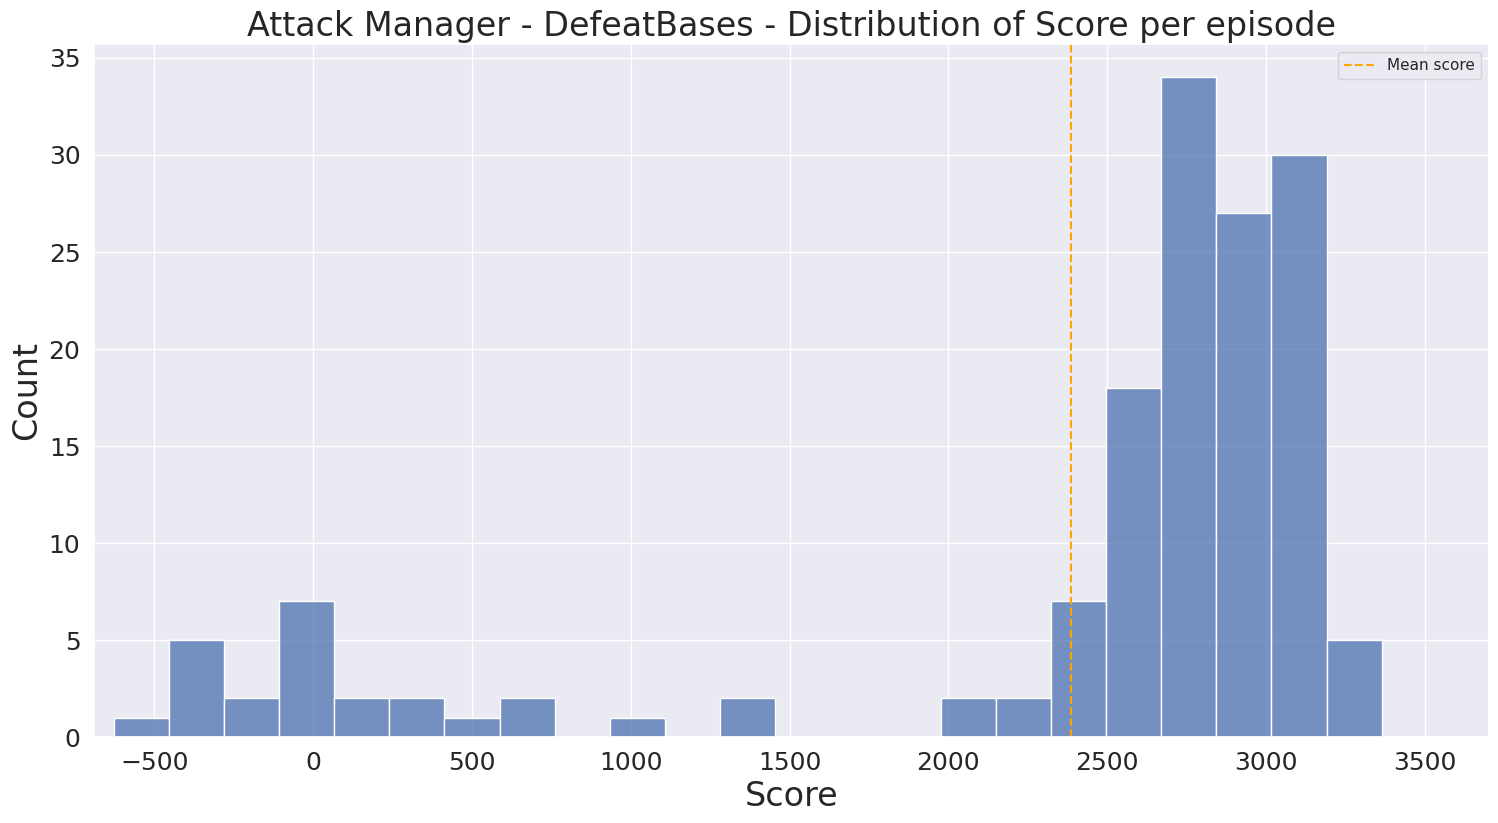

In [97]:
plot_scores(stages=["TRAINING"], **plot_args) ;

Plotting only TRAINING episodes


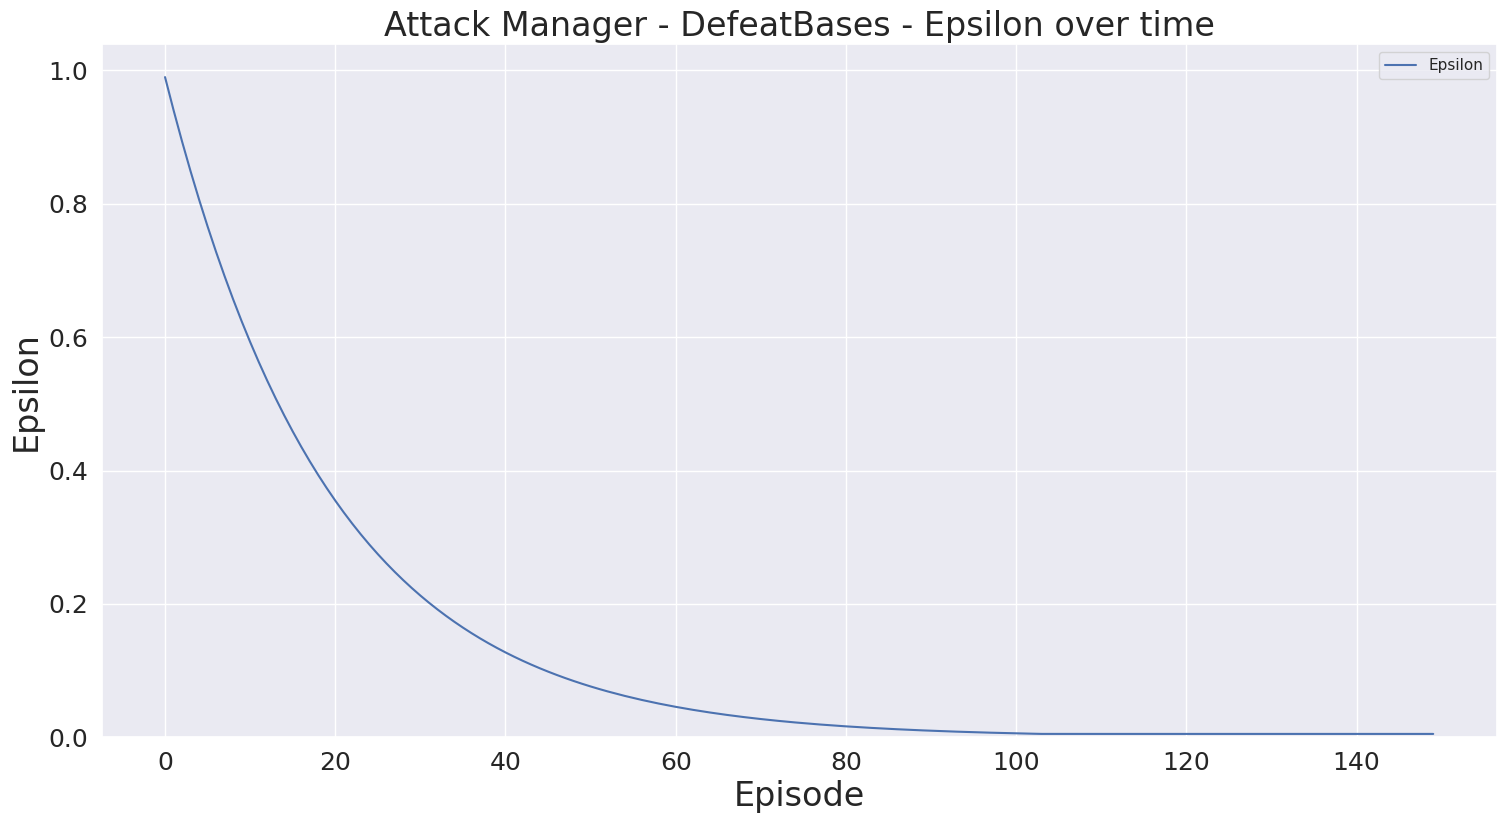

In [98]:
plot_epsilon(**plot_args) ;

### Score reward scheme Exploit

In [99]:
experiment_path = models_path / "best_32"

scenario_name = "DefeatBases"
model_suffix = f"multi_dqn_army_attack_manager"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Attack Manager - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 250
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 150
Total exploit episodes: 100
Unique maps in episode stats:  ['DefeatBases']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps  epsilon losses  emissions  \
245  DefeatBases       0             -3.0     30      0.0     []        0.0   
246  DefeatBases       0             -4.0     40      0.0     []        0.0   
247  DefeatBases       0             -3.3     33      0.0     []        0.0   
248  DefeatBases       0             -2.9     29      0.0     []        0.0   
249  DefeatBases       0             -3.6     36      0.0     []        0.0   

      score  is_burnin  is_training  is_exploit  is_random_mode initial_stage  \
245  3167.7      False        False        True           False       EXPLOIT   
246  2698.9      False        False        True           False       EXPLOIT   
247  2817.6      False        False        True           False       EXPLOIT   
248  2702.1      False        False        True           False       EXPLOIT   
249  2872.3      False        False        True           False       EXPLOIT   

    final_stage  episode  loss invalid_action_counts  \
245     EXPLOIT      245   NaN          {'dummy': 0}   
246     EXPLOIT      246   NaN          {'dummy': 0}   
247     EXPLOIT      247   NaN          {'dummy': 0}   
248     EXPLOIT      248   NaN          {'dummy': 0}   
249     EXPLOIT      249   NaN          {'dummy': 0}   

                                   valid_action_counts  mean_loss_10ep  \
245  {'ATTACK_ARMY': 2.0, 'ATTACK_BUILDINGS': 3.0, ...             NaN   
246  {'ATTACK_ARMY': 4.0, 'ATTACK_BUILDINGS': 6.0, ...             NaN   
247  {'ATTACK_ARMY': 2.0, 'ATTACK_BUILDINGS': 3.0, ...             NaN   
248  {'ATTACK_ARMY': 3.0, 'ATTACK_BUILDINGS': 5.0, ...             NaN   
249  {'ATTACK_ARMY': 6.0, 'ATTACK_BUILDINGS': 4.0, ...             NaN   

     mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
245               0.0                      -3.52          2926.90   
246               0.0                      -3.54          2904.99   
247               0.0                      -3.42          2910.36   
248               0.0                      -3.39          2875.69   
249               0.0                      -3.44          2855.47   

     mean_emissions_10ep  accumulated_emissions  
245                  0.0               0.070848  
246                  0.0               0.070848  
247                  0.0               0.070848  
248                  0.0               0.070848  
249                  0.0               0.070848

/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


Plotting only EXPLOIT episodes


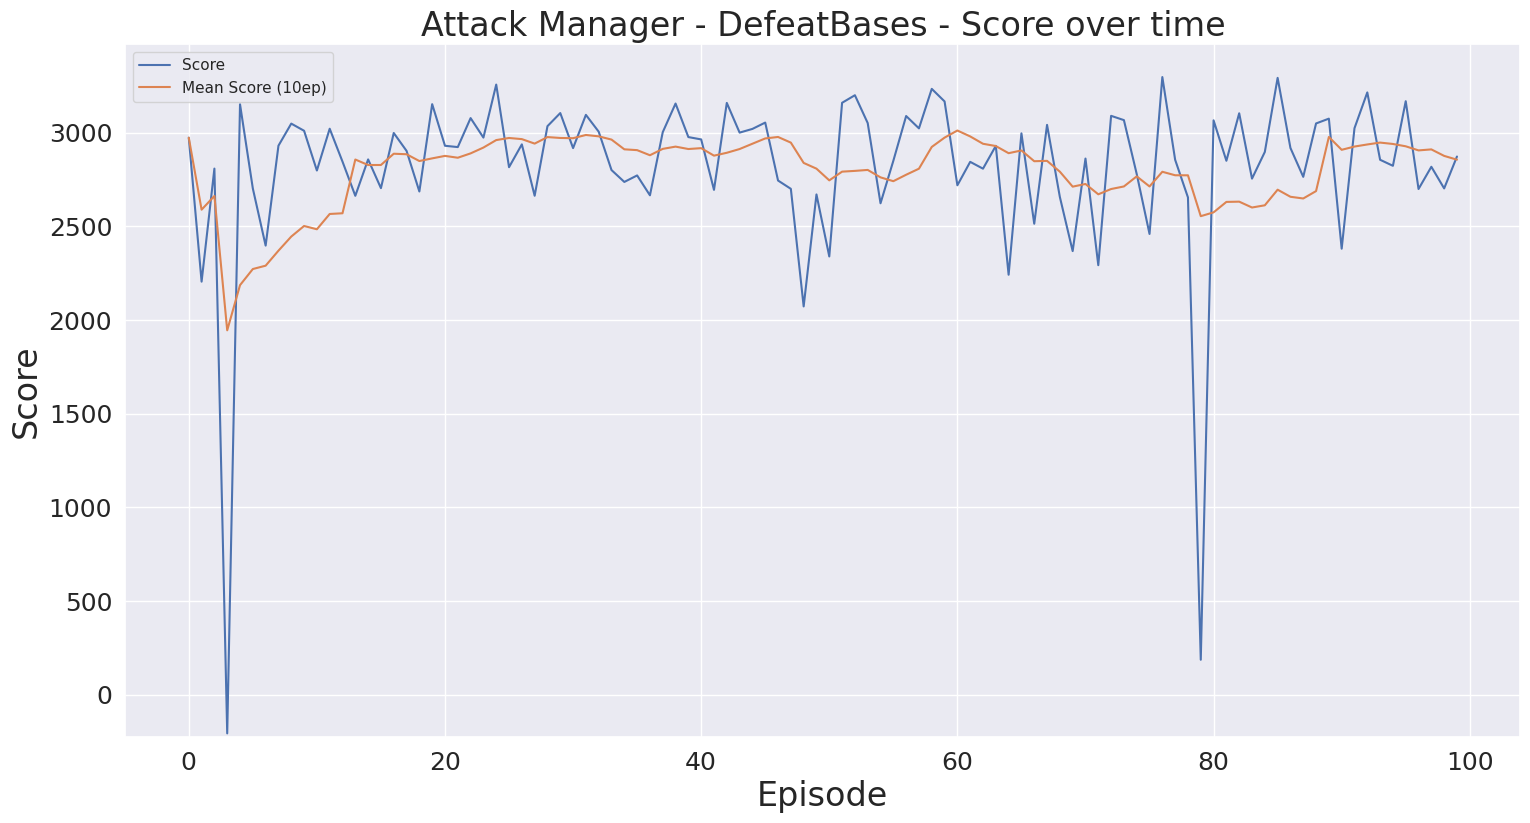

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


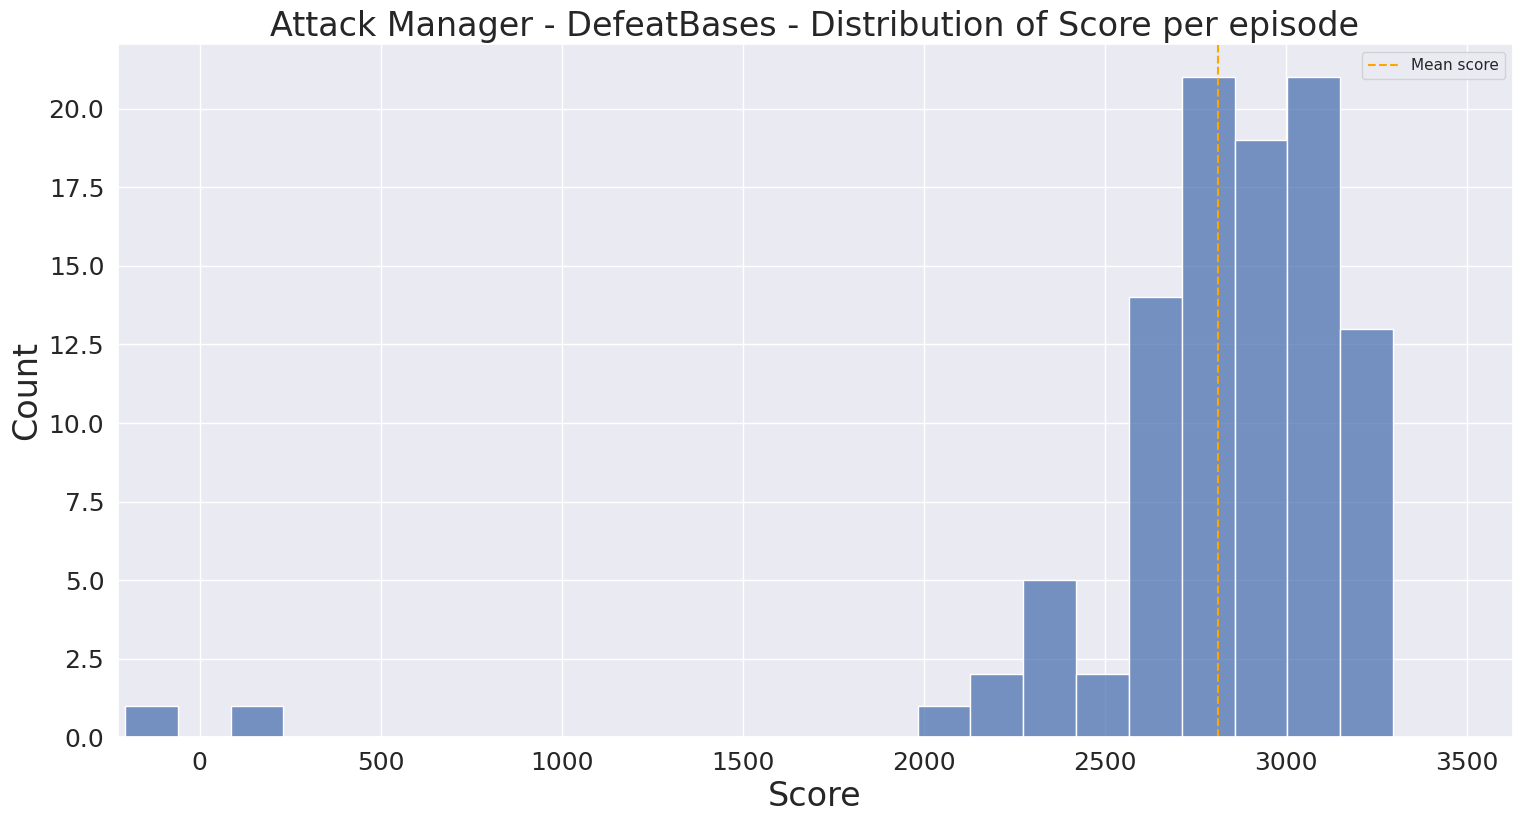

In [100]:
plot_scores(stages=["EXPLOIT"], **plot_args) ;

## Game Manager

### Score reward scheme Fine Tuning

In [101]:
experiment_path = models_path / "best_32"

scenario_name = "Simple64"
model_suffix = f"multi_dqn_game_manager_fine_tune"
model_path = experiment_path / model_suffix
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Game Manager (fine tuning) - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 32
Total burnin episodes: 12
Total random mode episodes: 0
Total training episodes: 20
Total exploit episodes: 0
Unique maps in episode stats:  ['Simple64']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps   epsilon  \
27  Simple64      -1             -5.5     45  0.185926   
28  Simple64       1             -7.4     84  0.166311   
29  Simple64       1             -5.3     63  0.148765   
30  Simple64       1             -5.7     67  0.133070   
31  Simple64       1             -5.5     65  0.119031   

                                               losses  emissions  \
27  [74.11408996582031, 93.74627685546875, 87.1754...   0.009491   
28  [70.25383758544922, 75.85627746582031, 81.0598...   0.017194   
29  [92.84410858154297, 81.52091217041016, 98.5671...   0.012743   
30  [84.92218017578125, 77.37557220458984, 67.2875...   0.015784   
31  [93.02257537841797, 73.74385833740234, 84.6720...   0.013542   

           score  is_burnin  is_training  is_exploit  is_random_mode  \
27 -11150.000000      False         True       False           False   
28   4791.568627      False         True       False           False   
29   5850.000000      False         True       False           False   
30   5368.823529      False         True       False           False   
31   5725.098039      False         True       False           False   

   initial_stage final_stage  episode       loss invalid_action_counts  \
27      TRAINING    TRAINING       27  79.398100          {'dummy': 0}   
28      TRAINING    TRAINING       28  80.136601          {'dummy': 0}   
29      TRAINING    TRAINING       29  81.327768          {'dummy': 0}   
30      TRAINING    TRAINING       30  85.088045          {'dummy': 0}   
31      TRAINING    TRAINING       31  84.411033          {'dummy': 0}   

                                  valid_action_counts  mean_loss_10ep  \
27  {'ATTACK': 196, 'EXPAND_ARMY': 130, 'EXPAND_BA...       81.917507   
28  {'ATTACK': 326, 'EXPAND_ARMY': 320, 'EXPAND_BA...       81.276628   
29  {'ATTACK': 184, 'EXPAND_ARMY': 260, 'EXPAND_BA...       81.063207   
30  {'ATTACK': 202, 'EXPAND_ARMY': 280, 'EXPAND_BA...       81.290143   
31  {'ATTACK': 128, 'EXPAND_ARMY': 220, 'EXPAND_BA...       81.247552   

    mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
27               0.6                      -6.32      1880.647059   
28               0.6                      -6.41      1834.803922   
29               0.6                      -6.11      1984.803922   
30               0.6                      -6.13      1954.294118   
31               0.6                      -6.12      1986.294118   

    mean_emissions_10ep  accumulated_emissions  
27             0.011390               0.188158  
28             0.012171               0.205352  
29             0.012103               0.218095  
30             0.012795               0.233878  
31             0.013223               0.247420

In [102]:
emission_stats.iloc[-1]

timestamp                                           2024-12-13 13:52:43
project_name                                                 codecarbon
run_id                             ea7a8277-24fa-48d3-af10-bfa4bf23a4fd
duration                                                    1650.779344
emissions                                                      0.002742
emissions_rate                                                 0.000002
cpu_power                                                          32.5
gpu_power                                                           0.0
ram_power                                                      2.888793
cpu_energy                                                     0.014903
gpu_energy                                                            0
ram_energy                                                     0.001325
energy_consumed                                                0.016227
country_name                                                    

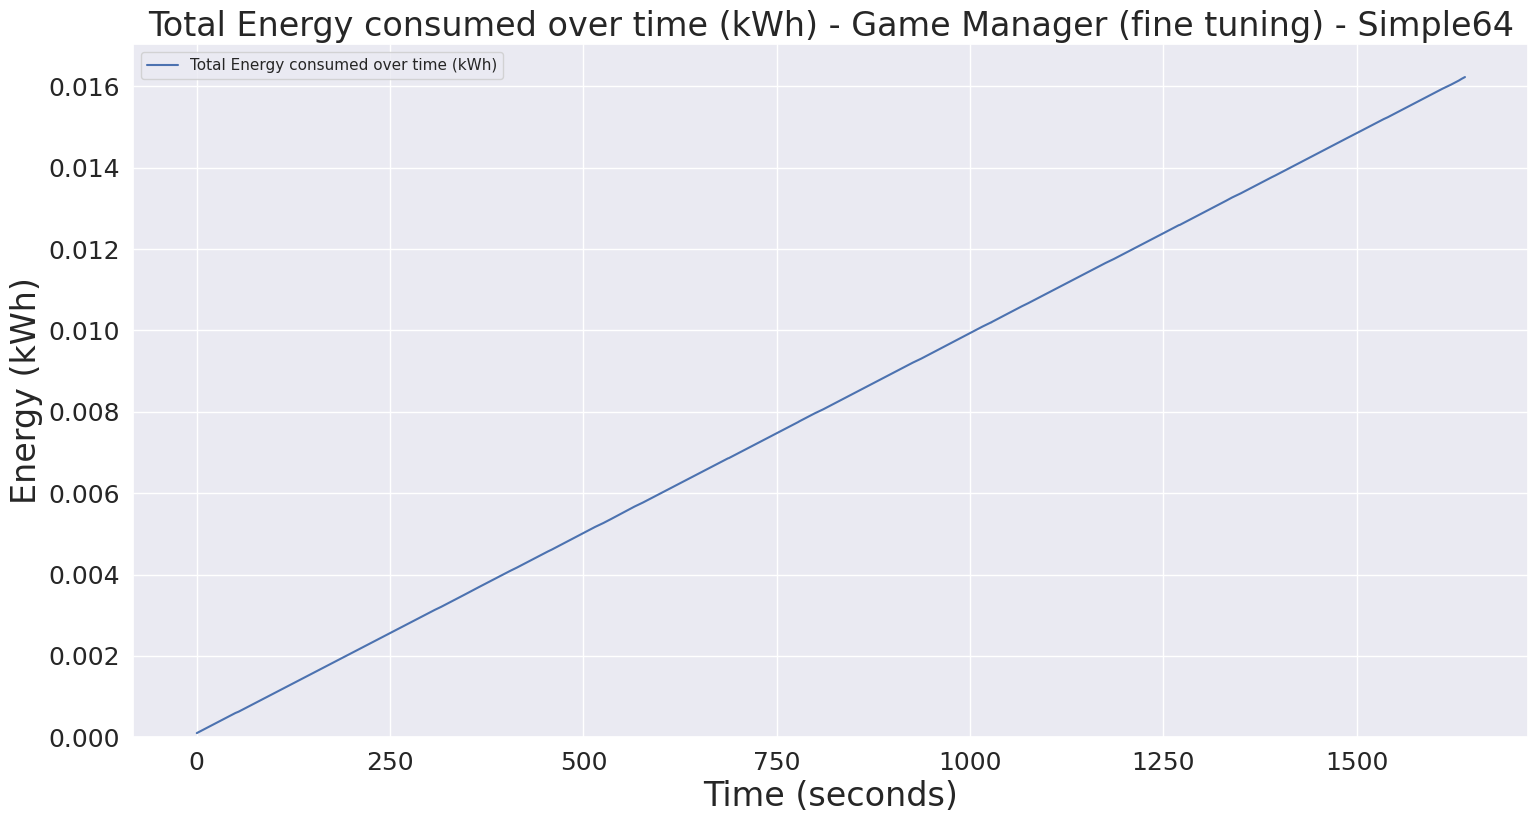

In [103]:
plot_emissions(emission_stats, save_images_path, model_name) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


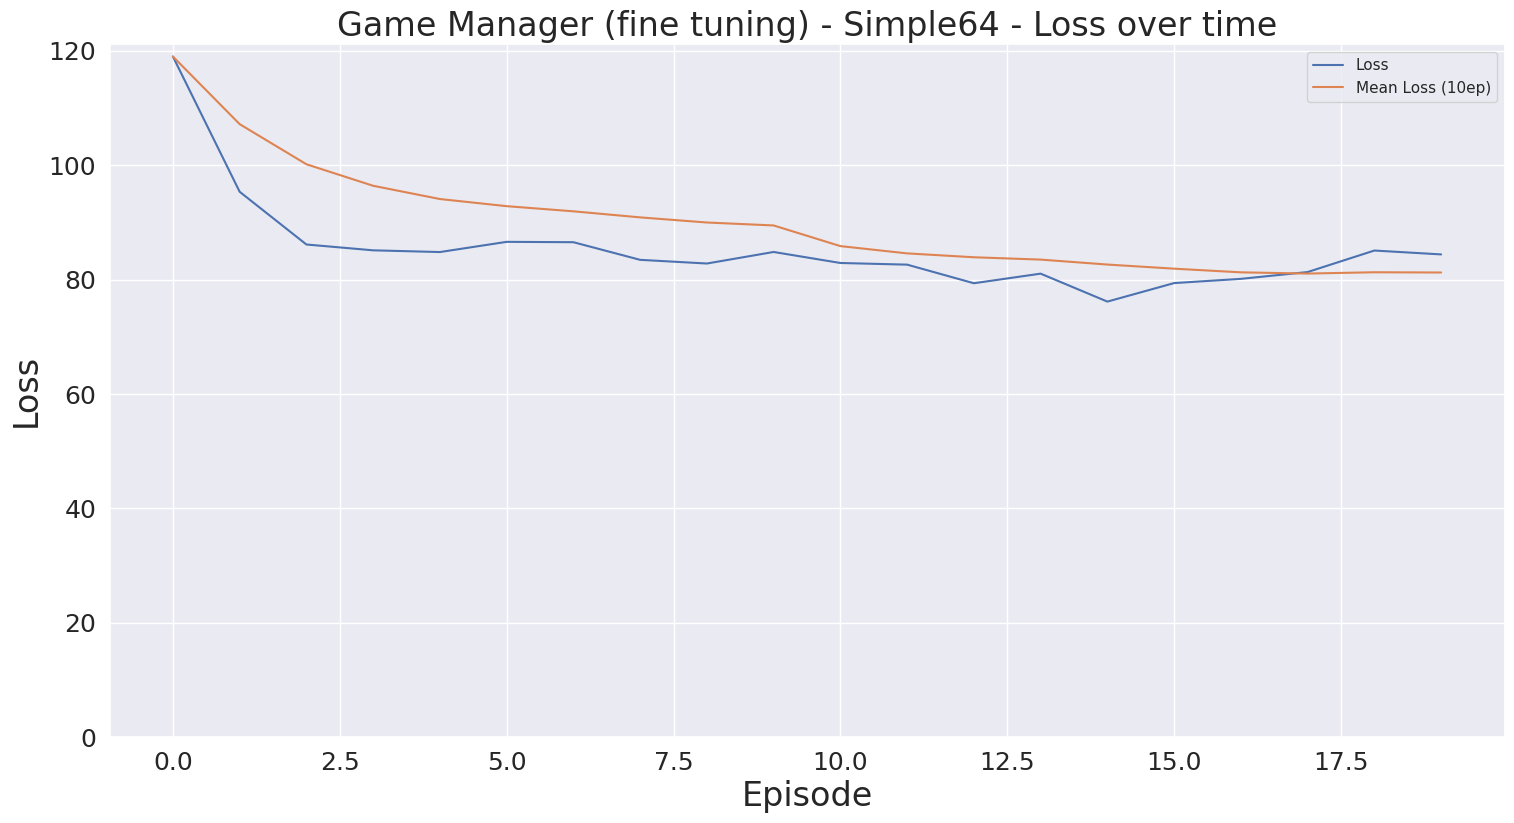

Plotting only TRAINING episodes


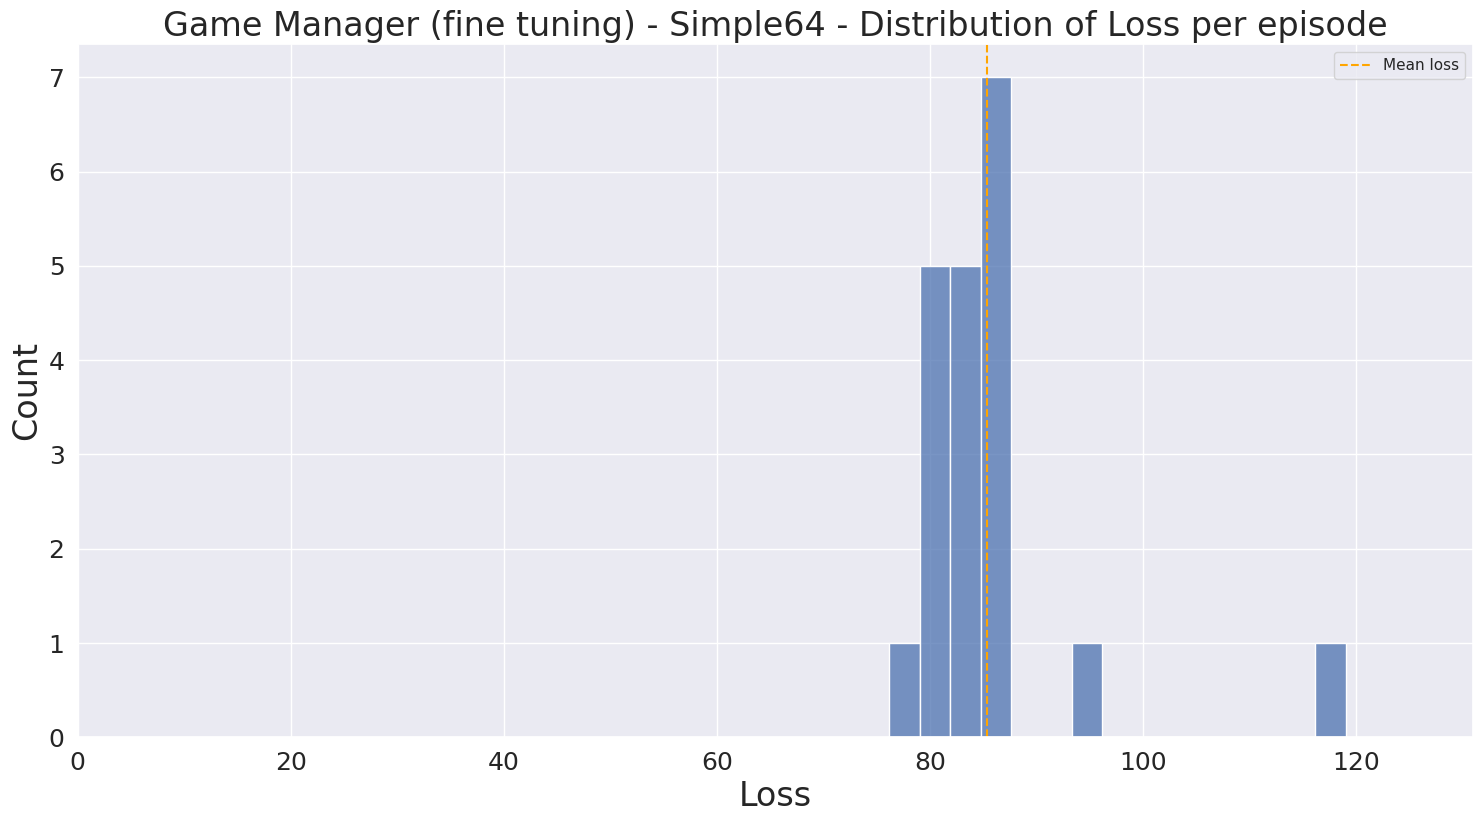

In [104]:
plot_losses(**plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


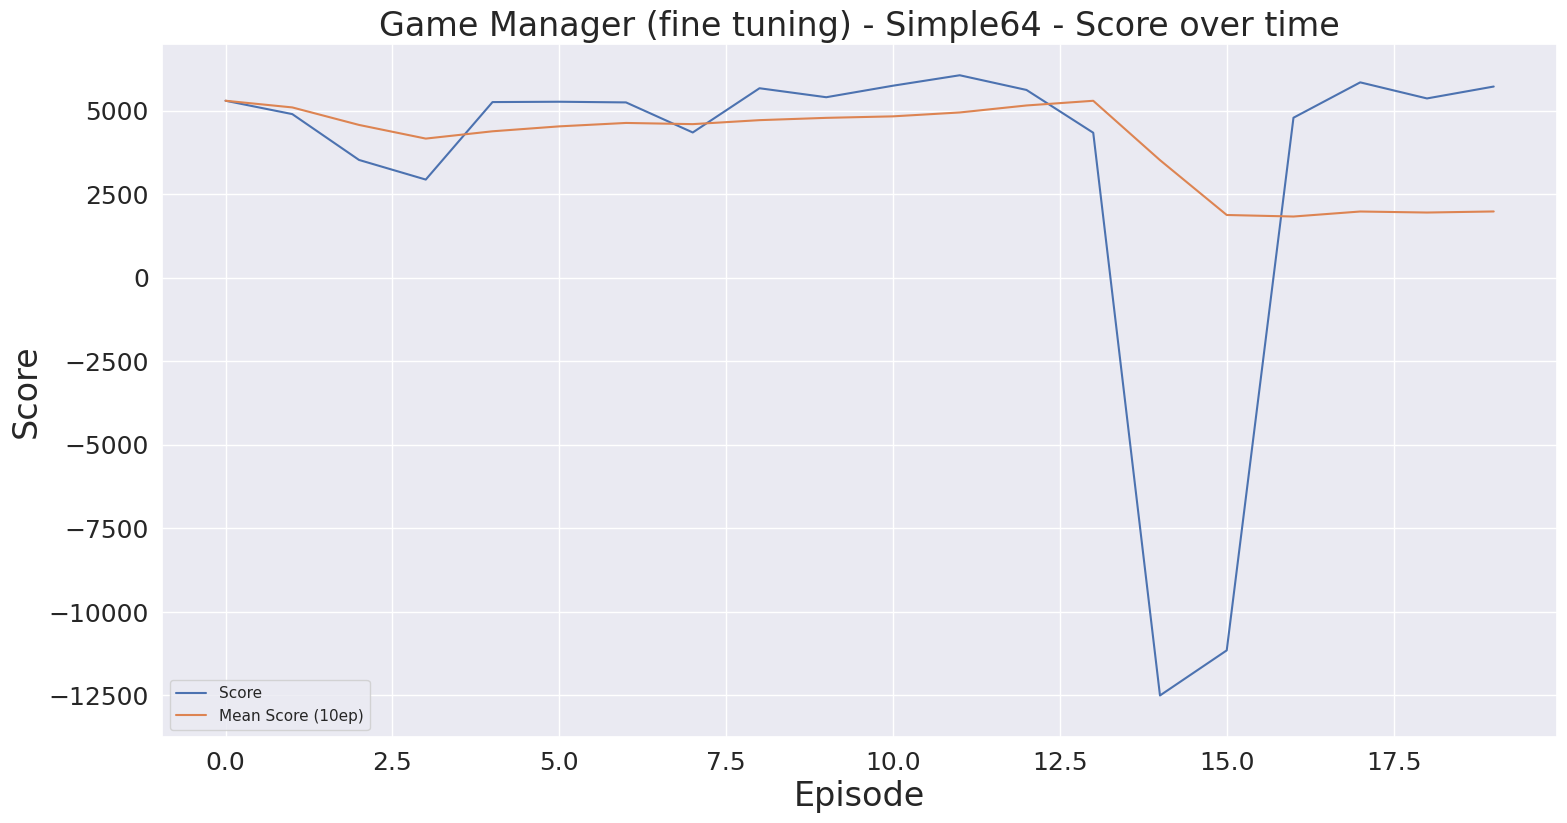

Plotting only TRAINING episodes


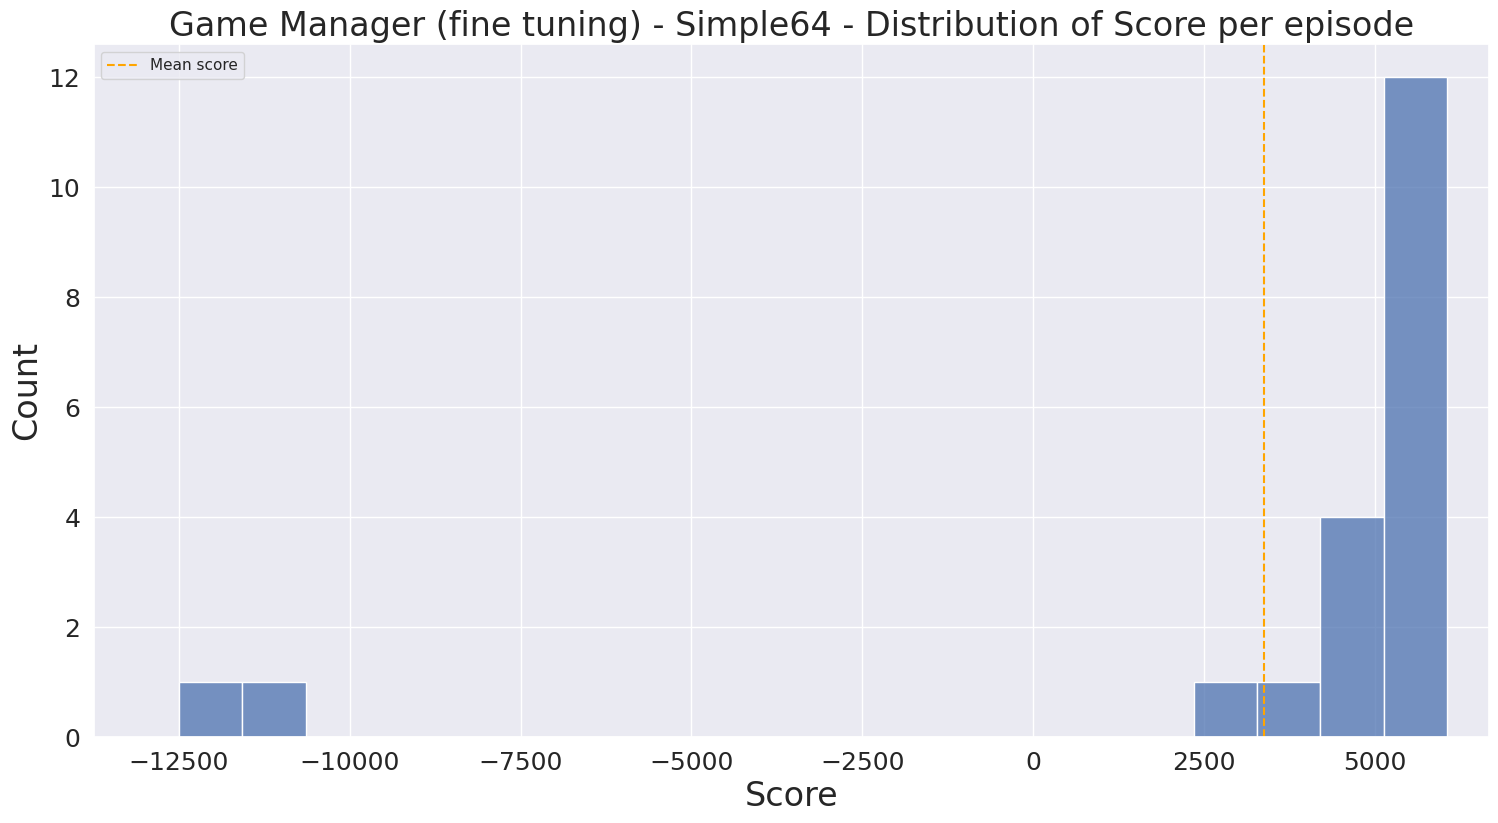

In [105]:
plot_scores(stages=["TRAINING"], **plot_args) ;

### Score reward scheme Training

In [106]:
experiment_path = models_path / "best_32"

scenario_name = "Simple64"
model_suffix = f"multi_dqn_game_manager"
model_path = experiment_path / model_suffix
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Game Manager - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 40
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 40
Total exploit episodes: 0
Unique maps in episode stats:  ['Simple64']


map_name  reward  adjusted_reward  steps   epsilon  \
35  Simple64       1             -5.8     68  0.002404   
36  Simple64       1             -5.6     66  0.002150   
37  Simple64       1             -4.9     59  0.002000   
38  Simple64       1             -5.5     65  0.002000   
39  Simple64       0            -35.5    355  0.002000   

                                               losses  emissions  \
35  [145.9962615966797, 119.25906372070312, 112.88...   0.014162   
36  [134.6137237548828, 145.19781494140625, 140.86...   0.014414   
37  [148.86680603027344, 134.41644287109375, 152.0...   0.014639   
38  [158.6420440673828, 144.364501953125, 136.7849...   0.014845   
39  [123.3602523803711, 145.5705108642578, 153.542...   0.069922   

           score  is_burnin  is_training  is_exploit  is_random_mode  \
35   5550.000000      False         True       False           False   
36   5700.000000      False         True       False           False   
37   5995.098039      False         True       False           False   
38   5750.000000      False         True       False           False   
39 -13922.254902      False         True       False           False   

   initial_stage final_stage  episode        loss invalid_action_counts  \
35      TRAINING    TRAINING       35  132.963652          {'dummy': 0}   
36      TRAINING    TRAINING       36  135.998269          {'dummy': 0}   
37      TRAINING    TRAINING       37  137.594138          {'dummy': 0}   
38      TRAINING    TRAINING       38  139.535877          {'dummy': 0}   
39      TRAINING    TRAINING       39  140.303139          {'dummy': 0}   

                                  valid_action_counts  mean_loss_10ep  \
35  {'ATTACK': 296, 'EXPAND_ARMY': 210, 'EXPAND_BA...      122.801331   
36  {'ATTACK': 188, 'EXPAND_ARMY': 360, 'EXPAND_BA...      125.414750   
37  {'ATTACK': 240, 'EXPAND_ARMY': 200, 'EXPAND_BA...      127.729352   
38  {'ATTACK': 244, 'EXPAND_ARMY': 290, 'EXPAND_BA...      130.024291   
39  {'ATTACK': 150, 'EXPAND_ARMY': 2040, 'EXPAND_B...      131.963853   

    mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
35               0.7                     -12.65      -314.039216   
36               0.9                     -12.57      1400.960784   
37               0.9                     -12.54      1410.470588   
38               0.9                     -12.56      1418.039216   
39               0.8                     -15.34      -437.088235   

    mean_emissions_10ep  accumulated_emissions  
35             0.025256               0.408006  
36             0.025812               0.422419  
37             0.026369               0.437058  
38             0.026685               0.451904  
39             0.032228               0.521825

In [107]:
emission_stats.iloc[-1]

timestamp                                           2024-12-13 14:51:49
project_name                                                 codecarbon
run_id                             f803360e-6057-4fd5-b88e-94dbe03f558c
duration                                                    2423.833647
emissions                                                      0.004026
emissions_rate                                                 0.000002
cpu_power                                                          32.5
gpu_power                                                           0.0
ram_power                                                      2.888793
cpu_energy                                                     0.021882
gpu_energy                                                            0
ram_energy                                                     0.001945
energy_consumed                                                0.023827
country_name                                                    

In [108]:
value_counts = episode_stats[episode_stats["initial_stage"] == "TRAINING"]["reward"].value_counts()
total_lost = value_counts[-1] if -1 in value_counts else 0
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1] if 1 in value_counts else 0
total_games = total_won + total_lost + total_ties
pct_victories = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

Win rate: 85.00%
Tie rate: 5.00%
Lose rate: 10.00%


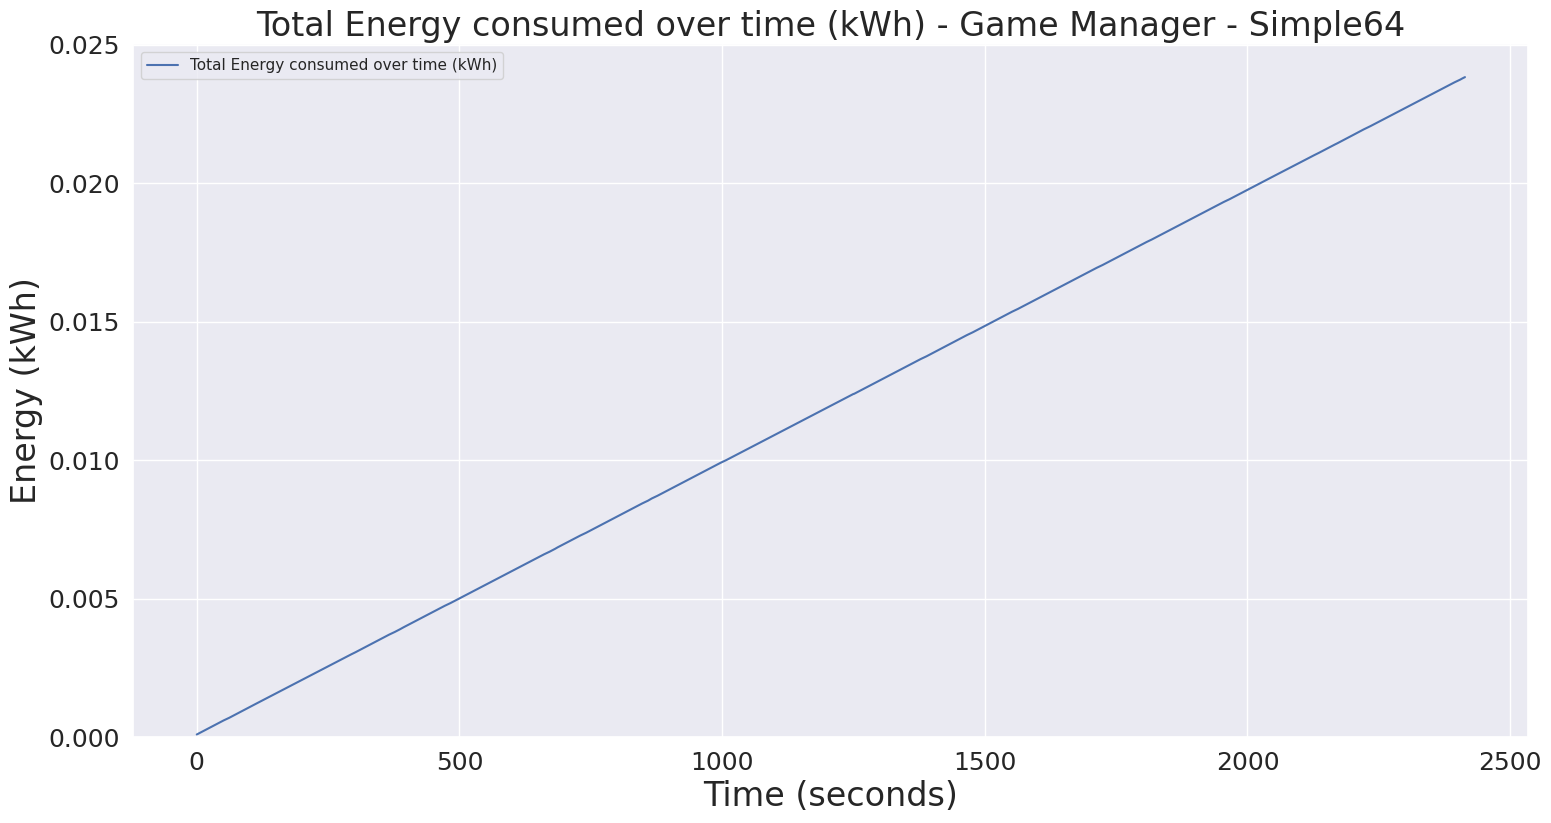

In [109]:
plot_emissions(emission_stats, save_images_path, model_name) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


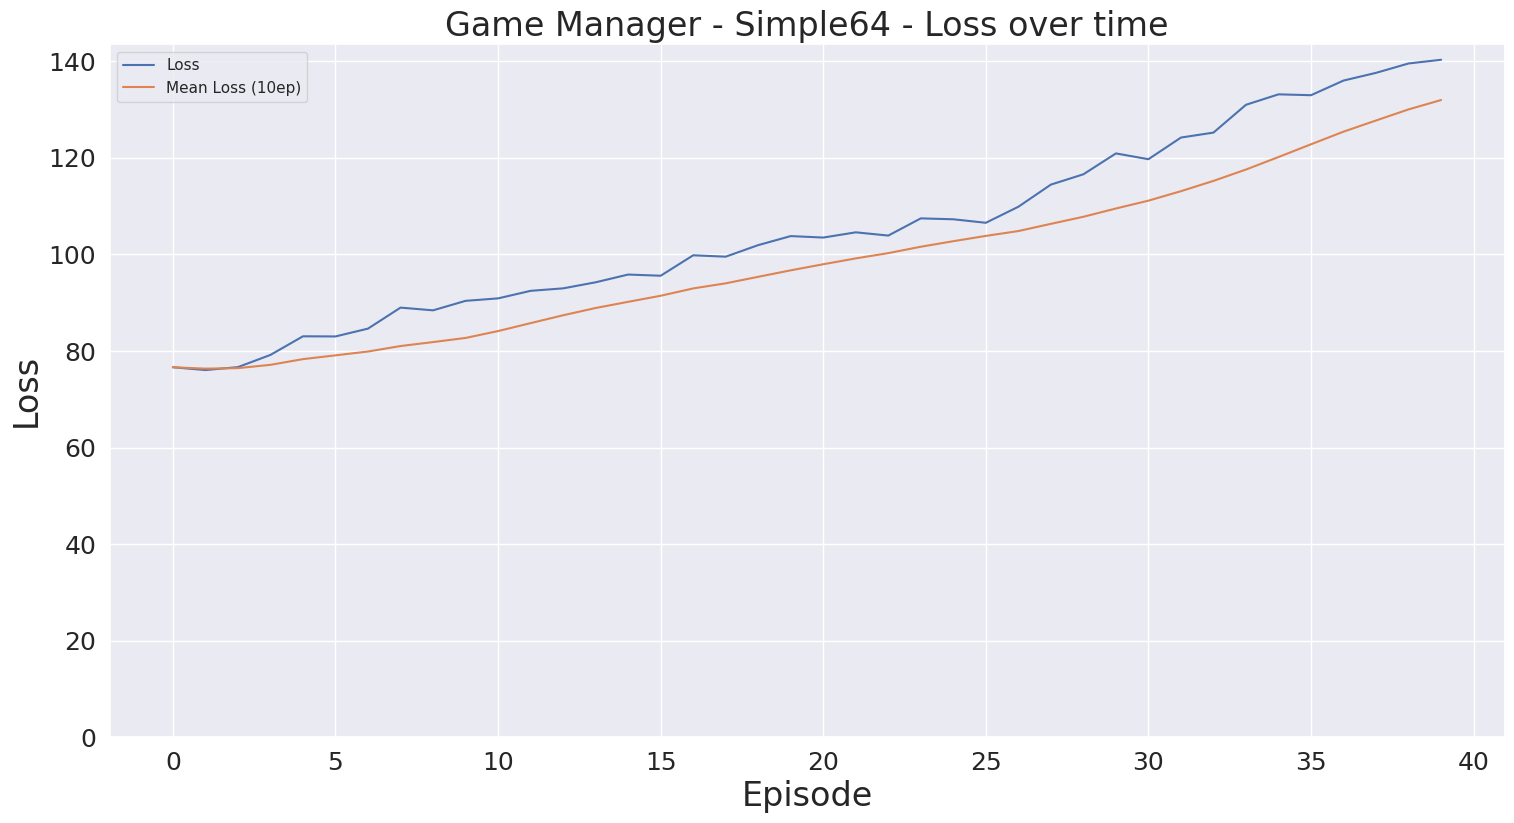

Plotting only TRAINING episodes


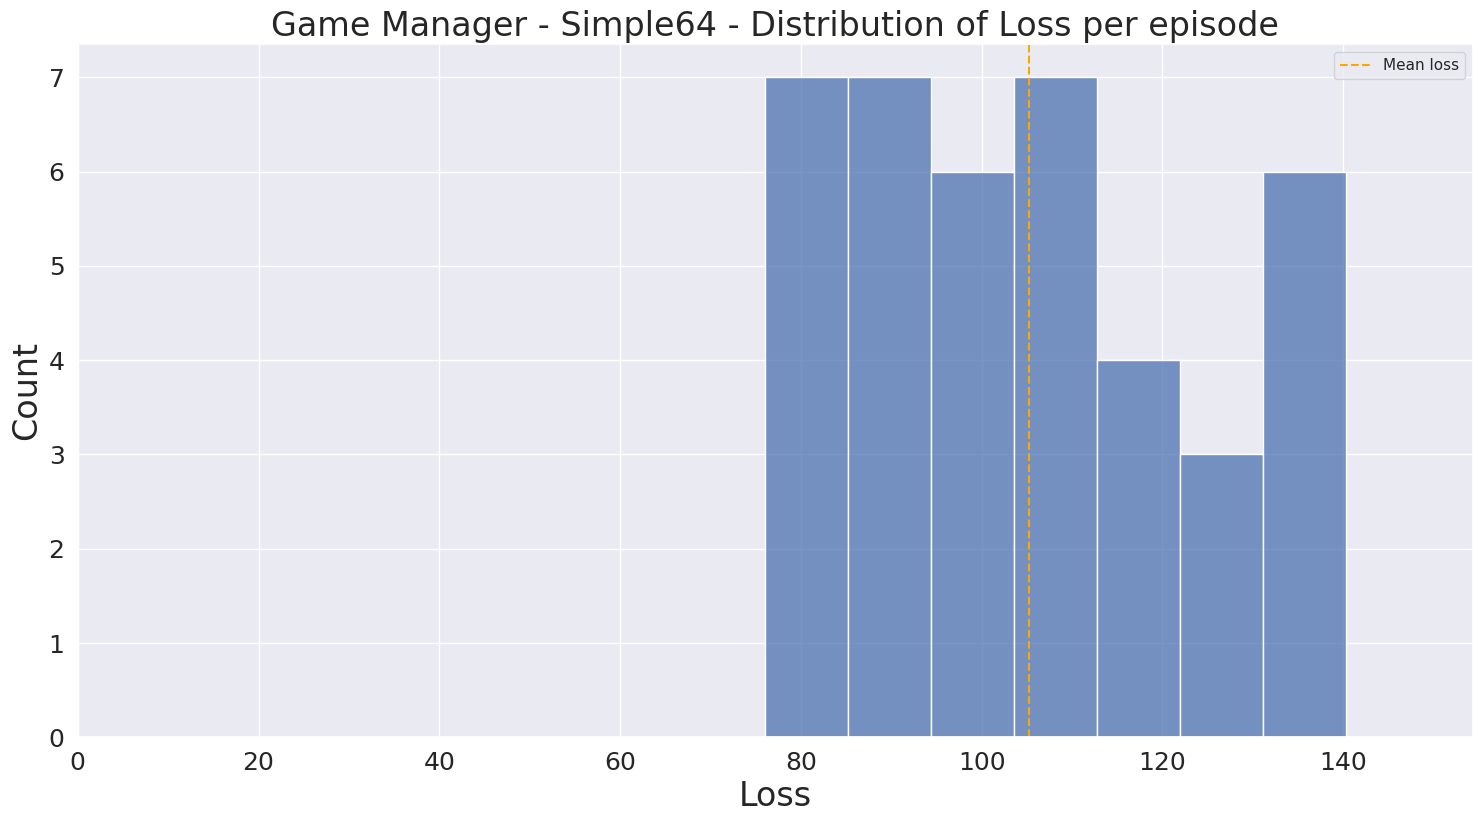

In [110]:
plot_losses(**plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


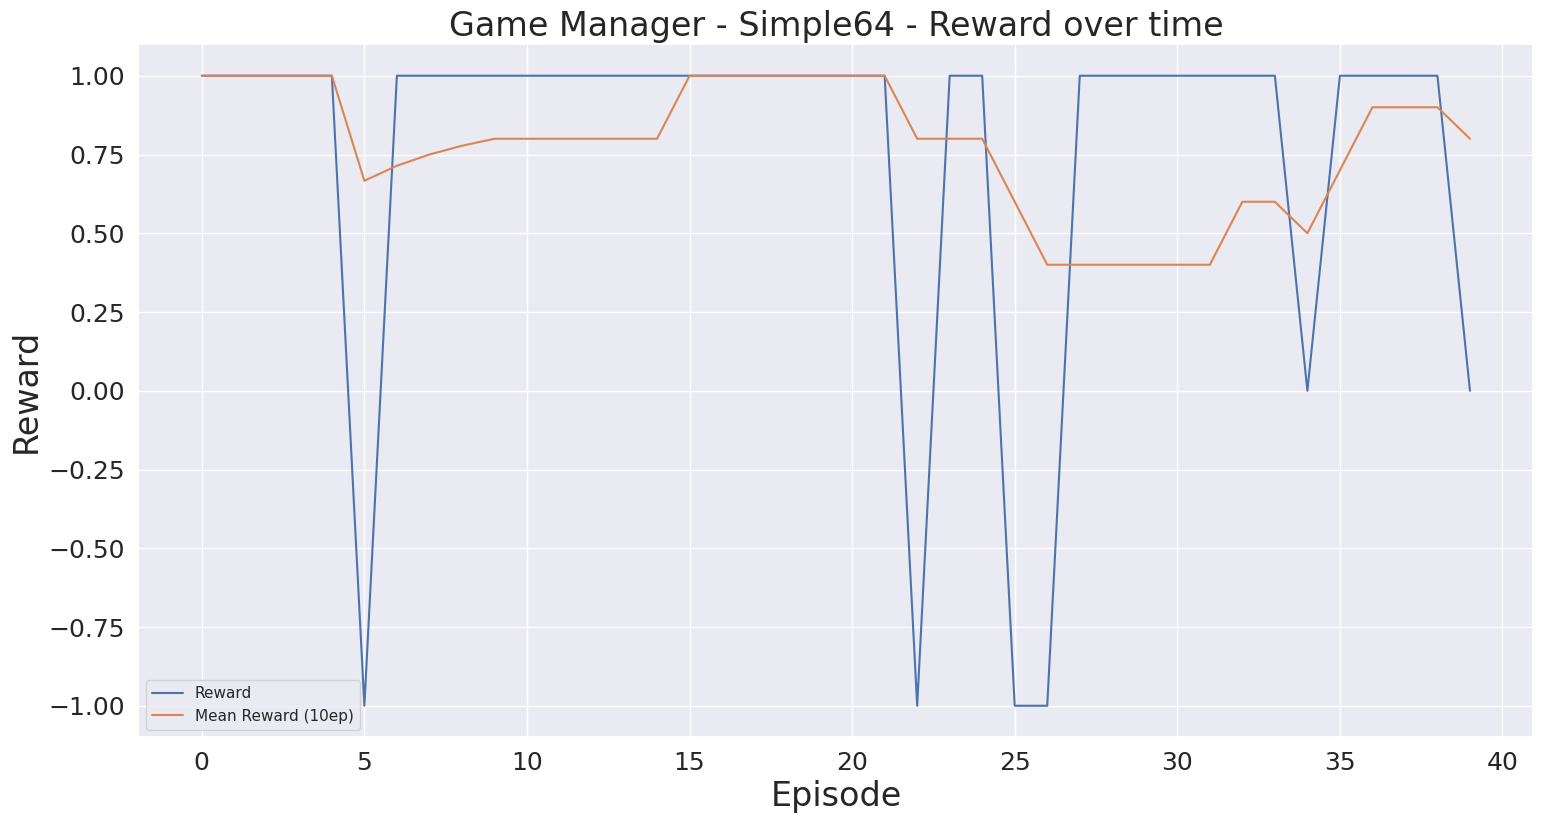

Plotting only TRAINING episodes


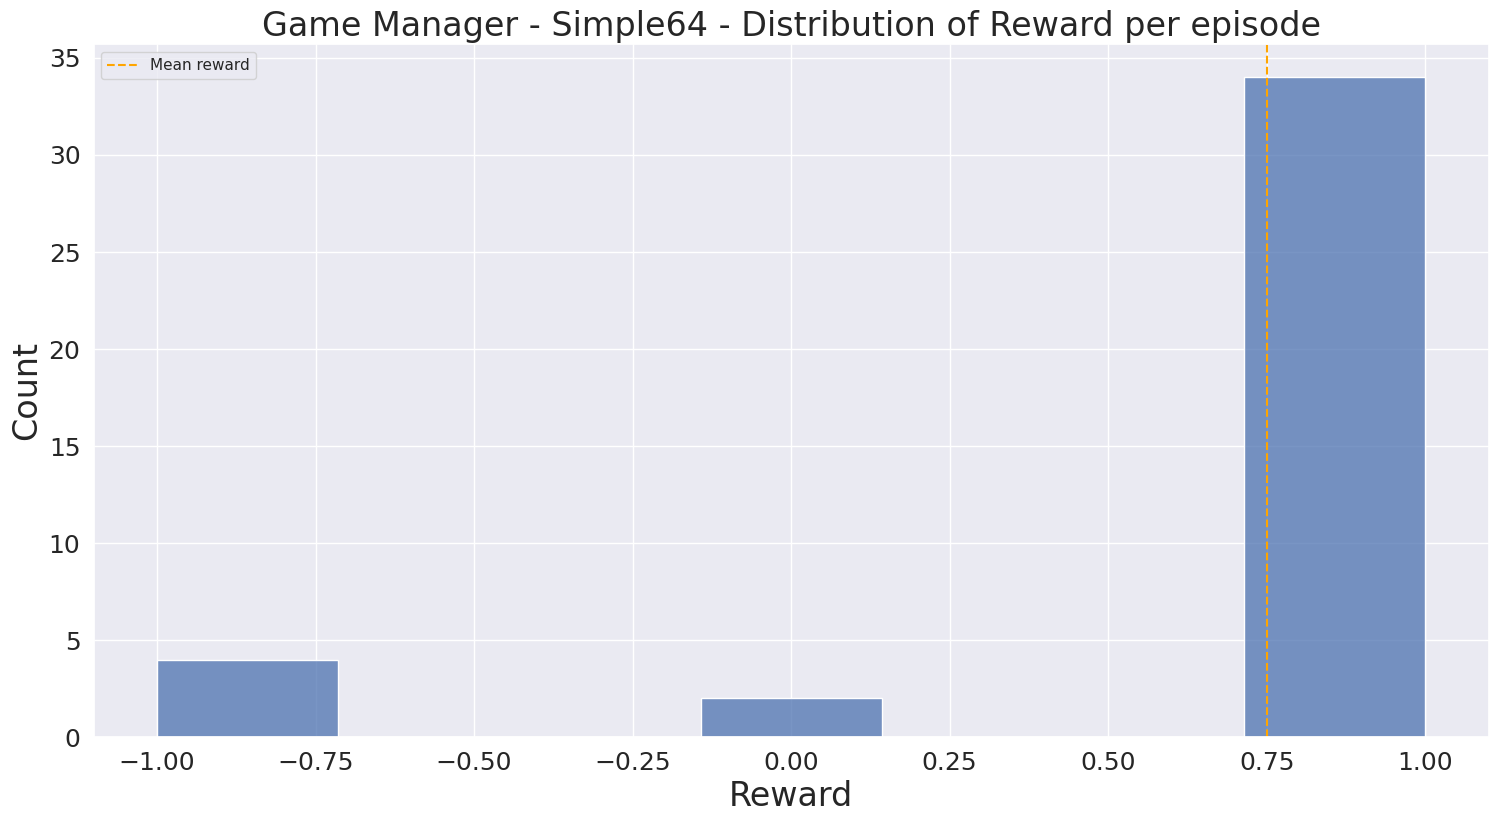

In [111]:
plot_rewards(stages=["TRAINING"], **plot_args) ;

Plotting only TRAINING episodes


/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


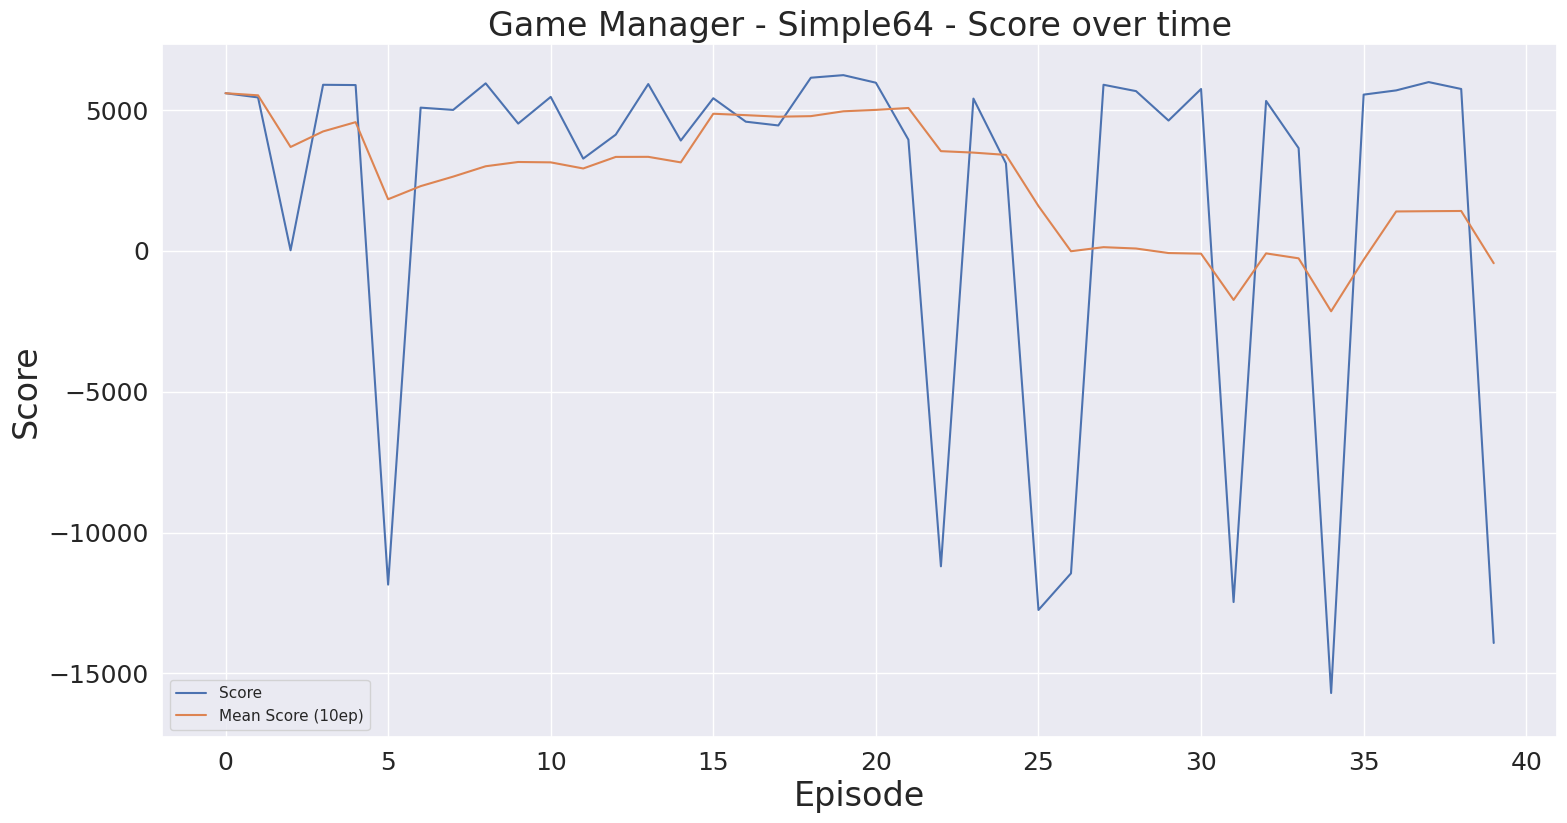

Plotting only TRAINING episodes


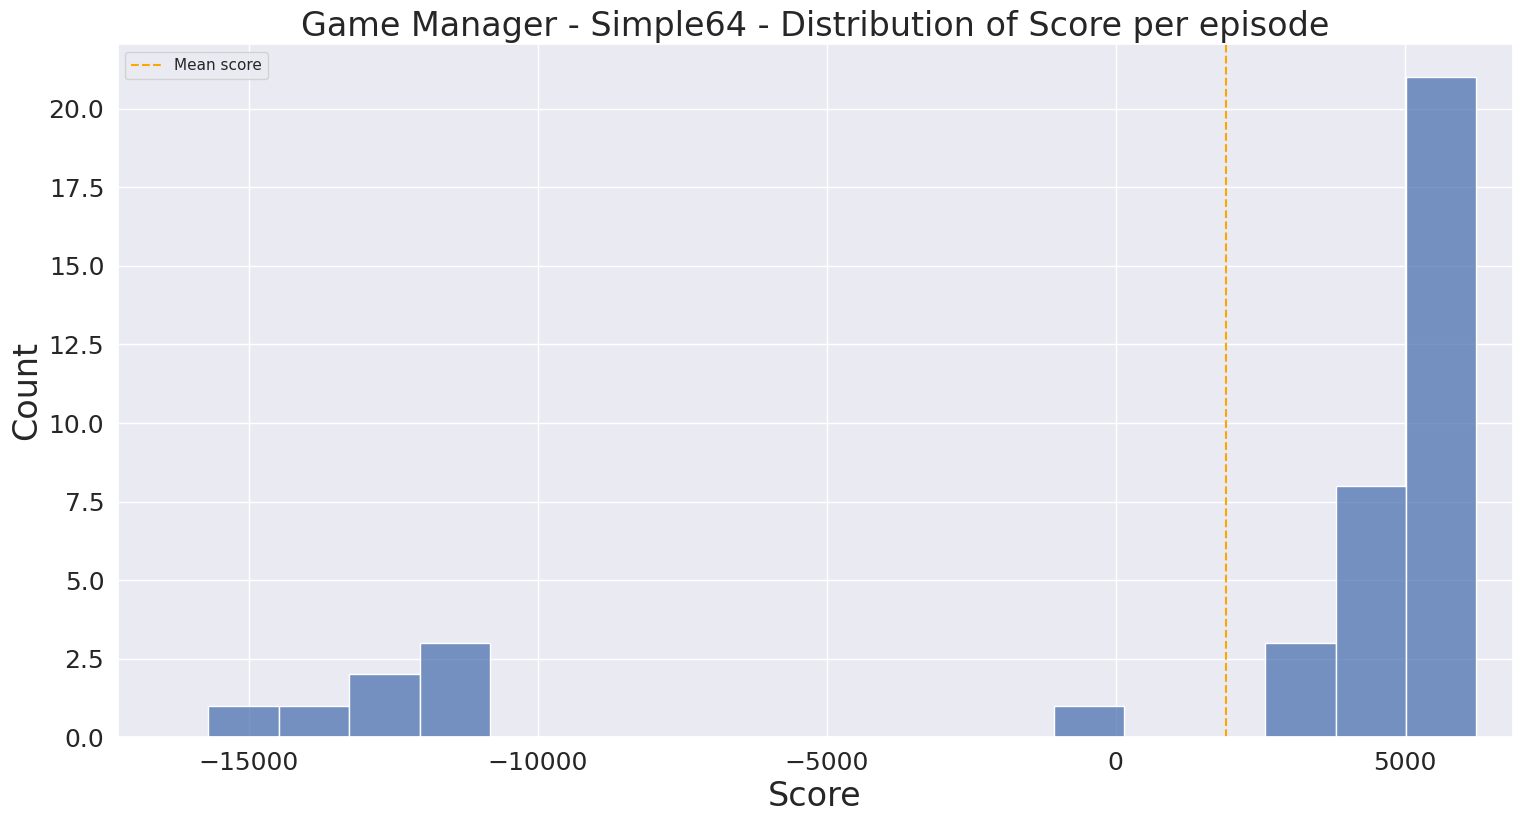

In [112]:
plot_scores(stages=["TRAINING"], **plot_args) ;

### Score reward scheme Exploit

In [113]:
experiment_path = models_path / "best_32"

scenario_name = "Simple64"
model_suffix = f"multi_dqn_game_manager"
model_path = experiment_path / model_suffix / "exploit"
save_images_path = images_path / model_suffix / "exploit"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Game Manager - {scenario_name}"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_path=model_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.tail()

Total episodes: 140
Total burnin episodes: 0
Total random mode episodes: 0
Total training episodes: 40
Total exploit episodes: 100
Unique maps in episode stats:  ['Simple64']


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


map_name  reward  adjusted_reward  steps  epsilon losses  emissions  \
135  Simple64       1             -4.7     57      0.0     []        0.0   
136  Simple64       1             -4.8     58      0.0     []        0.0   
137  Simple64       1            -20.7    217      0.0     []        0.0   
138  Simple64       1            -10.3    113      0.0     []        0.0   
139  Simple64       0            -37.2    372      0.0     []        0.0   

            score  is_burnin  is_training  is_exploit  is_random_mode  \
135   6075.098039      False        False        True           False   
136   6015.294118      False        False        True           False   
137  -2028.431373      False        False        True           False   
138   2657.107843      False        False        True           False   
139 -15475.000000      False        False        True           False   

    initial_stage final_stage  episode  loss invalid_action_counts  \
135       EXPLOIT     EXPLOIT      135   NaN          {'dummy': 0}   
136       EXPLOIT     EXPLOIT      136   NaN          {'dummy': 0}   
137       EXPLOIT     EXPLOIT      137   NaN          {'dummy': 0}   
138       EXPLOIT     EXPLOIT      138   NaN          {'dummy': 0}   
139       EXPLOIT     EXPLOIT      139   NaN          {'dummy': 0}   

                                   valid_action_counts  mean_loss_10ep  \
135  {'ATTACK': 206, 'EXPAND_ARMY': 260, 'EXPAND_BA...             NaN   
136  {'ATTACK': 210, 'EXPAND_ARMY': 290, 'EXPAND_BA...             NaN   
137  {'ATTACK': 280, 'EXPAND_ARMY': 1030, 'EXPAND_B...             NaN   
138  {'ATTACK': 612, 'EXPAND_ARMY': 400, 'EXPAND_BA...             NaN   
139  {'ATTACK': 120, 'EXPAND_ARMY': 3144, 'EXPAND_B...             NaN   

     mean_reward_10ep  mean_adjusted_reward_10ep  mean_score_10ep  \
135               0.6                      -5.98      2000.950980   
136               0.6                      -6.01      1987.852941   
137               0.8                      -7.45      2925.009804   
138               0.8                      -7.68      2750.073529   
139               0.7                     -10.93       595.416667   

     mean_emissions_10ep  accumulated_emissions  
135                  0.0               0.521825  
136                  0.0               0.521825  
137                  0.0               0.521825  
138                  0.0               0.521825  
139                  0.0               0.521825

In [114]:
value_counts = episode_stats[episode_stats["initial_stage"] == "EXPLOIT"]["reward"].value_counts()
total_lost = value_counts[-1] if -1 in value_counts else 0
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1] if 1 in value_counts else 0
total_games = total_won + total_lost + total_ties
pct_victories = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

Win rate: 91.00%
Tie rate: 3.00%
Lose rate: 6.00%


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


Plotting only EXPLOIT episodes


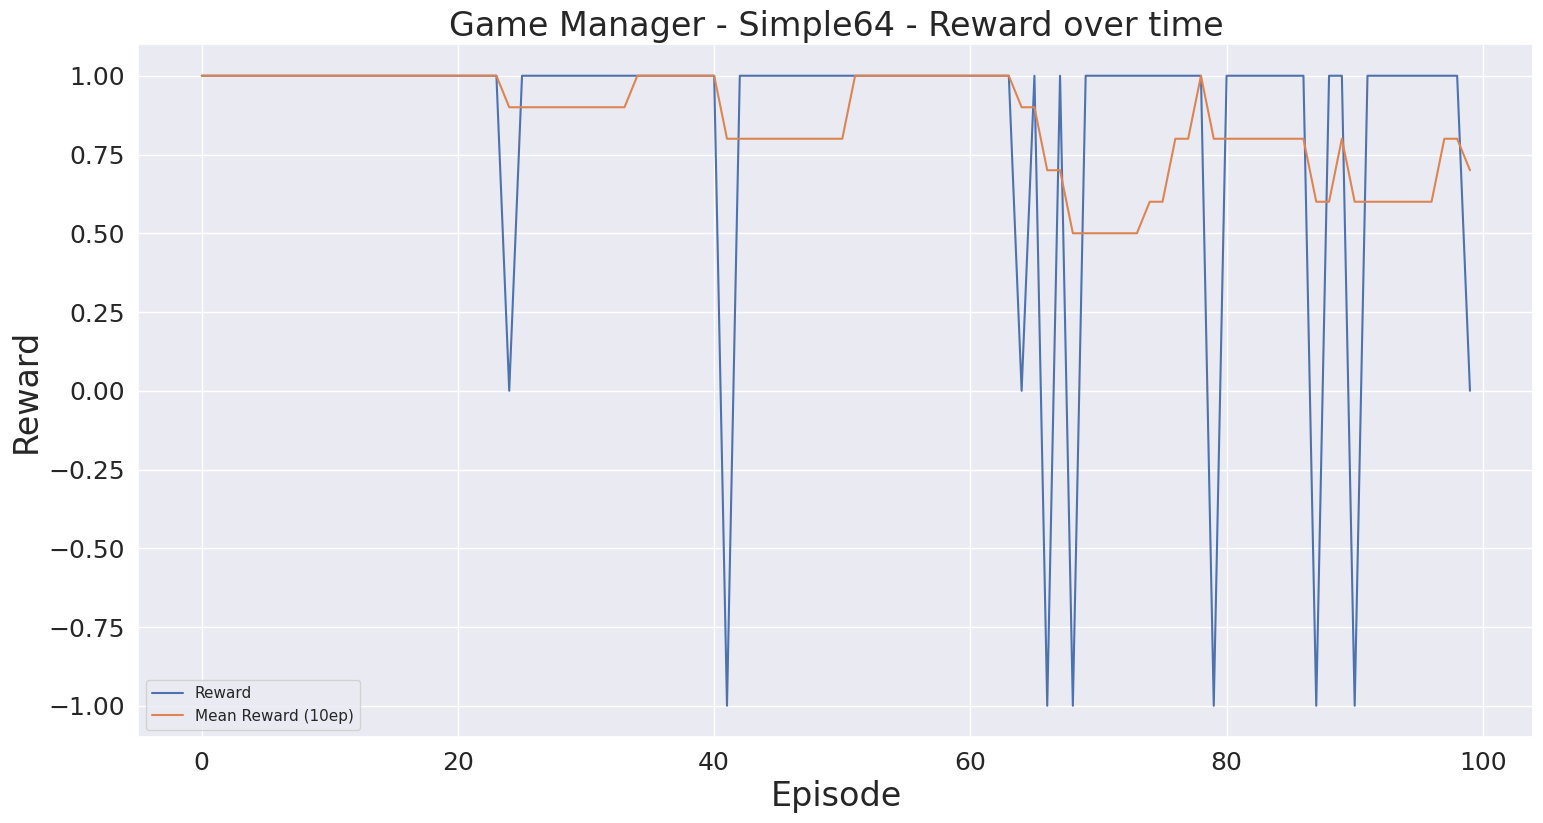

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


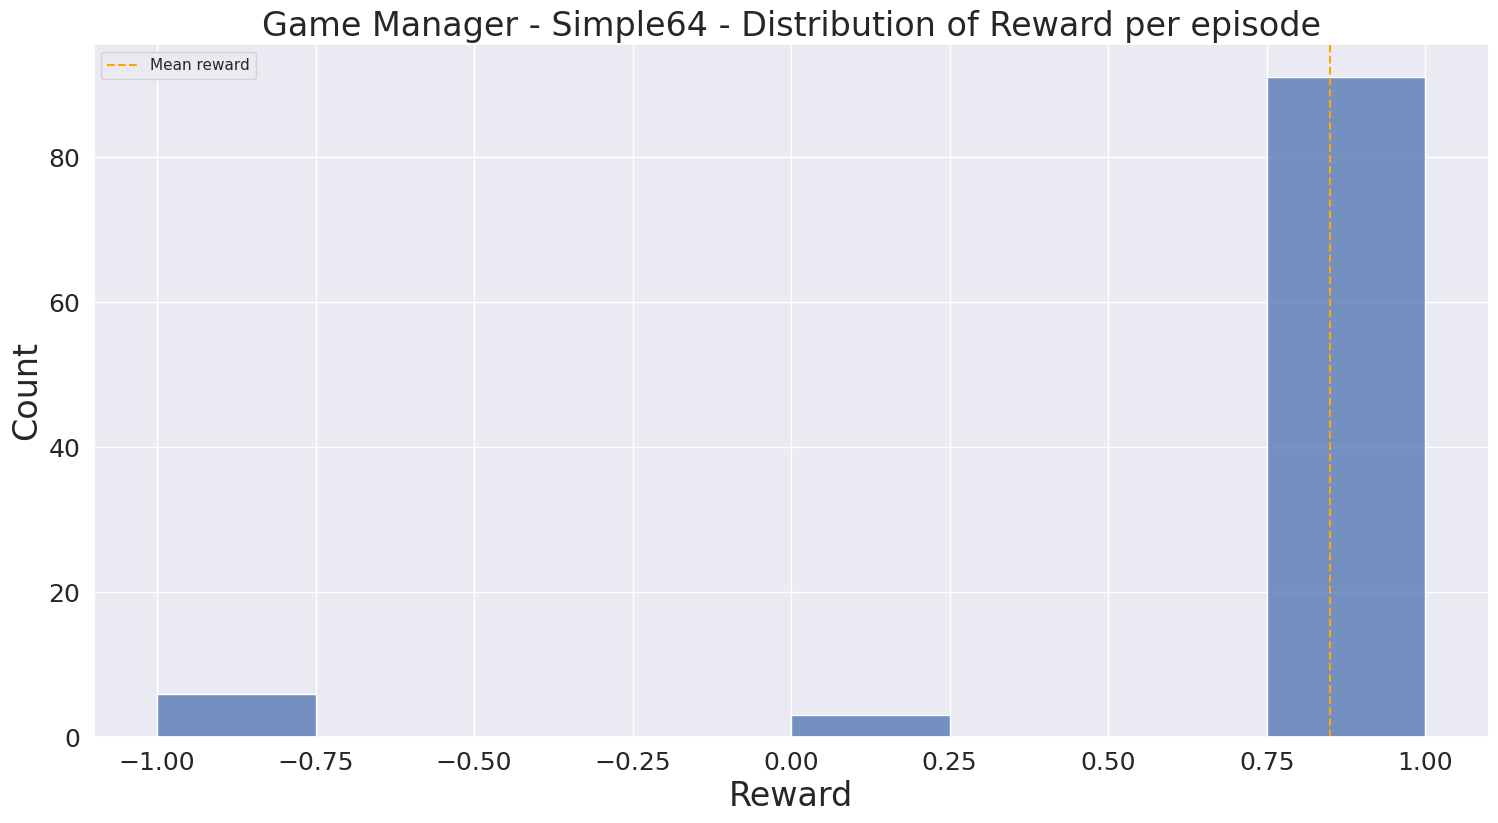

In [115]:
plot_rewards(stages=["EXPLOIT"], **plot_args) ;

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_237175/36005380.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=episode_stats, x="episode", y=mean_col, palette=["orange"], label=f"Mean {label} (10ep)")


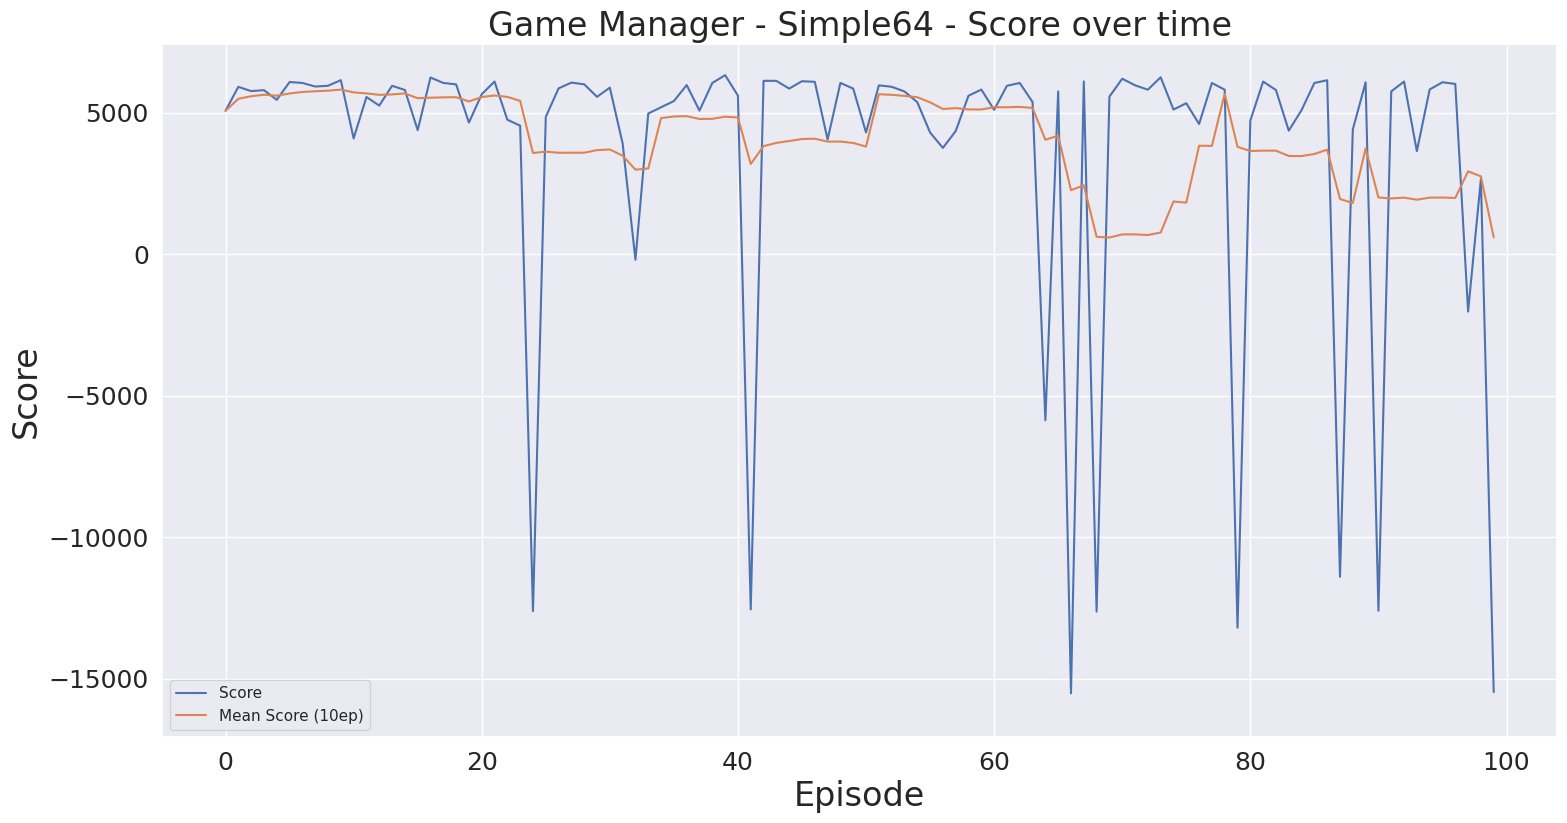

Plotting only EXPLOIT episodes


/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/david/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


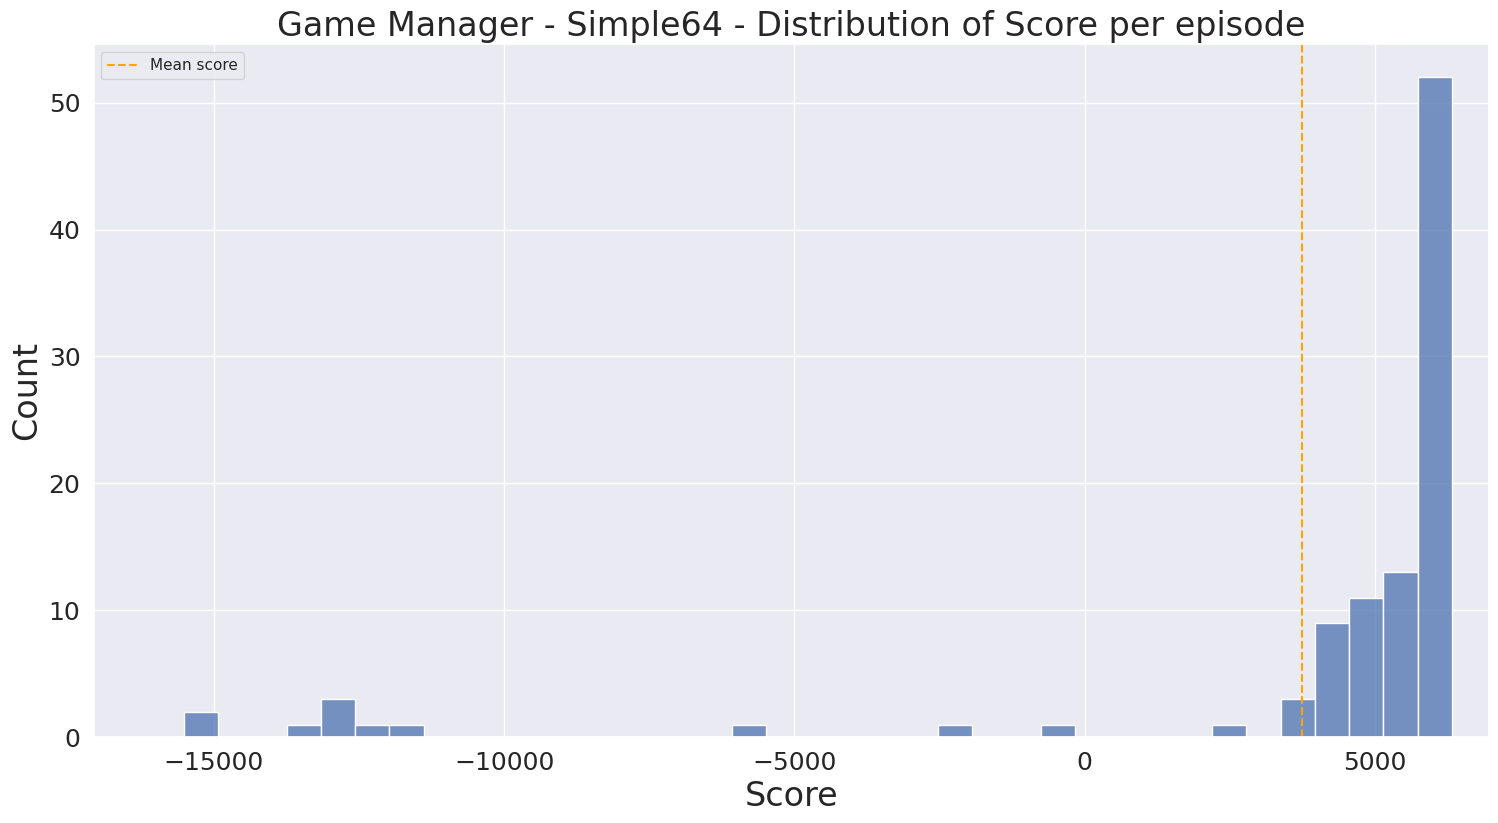

In [116]:
plot_scores(stages=["EXPLOIT"], **plot_args) ;

Min/AVG/Max steps per episode:  49 82.52857142857142 428
Plotting only TRAINING episodes


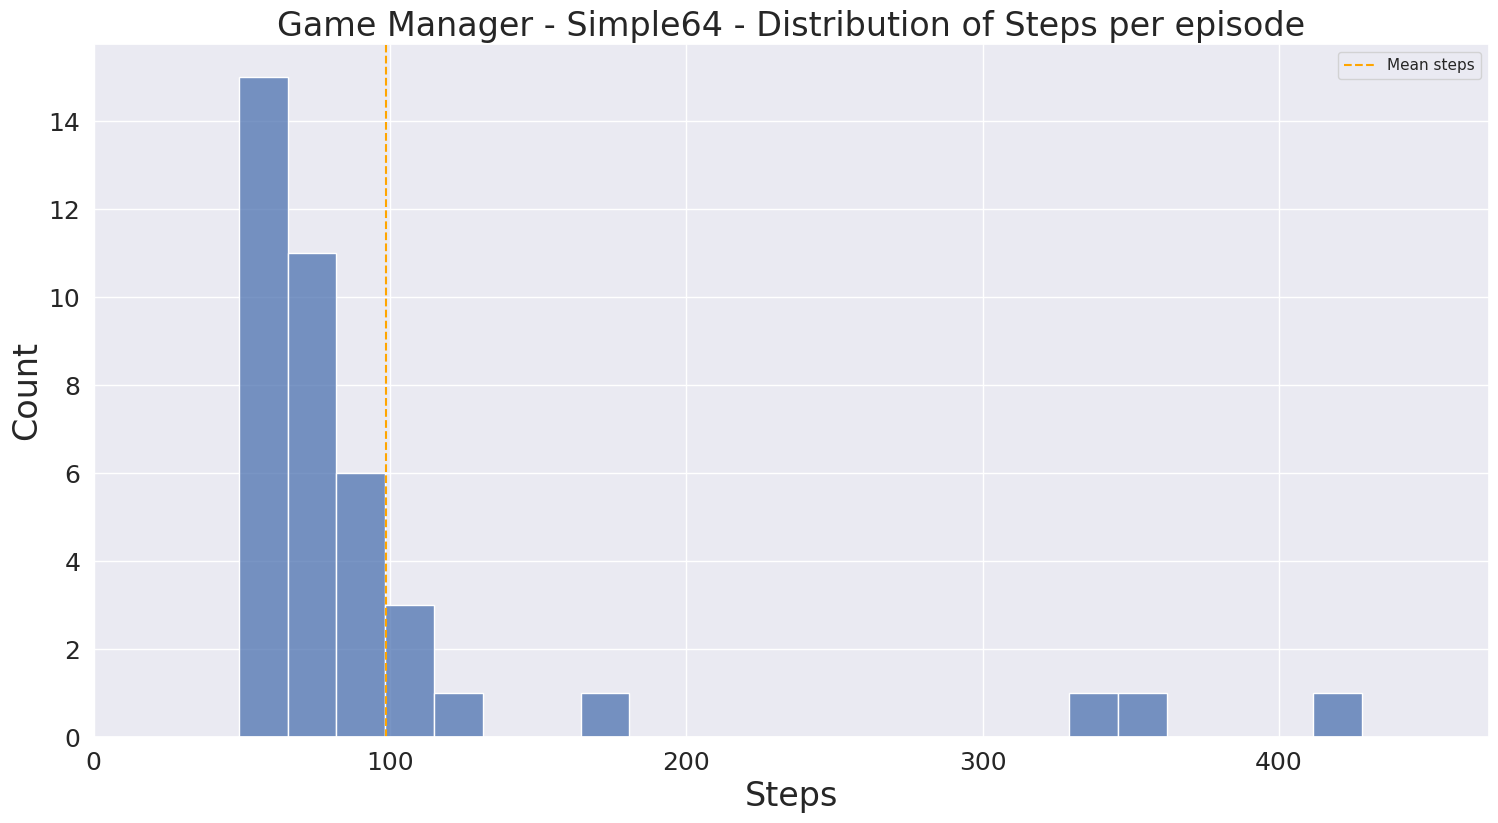

In [117]:
print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args) ;

Plotting only TRAINING episodes


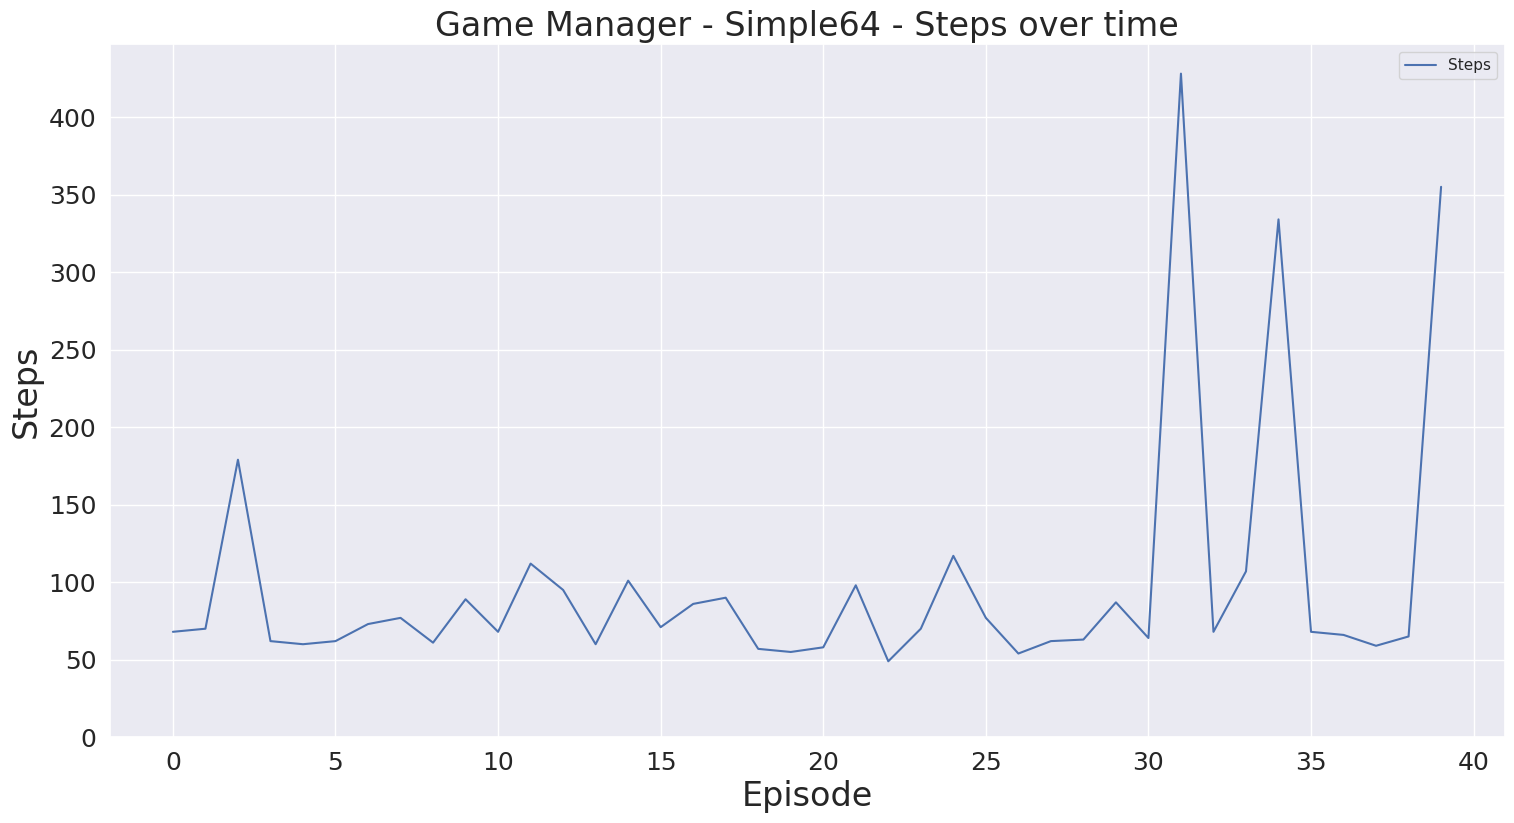

In [118]:
plot_steps_over_time(**plot_args) ;

In [119]:
training_stats = episode_stats[episode_stats["initial_stage"] == "TRAINING"].copy()
training_stats = add_extra_metrics(training_stats)
good_episode = 170
bad_episode = 186

In [120]:
training_stats[training_stats["episode"] == good_episode].iloc[0]["reward"]

IndexError: single positional indexer is out-of-bounds

In [ ]:
training_stats[training_stats["episode"] == good_episode].iloc[0]["valid_action_counts"]

In [ ]:
training_stats[training_stats["episode"] == good_episode].iloc[0]["invalid_action_counts"]

In [ ]:
training_stats[training_stats["episode"] == good_episode].iloc[0]["steps"]

In [ ]:
training_stats[training_stats["episode"] == 186].iloc[0]["reward"]

In [ ]:
training_stats[training_stats["episode"] == bad_episode].iloc[0]["valid_action_counts"]

In [ ]:
training_stats[training_stats["episode"] == bad_episode].iloc[0]["invalid_action_counts"]

In [ ]:
training_stats[training_stats["episode"] == bad_episode].iloc[0]["steps"]

In [ ]:
model_id = "game_manager"
scenario_name = "Simple64"
reward_scheme = "score"
reward_scheme_name = "Score-based"

model_suffix = f"multi_dqn_{model_id}_{reward_scheme}"
print(model_suffix)
model_name = f"Feudal Agent - {reward_scheme_name} rewards"
common_args = dict(model_name=model_name, use_stages=False)
episode_stats_before, _, _, _ = load_stats(model_suffix, model_path=models_path04, show_plots=False, **common_args)


In [ ]:
model_id = "game_manager"
scenario_name = "Simple64"
reward_scheme = "score"
reward_scheme_name = "Score-based"

model_suffix = f"multi_dqn_{model_id}_{reward_scheme}"
print(model_suffix)
model_name = f"Feudal Agent - {reward_scheme_name} rewards"
common_args = dict(model_name=model_name, use_stages=False)
episode_stats_after, _, _, _ = load_stats(model_suffix, model_path=models_path, show_plots=False, **common_args)


In [61]:
def plot_hist(episode_stats, model_name: str, label: str, metric_column: str, use_stages: bool = True, save_path: Path = None, save_prefix: str = None, train_only: bool = True):
    if train_only:
        print("Plotting only TRAINING episodes")
        episode_stats = episode_stats[episode_stats["initial_stage"] == "TRAINING"].copy()
        episode_stats = add_extra_metrics(episode_stats)

    if (not use_stages) or len(episode_stats["initial_stage"].unique()) < 2:
        extra_args = dict(label=label)
    else:
        extra_args = dict(hue="initial_stage")
        
    # ax = sns.lineplot(data=episode_stats, x="episode", y="reward", **extra_args)
    ax = sns.histplot(data=episode_stats, x=metric_column)
    ax.set_title(f"{model_name} - Distribution of {label} per episode", fontsize=24)
    ax.set_xlabel(label,fontsize=24)
    ax.set_ylabel("Count",fontsize=24)
    ax.tick_params(labelsize=18)
    
    plt.axvline(episode_stats[metric_column].mean(), c="orange", label=f"Mean {metric_column}", linestyle="--") ;
    
    if save_path is not None:
        save_path.mkdir(exist_ok=True, parents=True)
        filename = f"{metric_column}_hist.png" if save_prefix is None else f"{save_prefix}_{metric_column}_hist.png"
        plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)

    min_value = episode_stats[metric_column].min()
    max_value = episode_stats[metric_column].max()
    plt.xlim(left=min(0, min_value * 1.1), right=max_value * 1.1)
    plt.legend()
    plt.show()

In [ ]:
label = "Steps"
metric_column = "steps"
ax = sns.histplot(data=episode_stats_before, x=metric_column, color="orange", edgecolor="red", label="Without step penalty", alpha=.5)
ax.set_title(f"Feudal agent with score-based rewards - Distribution of {label} per episode", fontsize=24)
ax.set_xlabel(label,fontsize=24)
ax.set_ylabel("Count",fontsize=24)
ax.tick_params(labelsize=18)
plt.axvline(episode_stats_before[metric_column].mean(), c="red", label=f"Mean {metric_column} without step penalty", linestyle="--") ;

sns.histplot(data=episode_stats_after, x=metric_column, color="blue", edgecolor="darkblue", label="With -0.1 step penalty", alpha=.5)
plt.axvline(episode_stats_after[metric_column].mean(), c="darkblue", label=f"Mean {metric_column} with -0.1 step penalty", linestyle="--") ;

min_value = min(episode_stats_before[metric_column].min(), episode_stats_after[metric_column].min())
max_value = max(episode_stats_before[metric_column].max(), episode_stats_after[metric_column].max())
plt.xlim(left=min(0, min_value * 1.1), right=2000)#max_value * 1.1)
plt.savefig(images_path / "feudal_agent_before_and_after_fix_steps_hist.png", bbox_inches='tight', pad_inches=0)
plt.legend()
plt.show() ;

## Default reward scheme - trained for less episodes

### Sub-agents

In [ ]:
model_id = "base_manager"
scenario_name = "CollectMinerals"
reward_scheme = "reward"
reward_scheme_name = "Default"
models_path_less_episodes = project_root_path / "models" / "05_shorter"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}"
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Base Manager - {reward_scheme_name} rewards"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
_, _, _, emission_stats_bm = load_stats(model_suffix, model_path=models_path_less_episodes, show_plots=False, **common_args)
energy_bm = emission_stats_bm.iloc[-1]["energy_consumed"]
energy_bm
# plot_args = dict(episode_stats=episode_stats, **common_args)
# episode_stats.head()

In [ ]:
model_id = "army_recruit_manager"
scenario_name = "BuildMarines"
reward_scheme = "reward"
reward_scheme_name = "Default"
models_path_less_episodes = project_root_path / "models" / "05_shorter"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}"
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Army Recruit Manager - {reward_scheme_name} rewards"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
_, _, _, emission_stats_rm = load_stats(model_suffix, model_path=models_path_less_episodes, show_plots=False, **common_args)
energy_rm = emission_stats_rm.iloc[-1]["energy_consumed"]
energy_rm

In [ ]:
model_id = "army_attack_manager"
scenario_name = "DefeatZerglingsAndBanelings"
reward_scheme = "reward"
reward_scheme_name = "Default"
models_path_less_episodes = project_root_path / "models" / "05_shorter"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}"
save_images_path = images_path / model_suffix
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Army Attack Manager - {reward_scheme_name} rewards"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
_, _, _, emission_stats_am = load_stats(model_suffix, model_path=models_path_less_episodes, show_plots=False, **common_args)
energy_am = emission_stats_am.iloc[-1]["energy_consumed"]
energy_am

In [ ]:
total_energy = energy_bm + energy_rm + energy_am
total_energy, energy_bm, energy_rm, energy_am

### Train 01

In [117]:
all_episode_stats = []
all_agent_stats = []
all_aggregated_stats = []
all_emission_stats = []

In [ ]:
model_id = "game_manager"
scenario_name = "Simple64"
reward_scheme = "reward"
reward_scheme_name = "Default"
models_path_less_episodes = project_root_path / "models" / "05_shorter"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}_train01"
save_images_path = images_path / f"{model_suffix}_less_episodes"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Feudal Agent trained for 50 episodes"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_suffix, model_path=models_path_less_episodes, show_plots=False, **common_args)
all_episode_stats.append(episode_stats)
all_agent_stats.append(agent_stats)
all_aggregated_stats.append(aggregated_stats)
all_emission_stats.append(emission_stats)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

In [ ]:
value_counts = episode_stats[episode_stats["initial_stage"] == "TRAINING"]["reward"].value_counts()
total_lost = value_counts[-1]
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1]
total_games = total_won + total_lost + total_ties
pct_victories01 = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories01:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

In [ ]:
emission_stats.iloc[-1]

In [ ]:
plot_emissions(emission_stats, save_images_path, model_name) ;

In [ ]:
plot_losses(**plot_args) ;
plot_rewards(**plot_args) ;
# plot_scores(**plot_args) ;
plot_epsilon(**plot_args) ;

print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args) ;

### Train 02

In [ ]:
model_id = "game_manager"
scenario_name = "Simple64"
reward_scheme = "reward"
reward_scheme_name = "Default"
models_path_less_episodes = project_root_path / "models" / "05_shorter"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}_train02"
save_images_path = images_path / f"{model_suffix}_less_episodes"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Feudal Agent trained for 50 episodes"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_suffix, model_path=models_path_less_episodes, show_plots=False, **common_args)
all_episode_stats.append(episode_stats)
all_agent_stats.append(agent_stats)
all_aggregated_stats.append(aggregated_stats)
all_emission_stats.append(emission_stats)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

In [ ]:
value_counts = episode_stats[episode_stats["initial_stage"] == "TRAINING"]["reward"].value_counts()
total_lost = value_counts[-1]
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1]
total_games = total_won + total_lost + total_ties
pct_victories02 = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories02:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

In [ ]:
plot_emissions(emission_stats, save_images_path, model_name) ;
plot_losses(**plot_args) ;
plot_rewards(**plot_args) ;
# plot_scores(**plot_args) ;
plot_epsilon(**plot_args) ;

print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args) ;

### Train 03

In [ ]:
model_id = "game_manager"
scenario_name = "Simple64"
reward_scheme = "reward"
reward_scheme_name = "Default"
models_path_less_episodes = project_root_path / "models" / "05_shorter"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}_train03"
save_images_path = images_path / f"{model_suffix}_less_episodes"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Feudal Agent trained for 50 episodes"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_suffix, model_path=models_path_less_episodes, show_plots=False, **common_args)
all_episode_stats.append(episode_stats)
all_agent_stats.append(agent_stats)
all_aggregated_stats.append(aggregated_stats)
all_emission_stats.append(emission_stats)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

In [ ]:
value_counts = episode_stats[episode_stats["initial_stage"] == "TRAINING"]["reward"].value_counts()
total_lost = value_counts[-1]
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1]
total_games = total_won + total_lost + total_ties
pct_victories03 = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories03:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

In [ ]:
plot_emissions(emission_stats, save_images_path, model_name) ;
plot_losses(**plot_args) ;
plot_rewards(**plot_args) ;
# plot_scores(**plot_args) ;
plot_epsilon(**plot_args) ;

print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args) ;

### Train 04

In [ ]:
model_id = "game_manager"
scenario_name = "Simple64"
reward_scheme = "reward"
reward_scheme_name = "Default"
models_path_less_episodes = project_root_path / "models" / "05_shorter"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}_train04"
save_images_path = images_path / f"{model_suffix}_less_episodes"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Feudal Agent trained for 50 episodes"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_suffix, model_path=models_path_less_episodes, show_plots=False, **common_args)
all_episode_stats.append(episode_stats)
all_agent_stats.append(agent_stats)
all_aggregated_stats.append(aggregated_stats)
all_emission_stats.append(emission_stats)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

In [ ]:
value_counts = episode_stats[episode_stats["initial_stage"] == "TRAINING"]["reward"].value_counts()
total_lost = value_counts[-1]
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1]
total_games = total_won + total_lost + total_ties
pct_victories04 = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories04:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

In [ ]:
plot_emissions(emission_stats, save_images_path, model_name) ;
plot_losses(**plot_args) ;
plot_rewards(**plot_args) ;
# plot_scores(**plot_args) ;
plot_epsilon(**plot_args) ;

print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args) ;

### Train 05

In [ ]:
model_id = "game_manager"
scenario_name = "Simple64"
reward_scheme = "reward"
reward_scheme_name = "Default"
models_path_less_episodes = project_root_path / "models" / "05_shorter"
model_suffix = f"multi_dqn_{model_id}_{reward_scheme}"
save_images_path = images_path / f"{model_suffix}_less_episodes"
save_images_path.mkdir(exist_ok=True, parents=True)
model_name = f"Feudal Agent trained for 50 episodes"
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_suffix, model_path=models_path_less_episodes, show_plots=False, **common_args)
all_episode_stats.append(episode_stats)
all_agent_stats.append(agent_stats)
all_aggregated_stats.append(aggregated_stats)
all_emission_stats.append(emission_stats)
plot_args = dict(episode_stats=episode_stats, **common_args)
episode_stats.head()

In [ ]:
value_counts = episode_stats[episode_stats["initial_stage"] == "TRAINING"]["reward"].value_counts()
total_lost = value_counts[-1]
total_ties = value_counts[0] if 0 in value_counts else 0
total_won = value_counts[1]
total_games = total_won + total_lost + total_ties
pct_victories05 = total_won / total_games
pct_ties = total_ties / total_games
pct_lost = total_lost / total_games
print(f"Win rate: {100 * pct_victories05:.2f}%")
print(f"Tie rate: {100 * pct_ties:.2f}%")
print(f"Lose rate: {100 * pct_lost:.2f}%")

In [ ]:
plot_emissions(emission_stats, save_images_path, model_name) ;
plot_losses(**plot_args) ;
plot_rewards(**plot_args) ;
# plot_scores(**plot_args) ;
plot_epsilon(**plot_args) ;

print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args) ;

### All together

In [ ]:
all_episode_stats.append(episode_stats)
all_agent_stats.append(agent_stats)
all_aggregated_stats.append(aggregated_stats)
all_emission_stats.append(emission_stats)

In [ ]:
all_win_rates = [pct_victories01, pct_victories02, pct_victories03, pct_victories04, pct_victories05]
np.mean(all_win_rates), min(all_win_rates), max(all_win_rates)

In [ ]:
all_win_rates

In [107]:
def plot_line2(episode_stats, title: str, label: str, metric_column: str, use_stages: bool = True, save_path: Path = None, save_prefix: str = None, train_only: bool = True, show: bool = False):
    if train_only:
        print("Plotting only TRAINING episodes")
        episode_stats = episode_stats[episode_stats["initial_stage"] == "TRAINING"].copy()
        episode_stats = add_extra_metrics(episode_stats)

    extra_args = dict(label=label)
        
    # ax = sns.lineplot(data=episode_stats, x="episode", y=metric_column, **extra_args)
    mean_col = f"mean_{metric_column}_10ep"
    # if mean_col in list(episode_stats):
    ax = sns.lineplot(data=episode_stats, x="episode", y=mean_col, label=f"Mean {label} (10ep)")
    ax.set_title(title, fontsize=24)
    ax.set_xlabel("Episode", fontsize=24)
    ax.set_ylabel(label, fontsize=24)
    ax.tick_params(labelsize=18)
    
    if save_path is not None:
        save_path.mkdir(exist_ok=True, parents=True)
        filename = f"{metric_column}.png" if save_prefix is None else f"{save_prefix}_{metric_column}.png"
        plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
    min_value = episode_stats[metric_column].min()
    plt.ylim(bottom=min(0, min_value * 1.1))
    if show:
        plt.show()

In [ ]:
def plot_rewards(**kwargs):
    plot_rewards_over_time(**kwargs)
    plot_rewards_hist(**kwargs)

def plot_rewards_over_time(**kwargs):
    plot_line(label="Reward", metric_column="reward", **kwargs)

def plot_rewards_hist(**kwargs):
    plot_hist(label="Reward", metric_column="reward", **kwargs)

In [ ]:
common_args = dict(model_name=model_name, use_stages=False, save_path=save_images_path)
episode_stats, agent_stats, aggregated_stats, emission_stats = load_stats(model_suffix, model_path=models_path, show_plots=False, **common_args)
plot_args = dict(episode_stats=episode_stats, model_n)

In [ ]:
for ep_stats in all_episode_stats:
    plot_line2(ep_stats, title="Game Manager - trained for 50 episodes only", label="Reward", metric_column="reward")
plt.show()
    

In [ ]:
images_path

In [ ]:
for idx, ep_stats in enumerate(all_episode_stats):
    save_path = None if idx < 4 else images_path
    plot_line2(ep_stats, title="Game Manager - trained for 50 episodes only", label=f"Loss - Train {idx + 1:02d}", metric_column="loss", save_path=save_path)
plt.show()
    

In [ ]:
plot_rewards(**plot_args) ;
# plot_scores(**plot_args) ;
plot_epsilon(**plot_args) ;

print("Min/AVG/Max steps per episode: ", episode_stats["steps"].min(), episode_stats["steps"].mean(), episode_stats["steps"].max())
plot_steps_hist(**plot_args) ;

In [ ]:
def plot_emissions2(emission_stats, model_name, save_path=None, show = False):
    label = "Total Energy consumed over time (kWh)"
    metric_column = "energy_consumed"

    ax = sns.lineplot(data=emission_stats, x="accumulated_time", y=metric_column, label=label)
    ax.set_title(f"{label} - {model_name}", fontsize=24)
    ax.set_xlabel("Time (seconds)", fontsize=24)
    ax.set_ylabel("Energy (kWh)", fontsize=24)
    ax.tick_params(labelsize=18)
    
    if save_path is not None:
        save_path.mkdir(exist_ok=True, parents=True)
        filename = f"{metric_column}.png"
        plt.savefig(save_path / filename, bbox_inches='tight', pad_inches=0)
    min_value = emission_stats[metric_column].min()
    plt.ylim(bottom=min(0, min_value * 1.1))
    plt.show()